In [4]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal, multivariate_t, norm
import networkx as nx
import yfinance as yf
import sys
sys.path.insert(0, 'C:/Users/ragna/Documents/Code/DyGraph/src')
sys.path.insert(0, 'C:/Users/ragna/Documents/Code/DyGraph')

import DyGraph as dg
import port_measures as pm
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy
from scipy.optimize import minimize

import pickle





In [5]:
def gen_all_all_zero(d,s, v1 = 1.1, v2 = 1.1):

    while True:
        # G =nx.erdos_renyi_graph(d, s, seed=42)


        # A = np.array(nx.adjacency_matrix(G).todense())
        # A[np.tril_indices(d)] = 0
        # U = np.random.binomial(1,0.5,  size = (d,d))
        # A = np.multiply(A, U*np.random.uniform(-0.6,-0.2, size = (d,d)) + (1-U)*np.random.uniform(0.2,0.6, size = (d,d)))
        # A = A+A.T
        # np.fill_diagonal(A, np.sum(np.abs(A),axis=1))


        k = d
        sparsity = s
        # generate the symmetric sparsity mask
        mask = np.random.uniform(size=(k,k))
        mask = mask * (mask < sparsity)
        mask[np.tril_indices(k,0)] = 0
        mask = mask + mask.T + np.identity(k)
        mask[mask > 0] = 1

        # generate the symmetric precision matrix
        A = np.random.uniform( size = (k,k))
        A[np.tril_indices(k,0)] = 0
        A = A + A.T + np.identity(k)

        # apply the reqired sparsity
        A = A * mask

        # force it to be positive definite
        l,u = np.linalg.eigh(A)
        A = A - (np.min(l)-.1) * np.identity(k)

        A2 = A.copy()
        A2_SIGNS = np.sign(A2)
        A2 = np.power(np.abs(A2), v1)
        A2 = A2*A2_SIGNS
        np.fill_diagonal(A2,np.diag(A))

        A3 = A2.copy()
        A3_SIGNS = np.sign(A3)
        A3 = np.power(np.abs(A3), v2)
        A3 = A3*A3_SIGNS
        np.fill_diagonal(A3,np.diag(A))


        try:
            np.linalg.inv(A)
            np.linalg.inv(A2)
            np.linalg.inv(A3)
        except:
            continue


        break

    return np.array([A, A2, A3])


def my_hdtest(Z, cov_Z, Y, cov_Y):

    d = Z.shape[1]
    n1 = Z.shape[0]
    n2 = Y.shape[0]



    za = (Z - np.mean(Z,0))
    vz = np.dot((za**2).T, za**2)/n1 - (2/n1 )*np.dot(za.T, za)*cov_Z + cov_Z**2


    ya = (Y - np.mean(Y,0))
    vy = np.dot((ya**2).T, ya**2)/n2 - (2/n2 )*np.dot(ya.T, ya)*cov_Y + cov_Y**2


    CLX = np.max((cov_Z-cov_Y)**2/(vz/n1+vy/n2))


    CLX_test = CLX-(4*np.log(d)-np.log(np.log(d)))
    p_val = 1 - np.exp(-np.exp(-CLX_test/2)/(np.sqrt(8*np.pi)))
    return p_val, CLX_test


def hdtest_boot(Z, cov_Z, Y, cov_Y, B):

    test_stat = np.zeros(B)

    X = np.vstack((Z,Y))

    _,t_stat_sample= my_hdtest(Z, cov_Z, Y, cov_Y)
    
    for i in range(B):
        
        #from sklearn.model_selection import train_test_split
        #X1_tmp, X2_tmp = train_test_split(X, test_size=0.5)

        X1_tmp = X[np.random.choice(X.shape[0], X.shape[0])]
        X2_tmp = X[np.random.choice(X.shape[0], X.shape[0])]
        p,test_stat[i] = my_hdtest(X1_tmp, cov_Z, X2_tmp, cov_Y) # out['statistics'][0] #
    
    return np.sum(test_stat >t_stat_sample)/len(test_stat),t_stat_sample,test_stat



def gen_local_change(d, s):

    k = d
    sparsity = s
    rnd = np.random.RandomState(42)
    while True:

        # generate the symmetric sparsity mask
        mask = rnd.uniform(size=(k,k))
        mask = mask * (mask < sparsity)
        mask[np.tril_indices(k,0)] = 0
        mask = mask + mask.T + np.identity(k)
        mask[mask > 0] = 1

        # generate the symmetric precision matrix
        A = rnd.uniform( size = (k,k))
        A[np.tril_indices(k,0)] = 0
        A = A + A.T + np.identity(k)

        # apply the reqired sparsity
        A = A * mask

        # force it to be positive definite
        l,u = np.linalg.eigh(A)
        A = A - (np.min(l)-.5) * np.identity(k)

        A2 = A.copy()
        shut_index = rnd.uniform(low =0, high = 0.5, size = A.shape)
        shut_index = shut_index +shut_index.T
        np.fill_diagonal(shut_index,1)
        shut_index = shut_index <0.3
        A2[shut_index] = 0


        for i in range(k):
            for j in range(i+1, k):
                if rnd.uniform()<0.3:
                    A2[i,j] = rnd.uniform(low = -1, high = 1)
                    A2[j,i] = A2[i,j]


        A3 = A2.copy()
        shut_index = rnd.uniform(low =0, high = 0.5, size = A.shape)
        shut_index = shut_index +shut_index.T
        np.fill_diagonal(shut_index,1)
        shut_index = shut_index <0.3
        A3[shut_index] = 0

        for i in range(k):
            for j in range(i+1, k):
                if rnd.uniform()<0.3:
                    A3[i,j] = rnd.uniform(low = -1, high = 1)
                    A3[j,i] = A3[i,j]



        try:
            u = np.linalg.eigvals(A)
            assert np.all(u>=0)
            u = np.linalg.eigvals(A2)
            assert np.all(u>=0)
            u = np.linalg.eigvals(A3)
            assert np.all(u>=0)
        except: 
            continue

        break




    return np.array([A, A2, A3])

In [6]:
def log_lik(mean,cov, X, liktype, nu = None, prec = None, gamma = None, n = 10):

    if liktype == "gaussian":
        lik = np.sum(multivariate_normal.logpdf(X, mean=mean, cov=cov, allow_singular=True))
    elif liktype == "t":
        lik = np.sum(multivariate_t.logpdf(X,loc = mean, shape=cov, df = nu))
    elif np.isin(liktype, ("skew-group-t", "group-t")):
        lik  = 0.0
        #print(X)
        for i in range(X.shape[0]):
            lik += np.log(dg.generalized_skew_t( X[i], prec, nu = nu, gamma = gamma, n = n))
    else:
        assert False, "likelihood not correct"

    return lik

def log_lik_all(w, thetas, X, lik_type, nus = None, gammas = None):

    if gammas is None:
        gammas = [None] * len(thetas)
    
    if nus is None:
        nus = [None] * len(thetas)

    lik_tmp = []
    for j in range(len(thetas)):
        lik_tmp.append(log_lik(np.zeros(thetas[j].shape[1]) ,np.linalg.inv(thetas[j]), X[j*w:(j+1)*w], liktype = lik_type, prec =thetas[j],  nu = nus[j], gamma = gammas[j]))

    return np.array(lik_tmp)
            
def find_nr_params(thetas, lik_type):
    
    nr_params_tmp = []
    for iii in range(len(thetas)):
        theta_t = thetas[iii].copy()
        theta_t[np.abs(theta_t)<1e-4] = 0
        if lik_type == 't':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + 1.0)
        elif lik_type == 'group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]))
        elif lik_type == 'skew-group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]) + float(theta_t.shape[0]))
        else:
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0))

    return np.array(nr_params_tmp)




In [4]:
obs_per_graph = 100
lik_type='gaussian'
tol = 1e-6

# load and scale data
with open(f'../data/AQI/cleaned_aqi.pkl', 'rb') as handle:
    ts_df = pickle.load(handle)

# Get lat long
wikiurl="https://en.wikipedia.org/wiki/User:Michael_J/County_table"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
sites = pd.read_html(response.content)[-1]
sites = sites.loc[(sites['State'] == 'CA') & np.isin(sites['County [2]'], ts_df.columns)]
sites.head()


sites['Latitude'] = sites['Latitude'].str.replace('°','')
sites['Latitude'] = sites['Latitude'].str.replace('+','')
sites['Latitude'] = sites['Latitude'].str.replace('–','')
sites['Latitude'] = sites['Latitude'].astype(float)
sites['Longitude'] = sites['Longitude'].str.replace('°','')
sites['Longitude'] = sites['Longitude'].str.replace('+','')
sites['Longitude'] = sites['Longitude'].str.replace('–','')
sites['Longitude'] = sites['Longitude'].astype(float)

import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d


locs = np.array(sites[['Latitude', 'Longitude']])
d = locs.shape[0]
R = np.zeros((d, d))

for i in range(d):
    for j in range(d):
        R[i,j] = distance(locs[i], locs[j])

R = R/np.max(R)


R = R[np.ix_(range(10),range(10))]
scaler = StandardScaler()
ts_df_scaled = scaler.fit_transform(ts_df)
ts_df_scaled = ts_df_scaled[2400:2700, :10]




dg_opt1 = dg.dygl_inner_em(ts_df_scaled, obs_per_graph = obs_per_graph, max_iter = 10000, lamda = 0.1*R, kappa =0.05, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

C:\Users\User\AppData\Local\Temp\ipykernel_20768\3287816020.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sites['Latitude'] = sites['Latitude'].str.replace('+','')
C:\Users\User\AppData\Local\Temp\ipykernel_20768\3287816020.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sites['Longitude'] = sites['Longitude'].str.replace('+','')


(-2.0, 2.0)

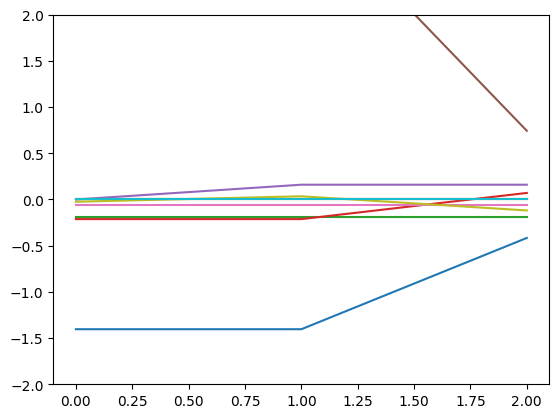

In [8]:
plt.plot(dg_opt1.theta[:,:,5])
plt.ylim((-2,2))

# Test new theory

zero-one no boostrap test case 2

In [5]:
import numpy as np
import sys
sys.path.insert(0, 'C:/Users/User/Code/DyGraph/src')
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import tqdm
import scipy
from multiprocessing.pool import Pool


import pickle



def gen_all_all_zero(d,s, v1 = 1.1, v2 = 1.1):

    while True:


        k = d
        sparsity = s
        rnd = np.random.RandomState(42)
        # generate the symmetric sparsity mask
        mask = rnd.uniform(size=(k,k))
        mask = mask * (mask < sparsity)
        mask[np.tril_indices(k,0)] = 0
        mask = mask + mask.T + np.identity(k)
        mask[mask > 0] = 1

        # generate the symmetric precision matrix
        A = rnd.uniform( size = (k,k))
        A[np.tril_indices(k,0)] = 0
        A = A + A.T + np.identity(k)

        # apply the reqired sparsity
        A = A * mask

        # force it to be positive definite
        l,u = np.linalg.eigh(A)
        A = A - (np.min(l)-.1) * np.identity(k)

        A2 = A.copy()
        A2_SIGNS = np.sign(A2)
        A2 = np.power(np.abs(A2), v1)
        A2 = A2*A2_SIGNS
        np.fill_diagonal(A2,np.diag(A))

        A3 = A2.copy()
        A3_SIGNS = np.sign(A3)
        A3 = np.power(np.abs(A3), v2)
        A3 = A3*A3_SIGNS
        np.fill_diagonal(A3,np.diag(A))


        try:
            np.linalg.inv(A)
            np.linalg.inv(A2)
            np.linalg.inv(A3)
        except:
            continue


        break

    return np.array([A, A2, A3])


def gen_local_change(d, s):

    k = d
    sparsity = s
    rnd = np.random.RandomState(42)
    while True:

        # generate the symmetric sparsity mask
        mask = rnd.uniform(size=(k,k))
        mask = mask * (mask < sparsity)
        mask[np.tril_indices(k,0)] = 0
        mask = mask + mask.T + np.identity(k)
        mask[mask > 0] = 1

        # generate the symmetric precision matrix
        A = rnd.uniform( size = (k,k))
        A[np.tril_indices(k,0)] = 0
        A = A + A.T + np.identity(k)

        # apply the reqired sparsity
        A = A * mask

        # force it to be positive definite
        l,u = np.linalg.eigh(A)
        A = A - (np.min(l)-.5) * np.identity(k)

        A2 = A.copy()
        shut_index = rnd.uniform(low =0, high = 0.5, size = A.shape)
        shut_index = shut_index +shut_index.T
        np.fill_diagonal(shut_index,1)
        shut_index = shut_index <0.3
        A2[shut_index] = 0


        for i in range(k):
            for j in range(i+1, k):
                if rnd.uniform()<0.3:
                    A2[i,j] = rnd.uniform(low = -1, high = 1)
                    A2[j,i] = A2[i,j]


        A3 = A2.copy()
        shut_index = rnd.uniform(low =0, high = 0.5, size = A.shape)
        shut_index = shut_index +shut_index.T
        np.fill_diagonal(shut_index,1)
        shut_index = shut_index <0.3
        A3[shut_index] = 0

        for i in range(k):
            for j in range(i+1, k):
                if rnd.uniform()<0.3:
                    A3[i,j] = rnd.uniform(low = -1, high = 1)
                    A3[j,i] = A3[i,j]



        try:
            u = np.linalg.eigvals(A)
            assert np.all(u>=0)
            u = np.linalg.eigvals(A2)
            assert np.all(u>=0)
            u = np.linalg.eigvals(A3)
            assert np.all(u>=0)
        except: 
            continue

        break




    return np.array([A, A2, A3])


def my_hdtest(Z, cov_Z, Y, cov_Y):

    d = Z.shape[1]
    n1 = Z.shape[0]
    n2 = Y.shape[0]

    za = (Z - np.mean(Z,0))
    vz = np.dot((za**2).T, za**2)/n1 - (2/n1 )*np.dot(za.T, za)*cov_Z + cov_Z**2

    ya = (Y - np.mean(Y,0))
    vy = np.dot((ya**2).T, ya**2)/n2 - (2/n2 )*np.dot(ya.T, ya)*cov_Y + cov_Y**2

    CLX = np.max((cov_Z-cov_Y)**2/(vz/n1+vy/n2))

    CLX_test = CLX-(4*np.log(d)-np.log(np.log(d)))
    p_val = 1 - np.exp(-np.exp(-CLX_test/2)/(np.sqrt(8*np.pi)))
    return p_val, CLX_test


def hdtest_boot(Z, cov_Z, Y, cov_Y, B):

    test_stat = np.zeros(B)

    X = np.vstack((Z,Y))

    _,t_stat_sample= my_hdtest(Z, cov_Z, Y, cov_Y)
    for i in range(B):
        
        #from sklearn.model_selection import train_test_split
        #X1_tmp, X2_tmp = train_test_split(X, test_size=0.5)

        X1_tmp = X[np.random.choice(X.shape[0], X.shape[0])]
        X2_tmp = X[np.random.choice(X.shape[0], X.shape[0])]
        p,test_stat[i] = my_hdtest(X1_tmp, cov_Z, X2_tmp, cov_Y) # out['statistics'][0] #
    
    return np.sum(test_stat >t_stat_sample)/len(test_stat),t_stat_sample,test_stat

    
def CE_remove_lik(X,N, tail_prob_init, tail_prob_final, theta_1, nr_its = 2):

    tail_direction = np.sign(tail_prob_final-tail_prob_init)

    theta_1[np.abs(theta_1)<1e-3] = 0.0


    d = X.shape[1]

    nr_params = int(d*(d-1)/2)

    p = np.array([0.5]*nr_params)

    current_tail_prob = tail_prob_init
    for _ in range(nr_its):

        liks = np.zeros(N)  # store log-likelihoods
        B = scipy.stats.bernoulli.rvs(p = p, size = (N,nr_params))  

        # find optimal theta where B_i dictates which elements get regularized to infinity
        for i in range(N):
            theta_2 = np.zeros((d,d))
            theta_2[np.triu_indices(d,1)] = (1-B[i])*theta_1[np.triu_indices(d,1)]
            theta_2 = theta_2 + theta_2.T
            np.fill_diagonal(theta_2, np.diag(theta_1))

            try:
            
                liks[i] = np.sum(scipy.stats.multivariate_normal.logpdf(X, mean =np.zeros(d), cov = np.linalg.inv(theta_2))) - np.log(X.shape[0])*(np.sum(theta_2[np.triu_indices(d,1)] != 0))
            except:
                liks[i] = -np.inf


        val_func = np.quantile(liks, current_tail_prob)

        if tail_direction >0:
            current_tail_prob = np.min((tail_prob_final, current_tail_prob + 0.05 ))
        elif tail_direction <0: 
            current_tail_prob = np.max((tail_prob_final, current_tail_prob - 0.05 ))
        else:
            current_tail_prob = tail_prob_final

        

        # update p
        for i in range(nr_params):
            p[i] = np.sum((liks >= val_func)*B[:,i])/np.sum((liks >= val_func))


    # Finally use best estimate of I to get theta
    I = 1 * (p >0.5)
    theta_2 = np.zeros((d,d))
    theta_2[np.triu_indices(d,1)] = (1-I)*theta_1[np.triu_indices(d,1)]
    theta_2 = theta_2 + theta_2.T
    np.fill_diagonal(theta_2, np.diag(theta_1))

    return theta_2



def CE_glasso(X, w, N, tail_prob, nr_its, alpha, kappa, alpha_in_CE, metric, used):

    d = X.shape[1]

    nr_params = int(d*(d-1)/2)

    H = int(X.shape[0]/w)

    p = np.zeros((H, nr_its+1,nr_params))
    sigmas = np.zeros((H, nr_its+1, nr_params))

    p[:,0] = 0.5

    thetas_sim = np.zeros((N, H, d,d))

    pbar = tqdm.tqdm(total = nr_its, position=1)
    d = X.shape[1]
    nr_params = int(d*(d-1)/2)

    pbar = tqdm.tqdm(total = nr_its*N)
    
    value_vals = np.zeros((H,nr_its,N)) 
    for it_nr in range(1,nr_its+1):

        # find optimal theta where B_i dictates which elements get regularized to infinity



        # Draw bernoulli
        B = np.zeros((H,N,nr_params))
        for h in range(H):
            B[h] = scipy.stats.bernoulli.rvs(p = p[h,it_nr-1], size = (N,nr_params))   

        for i in range(N):


            # bootstrap refrence
            Xs = []
            for j in range(H):
                if j == 0:
                    Xs.append(X[j*w:((j+1)*w + 10)][np.random.choice(w+10, w)])
                elif j == H-1:
                    Xs.append(X[(j*w-10):(j+1)*w][np.random.choice(w+10, w)])
                else:
                    Xs.append(X[(j*w-5):((j+1)*w + 5)][np.random.choice(w+10, w)])
  
            Xs = np.vstack(Xs)


            dg_opt1 = dg.dygl_inner_em(Xs, obs_per_graph = w, max_iter = 2000, lamda = alpha, kappa =kappa, tol = 1e-4)
            dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
            theta_reference = dg_opt1.theta
            theta_reference[np.abs(theta_reference)<1e-3] = 0

        
            if alpha_in_CE:
                reg_matrix = np.ones((H,d,d))*alpha
            else:
                reg_matrix = np.zeros((H,d,d))
            for h in range(H):
                np.fill_diagonal(reg_matrix[h],0)
                reg_matrix[h][np.triu_indices(d,1)] = B[h,i]*999999
                reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T


            if used == 'xs_x':
                X_used = X.copy()
            elif used == 'xs_xs':
                X_used = Xs.copy()
            else:
                raise ValueError("check used argument")


                
            dg_opt2 = dg.dygl_inner_em(X_used, obs_per_graph = w, max_iter = 2000, lamda = reg_matrix, kappa =kappa, tol = 1e-3)
            dg_opt2.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
            dg_opt2.theta[np.abs(dg_opt2.theta)<1e-3] = 0
            
            thetas_sim[i] = dg_opt2.theta.copy()

            for h in range(H):
                if metric == 'cai':
                    _, val1 = my_hdtest(Xs[h*w:(h+1)*w], np.linalg.inv(theta_reference[h]),X_used[h*w:(h+1)*w], np.linalg.inv(dg_opt2.theta[h]))
                elif metric == 'zero-one':
                    val1 = -np.sum(np.sign(theta_reference[h][np.triu_indices(d,1)])==np.sign(dg_opt2.theta[h][np.triu_indices(d,1)]))
                #val1 = np.linalg.norm(theta_reference[0]-theta1)
                value_vals[h,it_nr-1,i] = val1
                #_, value_vals[h,it_nr-1,i] = my_hdtest(np.vstack((X1,X2)), np.linalg.inv(0.5*(theta_reference[0]+theta_reference[1])),np.vstack((X1,X2)), np.linalg.inv(0.5*(theta1+theta2)))
                #value_vals[h,it_nr-1,i] = np.linalg.norm(theta_reference[0]+theta_reference[1] - theta1 - theta2)
            pbar.update()

        # Get quantile (best value)
        val_func = np.zeros(H)
        for h in range(H):
            value_vals[h,it_nr-1] = -value_vals[h,it_nr-1]
            val_func[h] = np.quantile(value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])], tail_prob)
        
        # update p
        for h in range(H):
            for i in range(nr_params):
                p[h,it_nr, i] = np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*B[h,~np.isnan(value_vals[h,it_nr-1]),i])/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h]))
                sigmas[h,it_nr, i] = np.sqrt(np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*(B[h,~np.isnan(value_vals[h,it_nr-1]),i]-p[h,it_nr-1, i])**2)/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])]>= val_func[h])))

            s = np.exp(-2/it_nr)*0.9
            p[h,it_nr] = s*p[h,it_nr] + (1-s)*p[h,it_nr-1]


    pbar.close()

    return p, sigmas, thetas_sim



def run_sim(X, alpha, kappa, obs_per_graph, cnt_a, cnt_k, nr_ce_it, N, alpha_in_CE, tail_prob, metric, used):


    d = X.shape[1]
    n = X.shape[0]
    nr_params = int(d*(d-1)/2)
    p_distribution = np.ones((int(n/obs_per_graph), nr_ce_it+1, nr_params))
    sigmas = np.ones((int(n/obs_per_graph), nr_ce_it+1, nr_params))

    dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = obs_per_graph, max_iter = 10000, lamda = alpha, kappa = kappa, tol = 1e-6)
    dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
    thetas_point = dg_opt1.theta.copy()
    
    p_distribution, sigmas, thetas_sim = CE_glasso(X.copy(), obs_per_graph, N, tail_prob, nr_ce_it, alpha, kappa, alpha_in_CE, metric, used)

    return p_distribution, thetas_point, sigmas, thetas_sim, cnt_k, cnt_a




        

d = 10
s = 0.3
nr_ce_it = 60
N = 4000
As = gen_local_change(d,s)
nr_params = int(d*(d-1)/2)
tail_prob = 0.9
obs_per_graph = 50
ratio_nr_zeros = 0.9


rnd = np.random.RandomState(10)
X1 = rnd.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(As[0]), size = 50)
X2 = rnd.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[1]), size = 50)
X3 = rnd.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[2]), size = 50)

X = np.vstack([X1,X2,X3])

n = X.shape[0]
kappas = [0.05]# np.exp(-np.linspace(5, 0,20)) #[0.02, 0.05, 0.08, 0.15] #np.exp(-np.linspace(5, 0,6))
alphas = [0.05]#0.005, 0.01, ## np.exp(-np.linspace(5, 1.5,20)) #[0.01, 0.02, 0.03, 0.05, 0.09, 0.13]










In [16]:
def log_lik(mean,cov, X, liktype, nu = None, prec = None, gamma = None, n = 10):

    if liktype == "gaussian":
        lik = np.sum(multivariate_normal.logpdf(X, mean=mean, cov=cov, allow_singular=True))
    elif liktype == "t":
        lik = np.sum(multivariate_t.logpdf(X,loc = mean, shape=cov, df = nu))
    elif np.isin(liktype, ("skew-group-t", "group-t")):
        lik  = 0.0
        #print(X)
        for i in range(X.shape[0]):
            lik += np.log(dg.generalized_skew_t( X[i], prec, nu = nu, gamma = gamma, n = n))
    else:
        assert False, "likelihood not correct"

    return lik

def log_lik_all(w, thetas, X, lik_type, nus = None, gammas = None):

    if gammas is None:
        gammas = [None] * len(thetas)
    
    if nus is None:
        nus = [None] * len(thetas)

    lik_tmp = []
    for j in range(len(thetas)):
        lik_tmp.append(log_lik(np.zeros(thetas[j].shape[1]) ,np.linalg.inv(thetas[j]), X[j*w:(j+1)*w], liktype = lik_type, prec =thetas[j],  nu = nus[j], gamma = gammas[j]))

    return np.array(lik_tmp)
            
def find_nr_params(thetas, lik_type):
    
    nr_params_tmp = []
    for iii in range(len(thetas)):
        theta_t = thetas[iii].copy()
        theta_t[np.abs(theta_t)<1e-4] = 0
        if lik_type == 't':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + 1.0)
        elif lik_type == 'group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]))
        elif lik_type == 'skew-group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]) + float(theta_t.shape[0]))
        else:
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0))

    return np.array(nr_params_tmp)




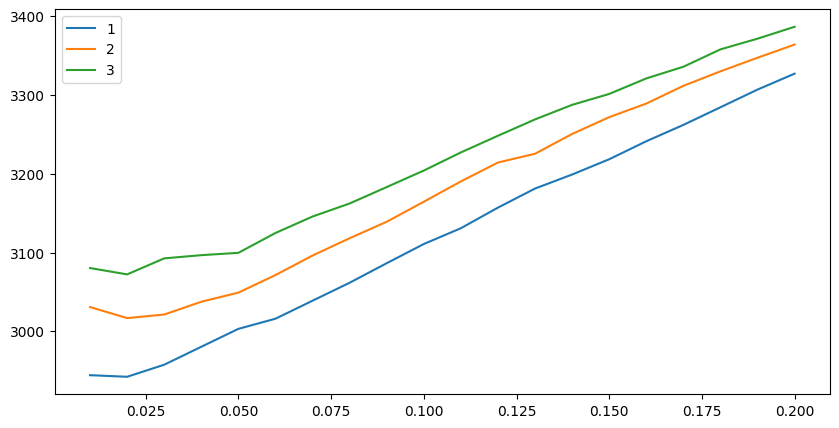

In [6]:
alphas = np.linspace(0.01,0.2, 20)
kappas = [0.01, 0.05, 0.1]
AICs = np.empty((len(kappas), len(alphas)))

for k_cnt, kappa in enumerate(kappas):
    for a_cnt, alpha in enumerate(alphas):
        dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = 50, max_iter = 10000, lamda = alpha, kappa = kappa, tol = 1e-6)
        dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

        thetas = dg_opt1.theta
        liks = log_lik_all(50, thetas, X, 'gaussian')
        nr_params_val = find_nr_params(thetas, 'gaussian')
        AICs[k_cnt, a_cnt] = 2*(np.sum(nr_params_val) - np.sum(liks))


fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(alphas, AICs[0], label = 1)
ax.plot(alphas, AICs[1], label = 2)
ax.plot(alphas, AICs[2], label = 3)
ax.legend()

Frequentist bootstrap

In [17]:
w = 50
thetas_sim = np.zeros((200, d, d))

for i in tqdm.tqdm(range(200)):

    # bootstrap refrence
    Xs = []
    for j in range(3):
        if j == 0:
            Xs.append(X[j*w:((j+1)*w)][np.random.choice(w, w)])
        elif j == 3-1:
            Xs.append(X[(j*w):(j+1)*w][np.random.choice(w, w)])
        else:
            Xs.append(X[(j*w):((j+1)*w)][np.random.choice(w, w)])

    Xs = np.vstack(Xs)

    dg_opt1 = dg.dygl_inner_em(Xs, obs_per_graph = w, max_iter = 10000, lamda = 0.025, kappa = 0.05, tol = 1e-6)
    dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
    dg_opt1.theta[np.abs(dg_opt1.theta)<1e-3] = 0
    thetas_sim[i] = np.abs(np.sign(dg_opt1.theta[0]))


  4%|▍         | 9/200 [00:01<00:41,  4.62it/s]


KeyboardInterrupt: 

Vanilla ABC

In [55]:
# Draw bernoulli
H = 3
N = 200
value_vals_zo = np.zeros((H,N)) 
value_vals_cai = np.zeros((H,N)) 
thetas_sim = np.zeros((N, H, d, d))
B = np.zeros((H,N,nr_params))
for h in range(H):
    B[h] = scipy.stats.bernoulli.rvs(p = 0.5, size = (N,nr_params))  

for i in tqdm.tqdm(range(N)):

    # bootstrap refrence
    Xs = []
    for j in range(3):
        if j == 0:
            Xs.append(X[j*w:((j+1)*w)][np.random.choice(w, w)])
        elif j == 3-1:
            Xs.append(X[(j*w):(j+1)*w][np.random.choice(w, w)])
        else:
            Xs.append(X[(j*w):((j+1)*w)][np.random.choice(w, w)])

    Xs = np.vstack(Xs)

    dg_opt1 = dg.dygl_inner_em(Xs, obs_per_graph = w, max_iter = 10000, lamda = 0.05, kappa = 0.05, tol = 1e-6)
    dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
    dg_opt1.theta[np.abs(dg_opt1.theta)<1e-3] = 0
    thetas_sim[i] = dg_opt1.theta.copy()
    theta_reference =  dg_opt1.theta

    reg_matrix = np.zeros((H,d,d))
    for h in range(H):
        np.fill_diagonal(reg_matrix[h],0)
        reg_matrix[h][np.triu_indices(d,1)] = B[h,i]*999999# 999999*(1-np.abs(np.sign(theta_reference[h][np.triu_indices(d,1)])))#
        reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T

    X_used = Xs.copy()
    # if used == 'xs_x':
    #     X_used = X.copy()
    # elif used == 'xs_xs':
    #     X_used = Xs.copy()
    # else:
    #     raise ValueError("check used argument")
    
    dg_opt2 = dg.dygl_inner_em(X_used, obs_per_graph = w, max_iter = 2000, lamda = reg_matrix, kappa =0.05, tol = 1e-3)
    dg_opt2.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
    dg_opt2.theta[np.abs(dg_opt2.theta)<1e-3] = 0
    particle_graph = dg_opt2.theta
    particle_graph[np.abs(particle_graph)<1e-3] = 0


    
    metric = 'zero-one'
    for h in range(H):
        if metric == 'cai':
            _, value_vals_zo[h] = my_hdtest(Xs[h*w:(h+1)*w], np.linalg.inv(theta_reference[h]),X_used[h*w:(h+1)*w], np.linalg.inv(dg_opt2.theta[h]))
        elif metric == 'zero-one':
            value_vals_zo[h] = -np.sum(np.sign(theta_reference[h][np.triu_indices(d,1)])==np.sign(particle_graph[h][np.triu_indices(d,1)]))
        

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:35<00:00,  5.59it/s]


(array([ 2.,  7., 11., 10., 35., 57., 23., 31., 13., 11.]),
 array([-33. , -31.3, -29.6, -27.9, -26.2, -24.5, -22.8, -21.1, -19.4,
        -17.7, -16. ]),
 <BarContainer object of 10 artists>)

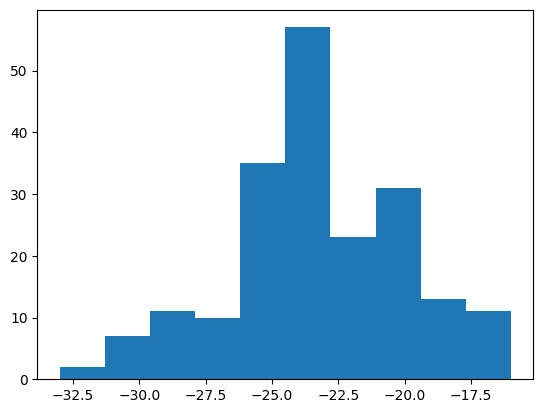

In [54]:
plt.hist(value_vals[0])

In [65]:
np.mean(np.abs(np.sign(thetas_sim[:,0])),axis = 0)

array([[1.   , 1.   , 0.96 , 0.915, 0.535, 0.395, 0.515, 0.8  , 0.565,
        0.965],
       [1.   , 1.   , 0.51 , 1.   , 0.88 , 0.85 , 0.54 , 1.   , 0.835,
        0.24 ],
       [0.96 , 0.51 , 1.   , 0.385, 0.35 , 0.615, 1.   , 0.53 , 0.41 ,
        0.315],
       [0.915, 1.   , 0.385, 1.   , 0.47 , 0.49 , 0.365, 0.96 , 0.665,
        0.975],
       [0.535, 0.88 , 0.35 , 0.47 , 1.   , 0.285, 1.   , 0.37 , 0.53 ,
        0.46 ],
       [0.395, 0.85 , 0.615, 0.49 , 0.285, 1.   , 0.485, 0.695, 0.515,
        0.74 ],
       [0.515, 0.54 , 1.   , 0.365, 1.   , 0.485, 1.   , 0.39 , 0.48 ,
        0.55 ],
       [0.8  , 1.   , 0.53 , 0.96 , 0.37 , 0.695, 0.39 , 1.   , 0.55 ,
        0.38 ],
       [0.565, 0.835, 0.41 , 0.665, 0.53 , 0.515, 0.48 , 0.55 , 1.   ,
        0.425],
       [0.965, 0.24 , 0.315, 0.975, 0.46 , 0.74 , 0.55 , 0.38 , 0.425,
        1.   ]])

In [28]:
w = 50

nr_its = 1
N = 2
H = 3
thetas_sim = np.zeros((N, H, d, d))
p = np.zeros((H, nr_its+1,nr_params))
sigmas = np.zeros((H, nr_its+1, nr_params))

p[:,0] = 0.5

it_nr = 1
value_vals = np.zeros((H, nr_its,N)) 
for it_nr in range(1,nr_its+1):

    # Draw bernoulli
    B = np.zeros((H,N,nr_params))
    for h in range(H):
        B[h] = scipy.stats.bernoulli.rvs(p = p[h,it_nr-1], size = (N,nr_params))  

    for i in tqdm.tqdm(range(N)):

        # bootstrap refrence
        Xs = []
        for j in range(3):
            if j == 0:
                Xs.append(X[j*w:((j+1)*w)][np.random.choice(w, w)])
            elif j == 3-1:
                Xs.append(X[(j*w):(j+1)*w][np.random.choice(w, w)])
            else:
                Xs.append(X[(j*w):((j+1)*w)][np.random.choice(w, w)])

        Xs = np.vstack(Xs)

        dg_opt1 = dg.dygl_inner_em(Xs, obs_per_graph = w, max_iter = 10000, lamda = 0.05, kappa = 0.05, tol = 1e-6)
        dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        dg_opt1.theta[np.abs(dg_opt1.theta)<1e-3] = 0
        thetas_sim[i] = dg_opt1.theta.copy()
        theta_reference =  dg_opt1.theta

        reg_matrix = np.zeros((H,d,d))
        for h in range(H):
            np.fill_diagonal(reg_matrix[h],0)
            reg_matrix[h][np.triu_indices(d,1)] = B[h,i]*999999# 999999*(1-np.abs(np.sign(theta_reference[h][np.triu_indices(d,1)])))#
            reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T

        X_used = Xs.copy()
        # if used == 'xs_x':
        #     X_used = X.copy()
        # elif used == 'xs_xs':
        #     X_used = Xs.copy()
        # else:
        #     raise ValueError("check used argument")
        
        dg_opt2 = dg.dygl_inner_em(X_used, obs_per_graph = w, max_iter = 2000, lamda = reg_matrix, kappa =0.05, tol = 1e-3)
        dg_opt2.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        dg_opt2.theta[np.abs(dg_opt2.theta)<1e-3] = 0
        particle_graph = dg_opt2.theta
        particle_graph[np.abs(particle_graph)<1e-3] = 0
        

        metric = 'zero-one'
        for h in range(H):
            if metric == 'cai':
                _, val1 = my_hdtest(Xs[h*w:(h+1)*w], np.linalg.inv(theta_reference[h]),X_used[h*w:(h+1)*w], np.linalg.inv(dg_opt2.theta[h]))
            elif metric == 'zero-one':
                val1 = -np.sum(np.sign(theta_reference[h][np.triu_indices(d,1)])==np.sign(particle_graph[h][np.triu_indices(d,1)]))
            
            value_vals[h,it_nr-1,i] = val1



    # Get quantile (best value)
    val_func = np.zeros(H)
    for h in range(H):
        value_vals[h,it_nr-1] = -value_vals[h,it_nr-1]
        val_func[h] = np.quantile(value_vals[h,it_nr-1], tail_prob)
            
    # update p
    for h in range(H):
        for i in range(nr_params):
            p[h,it_nr, i] = np.sum((value_vals[h,it_nr-1] >= val_func[h])*B[h,:,i])/np.sum((value_vals[h,it_nr-1] >= val_func[h]))
            sigmas[h,it_nr, i] = np.sqrt(np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*(B[h,~np.isnan(value_vals[h,it_nr-1]),i]-p[h,it_nr-1, i])**2)/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])]>= val_func[h])))

        s = 0.4
        p[h,it_nr] = s*p[h,it_nr] + (1-s)*p[h,it_nr-1]

    print(np.round(p[0,it_nr],2))


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

[0.7 0.3 0.7 0.3 0.7 0.3 0.7 0.7 0.3 0.7 0.7 0.7 0.3 0.7 0.3 0.7 0.7 0.7
 0.7 0.7 0.7 0.3 0.7 0.7 0.3 0.3 0.7 0.3 0.7 0.7 0.3 0.7 0.7 0.7 0.3 0.7
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.7 0.3]


In [211]:
B = np.zeros((H,nr_params))
for h in range(H):
    B[h] = scipy.stats.bernoulli.rvs(p = p[h,0], size = (nr_params,))  
# bootstrap refrence
Xs = []
for j in range(3):
    if j == 0:
        Xs.append(X[j*w:((j+1)*w)][np.random.choice(w, w)])
    elif j == 3-1:
        Xs.append(X[(j*w):(j+1)*w][np.random.choice(w, w)])
    else:
        Xs.append(X[(j*w):((j+1)*w)][np.random.choice(w, w)])

Xs = np.vstack(Xs)

dg_opt1 = dg.dygl_inner_em(Xs, obs_per_graph = w, max_iter = 10000, lamda = 0.025, kappa = 0.05, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
dg_opt1.theta[np.abs(dg_opt1.theta)<1e-3] = 0
thetas_sim[i] = np.abs(np.sign(dg_opt1.theta[0]))
theta_reference =  dg_opt1.theta

reg_matrix = np.zeros((H,d,d))
for h in range(H):
    np.fill_diagonal(reg_matrix[h],0)
    reg_matrix[h][np.triu_indices(d,1)] = 999999*(1-np.abs(np.sign(theta_reference[h][np.triu_indices(d,1)])))#B[h]*999999
    reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T

X_used = Xs.copy()
# if used == 'xs_x':
#     X_used = X.copy()
# elif used == 'xs_xs':
#     X_used = Xs.copy()
# else:
#     raise ValueError("check used argument")

dg_opt2 = dg.dygl_inner_em(X_used, obs_per_graph = w, max_iter = 2000, lamda = reg_matrix, kappa =kappa, tol = 1e-3)
dg_opt2.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
dg_opt2.theta[np.abs(dg_opt2.theta)<1e-3] = 0
particle_graph = dg_opt2.theta
particle_graph[np.abs(particle_graph)<1e-3] = 0


metric = 'zero-one'
for h in range(H):
    if metric == 'cai':
        _, val1 = my_hdtest(Xs[h*w:(h+1)*w], np.linalg.inv(theta_reference[h]),X_used[h*w:(h+1)*w], np.linalg.inv(particle_graph[h]))
    elif metric == 'zero-one':
        val1 = -np.sum(np.sign(theta_reference[h][np.triu_indices(d,1)])==np.sign(particle_graph[h][np.triu_indices(d,1)]))
    value_vals[h,it_nr-1,i] = val1
    print(val1)



-10
-10
-10


In [212]:
print(np.round(theta_reference[0],2))
print(np.round(particle_graph[0],2))

[[ 2.68  0.    0.32  0.    0.2 ]
 [ 0.    1.4  -0.07  0.37 -0.07]
 [ 0.32 -0.07  1.99  0.92 -0.03]
 [ 0.    0.37  0.92  1.6   0.53]
 [ 0.2  -0.07 -0.03  0.53  1.59]]
[[ 2.45  0.    0.12  0.    0.47]
 [ 0.    1.48 -0.05  0.39 -0.05]
 [ 0.12 -0.05  1.92  0.97 -0.05]
 [ 0.    0.39  0.97  1.65  0.49]
 [ 0.47 -0.05 -0.05  0.49  1.66]]


In [191]:
np.abs(np.sign(theta_reference[0][np.triu_indices(d,1)]))

array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.])

In [213]:
reg_matrix[0]

array([[     0., 999999.,      0., 999999.,      0.],
       [999999.,      0.,      0.,      0.,      0.],
       [     0.,      0.,      0.,      0.,      0.],
       [999999.,      0.,      0.,      0.,      0.],
       [     0.,      0.,      0.,      0.,      0.]])

In [195]:
print(np.round(theta_reference[0],2))
print(np.round(particle_graph[0],2))

[[ 1.93 -0.26  0.13 -0.83  0.  ]
 [-0.26  1.12  0.    0.11 -0.05]
 [ 0.13  0.    1.55  0.74  0.34]
 [-0.83  0.11  0.74  1.81  0.55]
 [ 0.   -0.05  0.34  0.55  1.36]]
[[ 1.22  0.    0.    0.    0.  ]
 [ 0.    1.16 -0.09  0.    0.  ]
 [ 0.   -0.09  1.03  0.    0.  ]
 [ 0.    0.    0.    0.88  0.  ]
 [ 0.    0.    0.    0.    1.  ]]


In [196]:
reg_matrix[0]

array([[     0., 999999., 999999., 999999.,      0.],
       [999999.,      0.,      0., 999999., 999999.],
       [999999.,      0.,      0., 999999., 999999.],
       [999999., 999999., 999999.,      0., 999999.],
       [     0., 999999., 999999., 999999.,      0.]])

In [7]:
alpha_in_CE = False
model = 'gaussian'
used = 'xs_xs'
N = 500
ce_it = 5

#print(f'{prefix}_{obs_per_graph}_{metric}_{used}_{alpha_in_CE}' )


p_distribution = np.ones((len(kappas), len(alphas), int(n/obs_per_graph), nr_ce_it+1, nr_params))
sigmas = np.ones((len(kappas), len(alphas), int(n/obs_per_graph)    , nr_ce_it+1, nr_params))
thetas = np.zeros((len(kappas), len(alphas), int(n/obs_per_graph), d,d)) 
thetas_sim = np.zeros((len(kappas), len(alphas),N, int(n/obs_per_graph),d,d)) 

#pool = Pool(12)
#results = pool.starmap(run_sim, tqdm.tqdm((( X, alpha, kappa, obs_per_graph, cnt_a, cnt_k, nr_ce_it, N, alpha_in_CE, tail_prob, metric, used) for cnt_a, alpha in enumerate(alphas) for cnt_k, kappa in enumerate(kappas)), total = len(kappas)*len(alphas)))

# for result in results:
#     p_distribution[result[4], result[5]] = result[0]
#     thetas[result[4], result[5]] = result[1]
#     sigmas[result[4], result[5]]= result[2]
#     thetas_sim[result[4], result[5]]= result[3]


p_distribution, thetas_point, sigmas, thetas_sim, cnt_k, cnt_a = run_sim(X.copy(), 0.025, 0.05, 50, 0, 0, ce_it, N, alpha_in_CE, 0.9, 'zero-one', used)


out_dict = {'alphas':alphas, 'kappas':kappas, 'p_distribution':p_distribution, 'thetas': thetas, 'thetas_sim':thetas_sim, 'X':X, 'As':As, 'N':N, 'nr_ce_it':nr_ce_it,
            'ratio_nr_zeros':ratio_nr_zeros, 'obs_per_graph':obs_per_graph, 'alpha_in_CE':alpha_in_CE, 'model':model, 'sigmas':sigmas,
            'used':used}


graph_sampling_testing = out_dict


100%|██████████| 2500/2500 [08:30<00:00,  4.90it/s]


In [8]:
graph_sampling_testing = out_dict

In [57]:
with open(f'../data/GraphHypTest/single_sim_gaussian_False_cai_xs_xs_ew_0.6.pkl', 'rb') as handle:
    graph_sampling_testing9 = pickle.load(handle)
    graph_sampling_testing9['p_distribution'] = graph_sampling_testing9['p']
    graph_sampling_testing9['alphas'] = [0.05]
    graph_sampling_testing9['kappas'] = [0.05]
    graph_sampling_testing9['As'] = gen_local_change(10,0.3)


with open(f'../data/GraphHypTest/single_sim_gaussian_False_zero-one_xs_xs_ew_0.6.pkl', 'rb') as handle:
    graph_sampling_testing6 = pickle.load(handle)
    graph_sampling_testing6['p_distribution'] = graph_sampling_testing6['p']
    graph_sampling_testing6['alphas'] = [0.05]
    graph_sampling_testing6['kappas'] = [0.05]
    graph_sampling_testing6['As'] = gen_local_change(10,0.3)

with open(f'../data/GraphHypTest/single_sim_gaussian_False_cai_xs_xs_ew_0.3.pkl', 'rb') as handle:
    graph_sampling_testing3 = pickle.load(handle)
    graph_sampling_testing3['p_distribution'] = graph_sampling_testing3['p']
    graph_sampling_testing3['alphas'] = [0.05]
    graph_sampling_testing3['kappas'] = [0.05]
    graph_sampling_testing3['As'] = gen_local_change(10,0.3)



# with open(f'../data/GraphHypTest/single_sim_gaussian_False_zero-one_xs_xs_ew_0.1.pkl', 'rb') as handle:
#     graph_sampling_testing1 = pickle.load(handle)
#     graph_sampling_testing1['p_distribution'] = graph_sampling_testing1['p']
#     graph_sampling_testing1['alphas'] = [0.05]
#     graph_sampling_testing1['kappas'] = [0.05]
#     graph_sampling_testing1['As'] = gen_local_change(10,0.3)



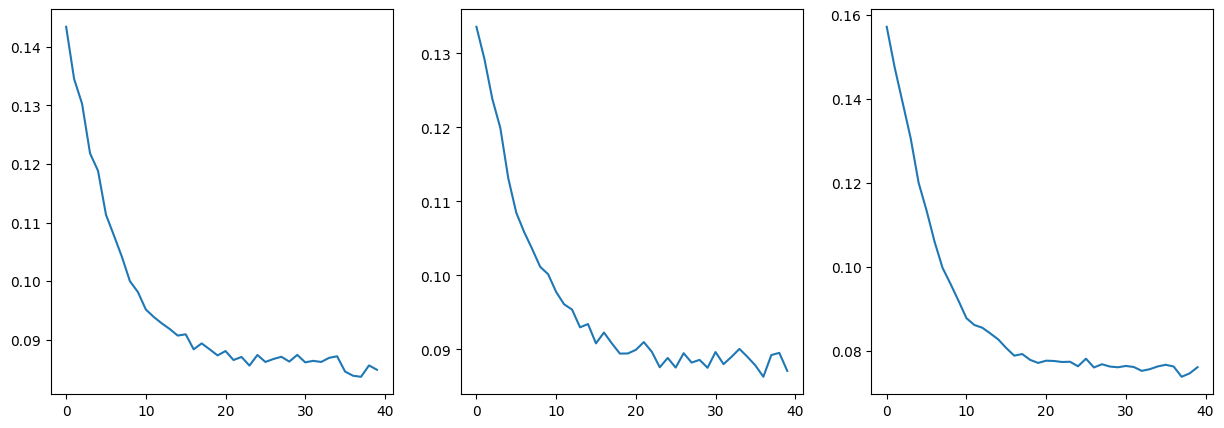

In [47]:
means = np.mean(graph_sampling_testing9['value_vals'], axis = 2)
stds = np.std(graph_sampling_testing9['value_vals'], axis = 2)

coefvar = stds/means

fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(range(coefvar.shape[1]), coefvar[0])
ax[1].plot(range(coefvar.shape[1]), coefvar[1])
ax[2].plot(range(coefvar.shape[1]), coefvar[2])



In [44]:
np.exp(-np.linspace(5, -1.3,40))

array([0.00673795, 0.00791923, 0.00930761, 0.0109394 , 0.01285727,
       0.01511137, 0.01776066, 0.02087442, 0.02453408, 0.02883533,
       0.03389067, 0.03983231, 0.04681562, 0.05502322, 0.06466976,
       0.07600751, 0.08933297, 0.10499462, 0.12340203, 0.14503659,
       0.17046406, 0.20034943, 0.23547422, 0.27675701, 0.3252774 ,
       0.38230427, 0.44932896, 0.52810427, 0.62069027, 0.72950824,
       0.85740392, 1.00772197, 1.18439343, 1.39203852, 1.63608745,
       1.92292248, 2.26004475, 2.65627051, 3.12196165, 3.66929667])

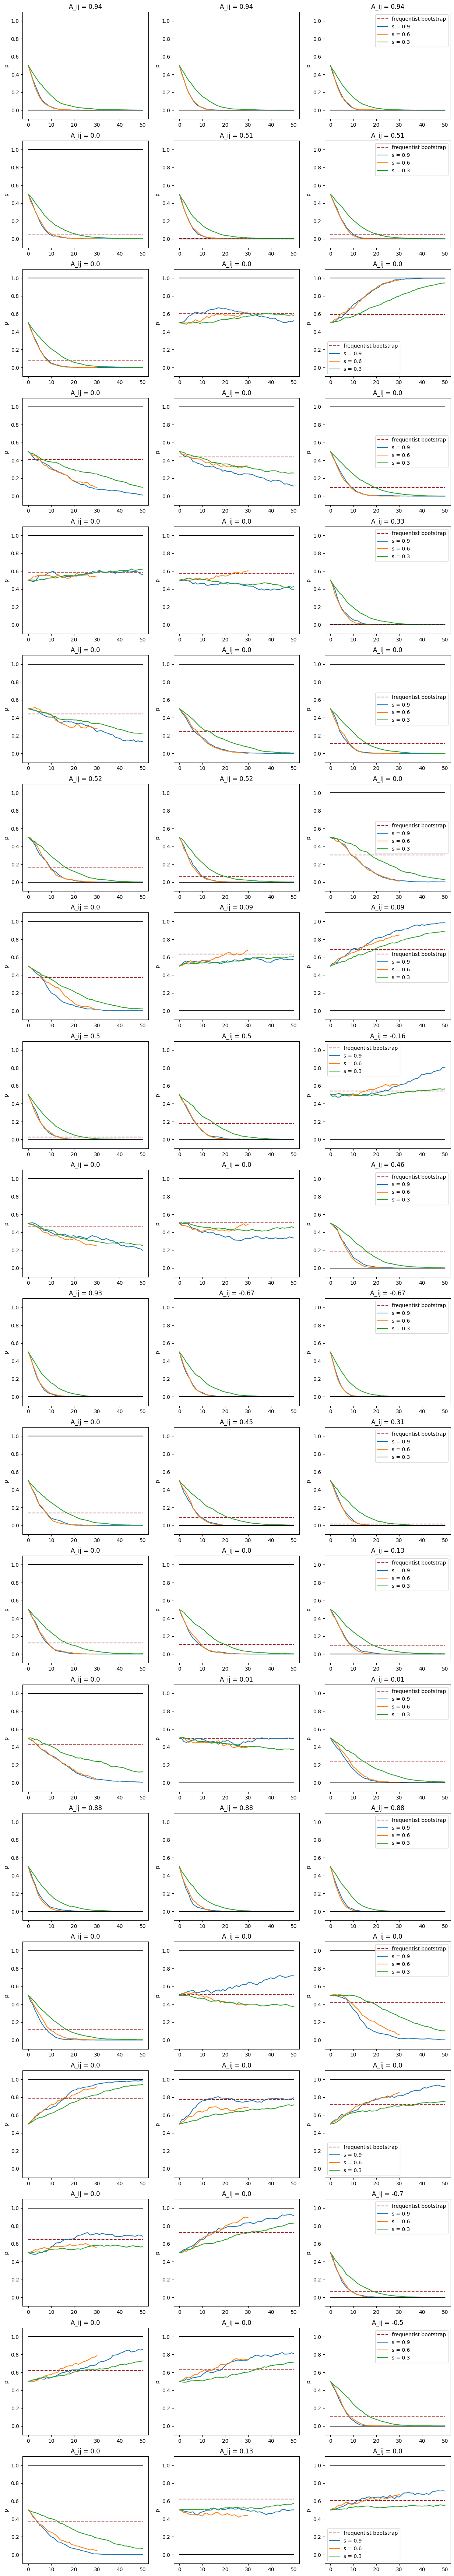

In [58]:
# For binomial
fig, ax = plt.subplots(20,3, figsize = (15,90))
for i in range(20):
    for h in range(3):
        freq_boot = np.mean(np.abs(np.sign(graph_sampling_testing9['thetas_sim'][:,h])), axis = 0)[np.triu_indices(d,1)]
        lll = graph_sampling_testing9['p_distribution'].shape[1]
        ax[i,h].plot(range(lll), [1-freq_boot[i]]*lll, label = f'frequentist bootstrap', color = 'brown', linestyle = '--')
    for h in range(3):
        for k in [0]:
            for a in range(1):
                freq_boot9 = np.mean(np.abs(np.sign(graph_sampling_testing9['thetas_sim'][:,0])), axis = 0)[np.triu_indices(d,1)]
                ax[i,h].plot(range(graph_sampling_testing9['p_distribution'].shape[1]), graph_sampling_testing9['p_distribution'][h,:,i], label = f's = 0.9')
                
                ax[i,h].plot(range(graph_sampling_testing6['p_distribution'].shape[1]), graph_sampling_testing6['p_distribution'][h,:,i], label = f's = 0.6')
                ax[i,h].plot(range(graph_sampling_testing3['p_distribution'].shape[1]), graph_sampling_testing3['p_distribution'][h,:,i], label = f's = 0.3')
                # ax[i,h].plot(range(graph_sampling_testing1['p_distribution'].shape[1]), graph_sampling_testing1['p_distribution'][h,:,i], label = f's = 0.1')
                #A_est = graph_sampling_testing['thetas'][h,j,k][np.triu_indices(20,1)]
                #A_est[np.abs(A_est)<1e-3] = 0
                #ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]),[1-np.abs(np.sign(A_est[i]))]*61, color = 'orange')
        A_true = graph_sampling_testing9['As'][h][np.triu_indices(10,1)]
        ax[i,h].plot(range(graph_sampling_testing9['p_distribution'].shape[1]),[1-np.abs(np.sign(A_true[i]))]*graph_sampling_testing9['p_distribution'].shape[1], color = 'black')
        #ax[i,h].set_xlabel('Iteration')
        ax[i,h].set_ylabel('p')
        ax[i,h].set_ylim((-0.1,1.1))
        ax[i,h].set_title(f"A_ij = {np.round(graph_sampling_testing9['As'][h][np.triu_indices(10,1)][i],2)}")
    ax[i,2].legend()


# OLD

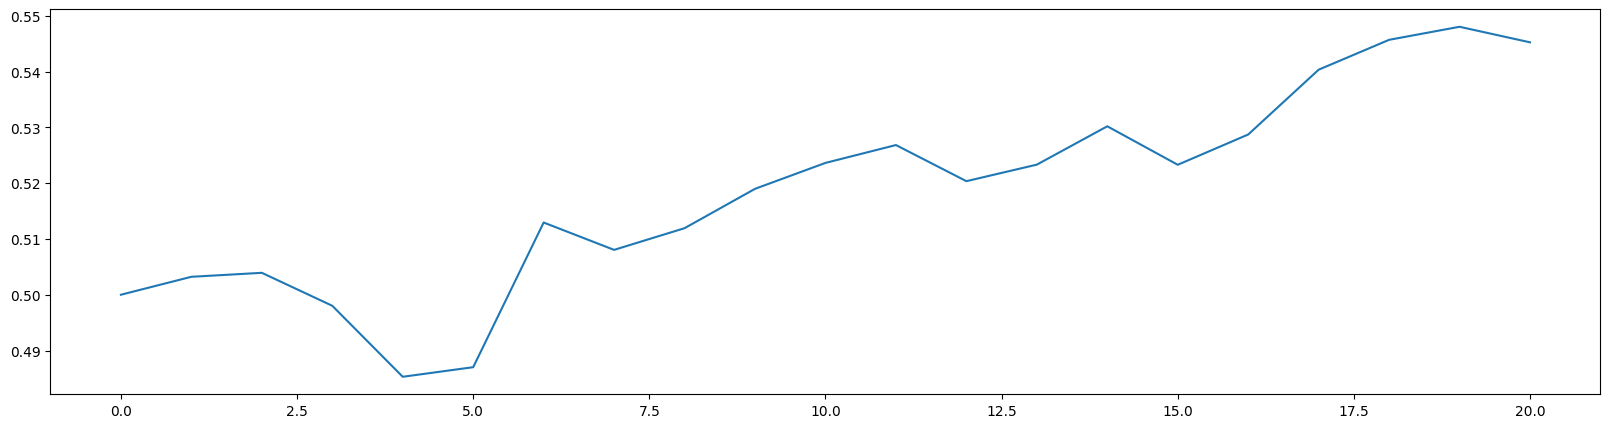

In [19]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(p[0,:,1])

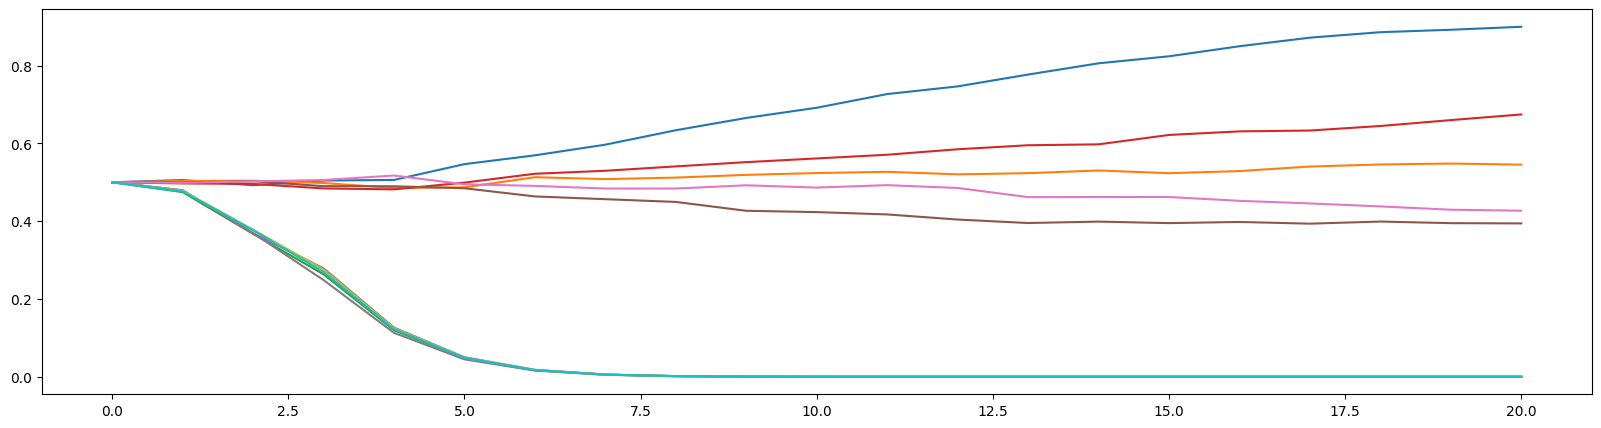

In [20]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(p[0,:,:])


Cai no boostrap test case 2

In [21]:
# A1 = np.array([[ 1.12925027,  0.        , -0.35951394,  0.30753538,  0.        ],
#                 [ 0.        ,  1.        ,  0.2        ,  0.        ,  0.        ],
#                 [-0.35951394,  0.2        ,  1.46401636, -0.61734779, -0.68118747],
#                 [ 0.30753538,  0.        , -0.61734779,  1.85389052, -0.34949575],
#                 [ 0.        ,  0.        , -0.68118747, -0.34949575,  1.        ]])

# A2 = A1.copy()

# A2[0,2] = 0
# A2[2,0] = 0
# nr_its = 30
# N = 3000
# alpha_in_CE = False
# d = A1.shape[0]
# nr_params = int(d*(d-1)/2)
# alpha = 0.05
# tail_prob = 0.8

# X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(A1), size = 50)
# X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(A2), size = 50)

# X = np.vstack([X1,X2])

obs_per_graph = 50
dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = obs_per_graph, max_iter = 10000, lamda = alpha, kappa =0.001, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
theta_reference = dg_opt1.theta
theta_reference[np.abs(theta_reference)<1e-2] = 0


assert theta_reference[1,0,2] == 0
assert theta_reference[0,0,2] != 0



H = 1
p = np.zeros((H,nr_its+1, nr_params))
eigvals = np.zeros((H,nr_its,N, d))
sigmas = np.zeros((H,nr_its+1, nr_params))

value_vals = np.zeros((H,nr_its, N))

#pbar = tqdm.tqdm(total = nr_its*N,position=0)



p[:,0] = 0.5
for it_nr in range(1,nr_its+1):
    #print(it_nr)
    # print(it_nr)


    # Draw bernoulli
    B = np.zeros((1,N,nr_params))
    B[0] = scipy.stats.bernoulli.rvs(p = p[0,it_nr-1], size = (N,nr_params))   


    for i in range(N):

        
        if alpha_in_CE:
            reg_matrix = np.ones((H,d,d))*alpha
        else:
            reg_matrix = np.zeros((H,d,d))
        for h in range(1):
            np.fill_diagonal(reg_matrix[h],0)
            reg_matrix[h][np.triu_indices(d,1)] = B[h,i]*999999
            reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T


        gls1 = dg.sgl_inner_em(X[:obs_per_graph], max_iter = 10000, lamda = reg_matrix[0], tol = 1e-6)
        gls1.fit(nr_workers=1, lik_type="gaussian",verbose=False)

        gls2 = dg.sgl_inner_em(X[obs_per_graph:], max_iter = 10000, lamda = reg_matrix[0], tol = 1e-6)
        gls2.fit(nr_workers=1, lik_type="gaussian",verbose=False)

        theta1 = gls1.theta[-1].copy()
        theta1[np.abs(theta1)<1e-5] = 0
        theta2 = gls2.theta[-1].copy()
        theta2[np.abs(theta2)<1e-5] = 0
        val_func = np.zeros(H)
        for h in range(1):
            _, val1 = my_hdtest(X[:obs_per_graph], np.linalg.inv(theta_reference[0]),X[:obs_per_graph], np.linalg.inv(theta1))
            _, val2 = my_hdtest(X[obs_per_graph:], np.linalg.inv(theta_reference[1]),X[obs_per_graph:], np.linalg.inv(theta2))
            value_vals[h,it_nr-1,i] = val1+val2
        # pbar.update()

    # Get quantile (best value)
    for h in range(1):
        value_vals[h,it_nr-1] = -value_vals[h,it_nr-1]
        val_func[h] = np.quantile(value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])], tail_prob)
    
    # update p
    for h in range(1):
        for i in range(nr_params):
            p[h,it_nr, i] = np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*B[h,~np.isnan(value_vals[h,it_nr-1]),i])/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h]))
            sigmas[h,it_nr, i] = np.sqrt(np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*(B[h,~np.isnan(value_vals[h,it_nr-1]),i]-p[h,it_nr-1, i])**2)/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])]>= val_func[h])))

        w = np.exp(-2/it_nr)*0.9
        p[h,it_nr] = w*p[h,it_nr] + (1-w)*p[h,it_nr-1]
    
    print(p[0,it_nr,1])

#pbar.close()   


0.4943159181040623
0.4782935870017374
0.4115656057715114
0.24022364340959518
0.09529959207134323
0.03384296462771887
0.010953967124446122
0.0032761047676147636
0.0009151351066418666
0.00024081077711577144
6.0111757803967703e-05
1.431660381506923e-05
3.2690028169723155e-06
7.185591503433661e-07
1.5258173346215051e-07
3.139411700794797e-08
6.275408071311166e-09
1.2214743871740469e-09
2.319838036625681e-10
4.3066940323588924e-11


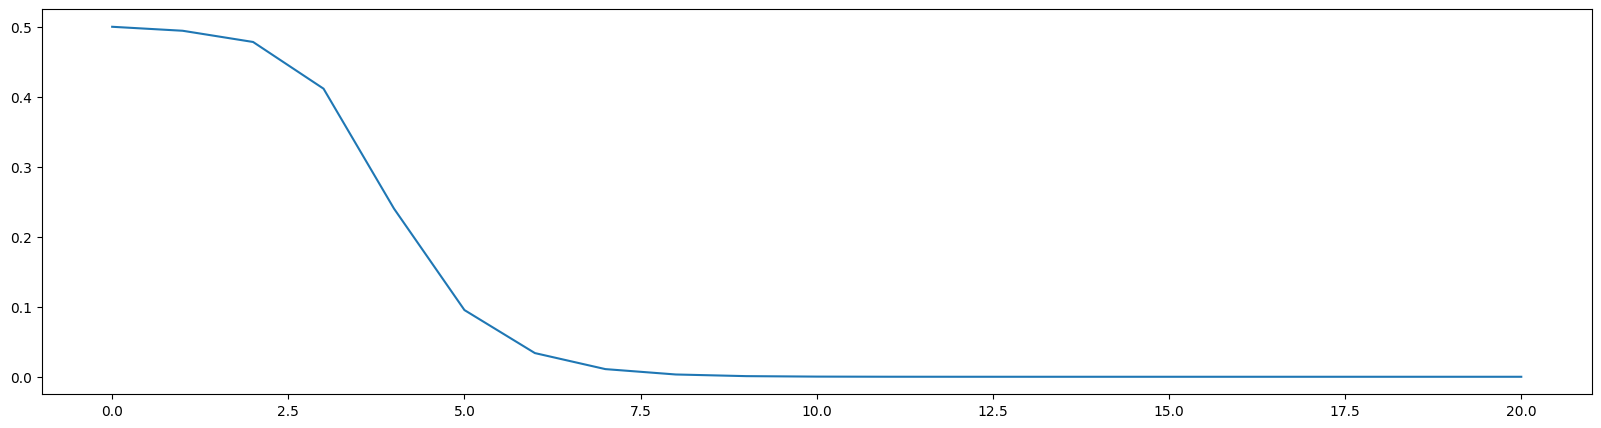

In [23]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(p[0,:,1])

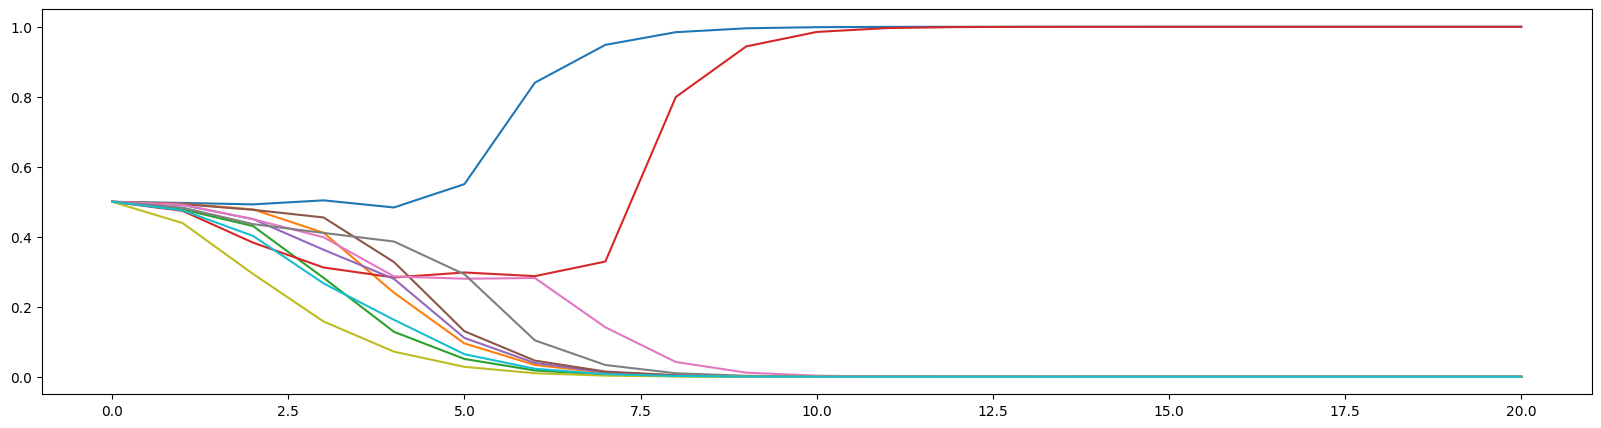

In [24]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(p[0,:,:])

Bootstrap one zero

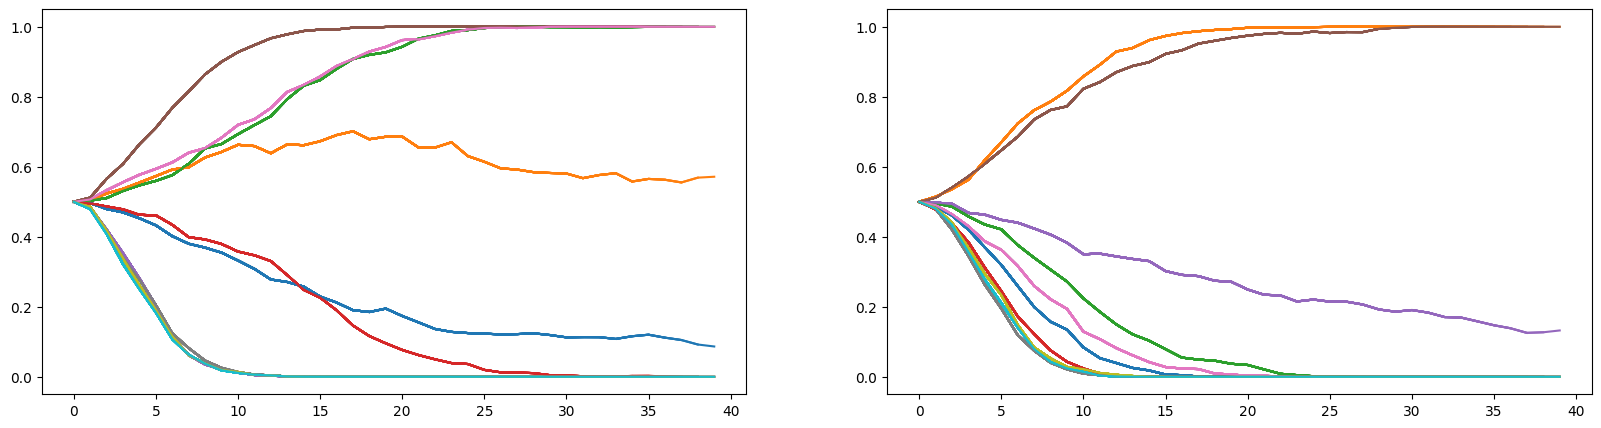

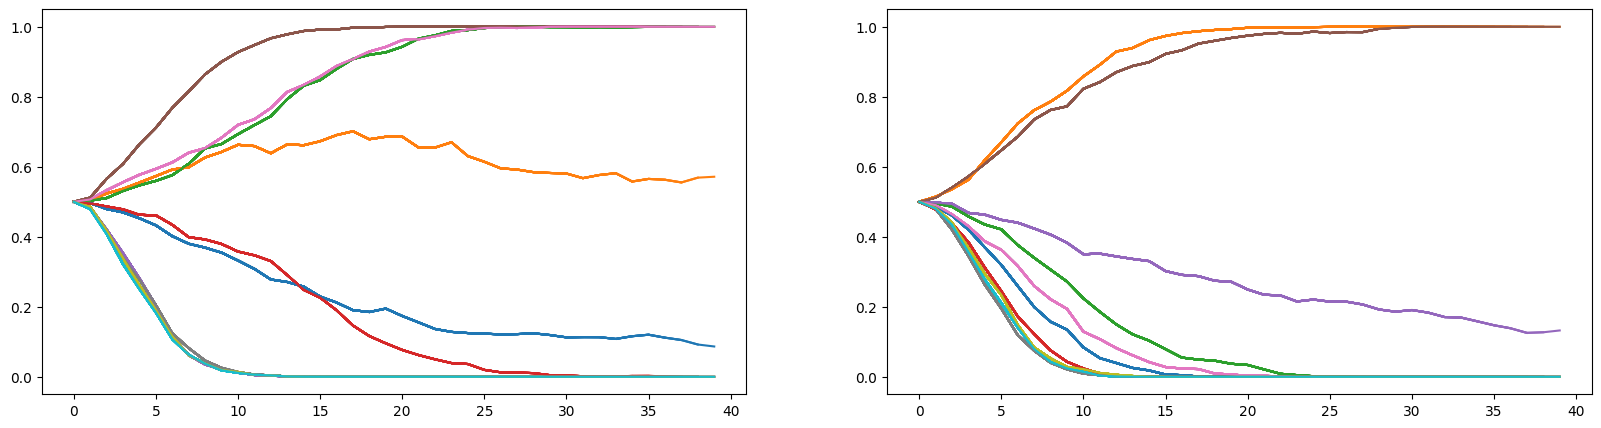

In [41]:
from IPython import display
import time

A1 = np.array([[ 1.12925027,  0.        , -0.35951394,  0.30753538,  0.        ],
                [ 0.        ,  1.        ,  0.2        ,  0.        ,  0.        ],
                [-0.35951394,  0.2        ,  1.46401636, -0.61734779, -0.68118747],
                [ 0.30753538,  0.        , -0.61734779,  1.85389052, -0.34949575],
                [ 0.        ,  0.        , -0.68118747, -0.34949575,  1.        ]])

A2 = A1.copy()

A2[0,2] = 0
A2[2,0] = 0
nr_its = 40
N = 3000
alpha_in_CE = False
d = A1.shape[0]
nr_params = int(d*(d-1)/2)
alpha = 0.1
tail_prob = 0.8
kappa = 0.05

X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(A1), size = 70)
X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(A2), size = 30)

X = np.vstack([X1,X2])

obs_per_graph = 50
dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = obs_per_graph, max_iter = 10000, lamda = alpha, kappa =kappa, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
theta_reference = dg_opt1.theta
theta_reference[np.abs(theta_reference)<1e-2] = 0


assert theta_reference[1,0,2] == 0
assert theta_reference[0,0,2] != 0



H = 2
p = np.zeros((H,nr_its+1, nr_params))
eigvals = np.zeros((H,nr_its,N, d))
sigmas = np.zeros((H,nr_its+1, nr_params))

value_vals = np.zeros((H,nr_its, N))

#pbar = tqdm.tqdm(total = nr_its*N,position=0)

fig, ax = plt.subplots(1,2, figsize = (20,5))

p[:,0] = 0.5
for it_nr in range(1,nr_its+1):
    #print(it_nr)
    # print(it_nr)

    # Draw bernoulli
    B = np.zeros((H,N,nr_params))
    for h in range(H):
        B[h] = scipy.stats.bernoulli.rvs(p = p[h,it_nr-1], size = (N,nr_params))  


    for i in range(N):


        # bootstrap refrence
        Xs = []
        for j in range(2):
            Xs.append(X[j*obs_per_graph:((j+1)*obs_per_graph)][np.random.choice(obs_per_graph, obs_per_graph)])
        
        Xs = np.vstack(Xs)

        dg_opt1 = dg.dygl_inner_em(Xs, obs_per_graph = obs_per_graph, max_iter = 1000, lamda = alpha, kappa =kappa, tol = 1e-4)
        dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        theta_reference = dg_opt1.theta
        theta_reference[np.abs(theta_reference)<1e-5] = 0 


    
        if alpha_in_CE:
            reg_matrix = np.ones((H,d,d))*alpha
        else:
            reg_matrix = np.zeros((H,d,d))
        for h in range(H):
            np.fill_diagonal(reg_matrix[h],0)
            reg_matrix[h][np.triu_indices(d,1)] = B[h,i]*999999
            reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T


            
        dg_opt2 = dg.dygl_inner_em(Xs, obs_per_graph = obs_per_graph, max_iter = 1000, lamda = reg_matrix, kappa =0.05, tol = 1e-4)
        dg_opt2.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        dg_opt2.theta[np.abs(dg_opt2.theta)<1e-5] = 0

        val_func = np.zeros(H)
        for h in range(2):
            #_, val1 = my_hdtest(X[h*obs_per_graph:(h+1)*obs_per_graph], np.linalg.inv(theta_reference[h]),X[h*obs_per_graph:(h+1)*obs_per_graph], np.linalg.inv(dg_opt2.theta[h]))
            val1 = -np.sum(np.sign(theta_reference[h][np.triu_indices(d,1)])==np.sign(dg_opt2.theta[h][np.triu_indices(d,1)]))
            #val1 = np.linalg.norm(theta_reference[0]-theta1)
            value_vals[h,it_nr-1,i] = val1
             #_, value_vals[h,it_nr-1,i] = my_hdtest(np.vstack((X1,X2)), np.linalg.inv(0.5*(theta_reference[0]+theta_reference[1])),np.vstack((X1,X2)), np.linalg.inv(0.5*(theta1+theta2)))
            #value_vals[h,it_nr-1,i] = np.linalg.norm(theta_reference[0]+theta_reference[1] - theta1 - theta2)
        # pbar.update()

    # Get quantile (best value)
    for h in range(H):
        value_vals[h,it_nr-1] = -value_vals[h,it_nr-1]
        val_func[h] = np.quantile(value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])], tail_prob)
    
    # update p
    for h in range(H):
        for i in range(nr_params):
            p[h,it_nr, i] = np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*B[h,~np.isnan(value_vals[h,it_nr-1]),i])/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h]))
            sigmas[h,it_nr, i] = np.sqrt(np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*(B[h,~np.isnan(value_vals[h,it_nr-1]),i]-p[h,it_nr-1, i])**2)/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])]>= val_func[h])))

        w = np.exp(-2/it_nr)*0.9
        p[h,it_nr] = w*p[h,it_nr] + (1-w)*p[h,it_nr-1]
    
    #print(it_nr)
    ax[0].plot(p[0,:it_nr,:])
    ax[1].plot(p[1,:it_nr,:])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)
#pbar.close()   


Bootstrap Cai

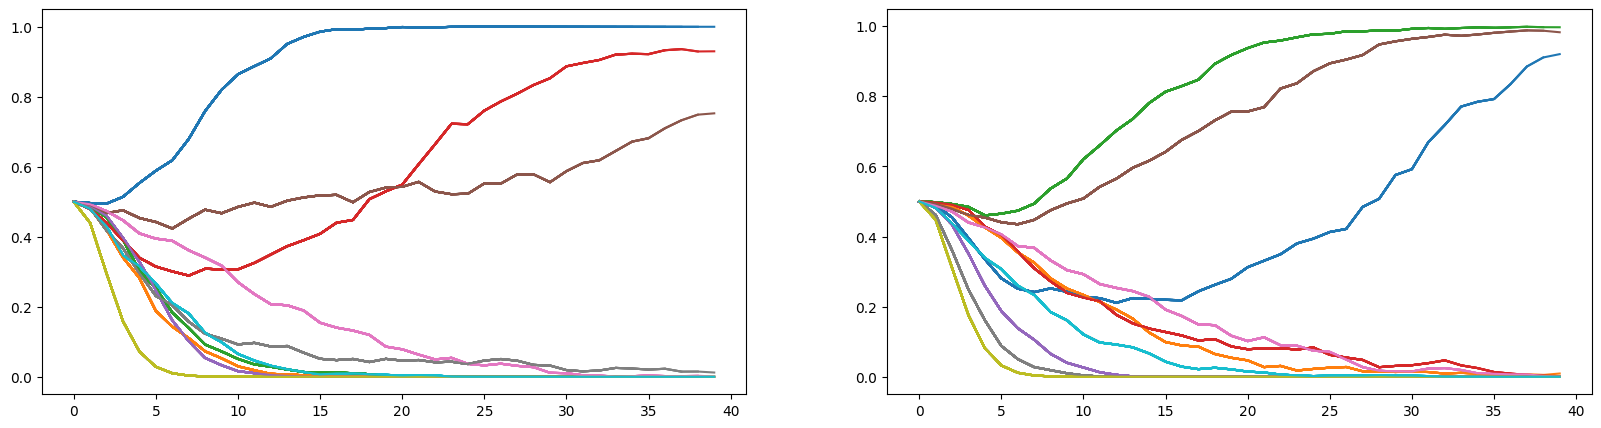

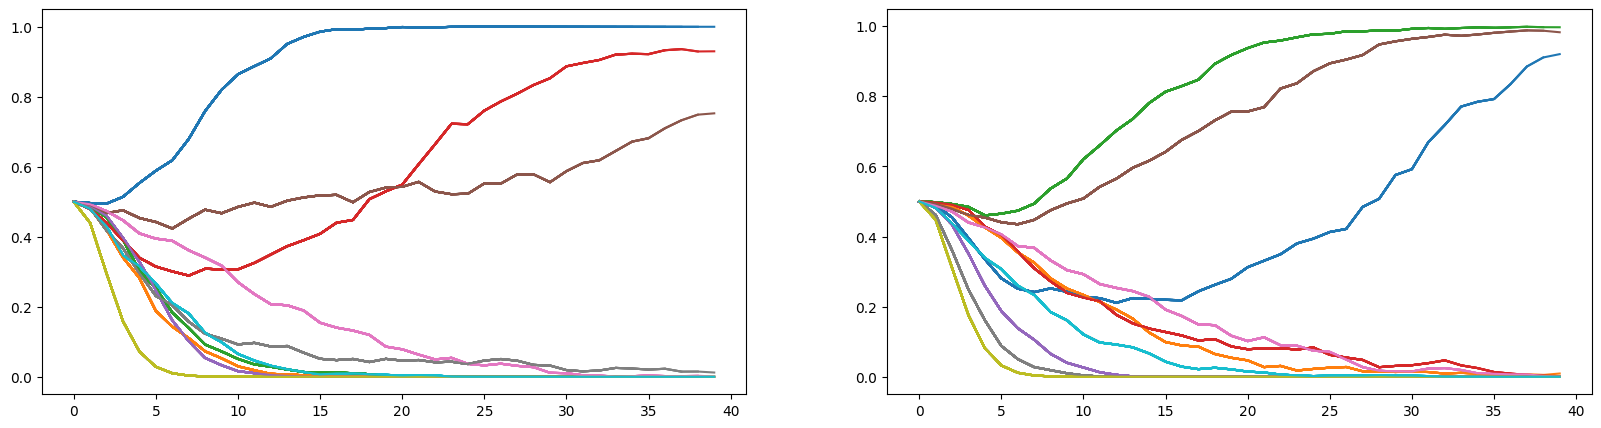

In [47]:
from IPython import display
import time

A1 = np.array([[ 1.12925027,  0.        , -0.35951394,  0.30753538,  0.        ],
                [ 0.        ,  1.        ,  0.2        ,  0.        ,  0.        ],
                [-0.35951394,  0.2        ,  1.46401636, -0.61734779, -0.68118747],
                [ 0.30753538,  0.        , -0.61734779,  1.85389052, -0.34949575],
                [ 0.        ,  0.        , -0.68118747, -0.34949575,  1.        ]])

A2 = A1.copy()

A2[0,2] = 0
A2[2,0] = 0
nr_its = 40
N = 3000
alpha_in_CE = False
d = A1.shape[0]
nr_params = int(d*(d-1)/2)
alpha = 0.1
tail_prob = 0.8
kappa = 0.05

X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(A1), size = 70)
X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(A2), size = 30)

X = np.vstack([X1,X2])

obs_per_graph = 50
dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = obs_per_graph, max_iter = 10000, lamda = alpha, kappa =kappa, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
theta_reference = dg_opt1.theta
theta_reference[np.abs(theta_reference)<1e-2] = 0


assert theta_reference[1,0,2] == 0
assert theta_reference[0,0,2] != 0



H = 2
p = np.zeros((H,nr_its+1, nr_params))
eigvals = np.zeros((H,nr_its,N, d))
sigmas = np.zeros((H,nr_its+1, nr_params))

value_vals = np.zeros((H,nr_its, N))

#pbar = tqdm.tqdm(total = nr_its*N,position=0)

fig, ax = plt.subplots(1,2, figsize = (20,5))

p[:,0] = 0.5
for it_nr in range(1,nr_its+1):
    #print(it_nr)
    # print(it_nr)

    # Draw bernoulli
    B = np.zeros((H,N,nr_params))
    for h in range(H):
        B[h] = scipy.stats.bernoulli.rvs(p = p[h,it_nr-1], size = (N,nr_params))  


    for i in range(N):


        # bootstrap refrence
        Xs = []
        for j in range(2):
            Xs.append(X[j*obs_per_graph:((j+1)*obs_per_graph)][np.random.choice(obs_per_graph, obs_per_graph)])
        
        Xs = np.vstack(Xs)

        dg_opt1 = dg.dygl_inner_em(Xs, obs_per_graph = obs_per_graph, max_iter = 1000, lamda = alpha, kappa =kappa, tol = 1e-4)
        dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        theta_reference = dg_opt1.theta
        theta_reference[np.abs(theta_reference)<1e-5] = 0 


    
        if alpha_in_CE:
            reg_matrix = np.ones((H,d,d))*alpha
        else:
            reg_matrix = np.zeros((H,d,d))
        for h in range(H):
            np.fill_diagonal(reg_matrix[h],0)
            reg_matrix[h][np.triu_indices(d,1)] = B[h,i]*999999
            reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T


            
        dg_opt2 = dg.dygl_inner_em(Xs, obs_per_graph = obs_per_graph, max_iter = 1000, lamda = reg_matrix, kappa =0.05, tol = 1e-4)
        dg_opt2.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        dg_opt2.theta[np.abs(dg_opt2.theta)<1e-5] = 0

        val_func = np.zeros(H)
        for h in range(2):
            _, val1 = my_hdtest(Xs[h*obs_per_graph:(h+1)*obs_per_graph], np.linalg.inv(theta_reference[h]),Xs[h*obs_per_graph:(h+1)*obs_per_graph], np.linalg.inv(dg_opt2.theta[h]))
            #val1 = -np.sum(np.sign(theta_reference[h][np.triu_indices(d,1)])==np.sign(dg_opt2.theta[h][np.triu_indices(d,1)]))
            #val1 = np.linalg.norm(theta_reference[0]-theta1)
            value_vals[h,it_nr-1,i] = val1
             #_, value_vals[h,it_nr-1,i] = my_hdtest(np.vstack((X1,X2)), np.linalg.inv(0.5*(theta_reference[0]+theta_reference[1])),np.vstack((X1,X2)), np.linalg.inv(0.5*(theta1+theta2)))
            #value_vals[h,it_nr-1,i] = np.linalg.norm(theta_reference[0]+theta_reference[1] - theta1 - theta2)
        # pbar.update()

    # Get quantile (best value)
    for h in range(H):
        value_vals[h,it_nr-1] = -value_vals[h,it_nr-1]
        val_func[h] = np.quantile(value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])], tail_prob)
    
    # update p
    for h in range(H):
        for i in range(nr_params):
            p[h,it_nr, i] = np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*B[h,~np.isnan(value_vals[h,it_nr-1]),i])/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h]))
            sigmas[h,it_nr, i] = np.sqrt(np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*(B[h,~np.isnan(value_vals[h,it_nr-1]),i]-p[h,it_nr-1, i])**2)/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])]>= val_func[h])))

        w = np.exp(-2/it_nr)*0.9
        p[h,it_nr] = w*p[h,it_nr] + (1-w)*p[h,it_nr-1]
    
    #print(it_nr)
    ax[0].plot(p[0,:it_nr,:])
    ax[1].plot(p[1,:it_nr,:])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)
#pbar.close()   


In [218]:
A1 = np.array([[ 1.12925027,  0.        , -0.35951394,  0.30753538,  0.        ],
                [ 0.        ,  1.        ,  0.2        ,  0.        ,  0.        ],
                [-0.35951394,  0.2        ,  1.46401636, -0.61734779, -0.68118747],
                [ 0.30753538,  0.        , -0.61734779,  1.85389052, -0.34949575],
                [ 0.        ,  0.        , -0.68118747, -0.34949575,  1.        ]])

A2 = A1.copy()

A2[0,2] = 0
A2[2,0] = 0
nr_its = 50
N = 1000
alpha_in_CE = False
d = A1.shape[0]
nr_params = int(d*(d-1)/2)
alpha = 0.05
tail_prob = 0.8


X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(A1), size = 250)
X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(A2), size = 350)

X = np.vstack([X1,X2])

obs_per_graph = 300
dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = obs_per_graph, max_iter = 10000, lamda = alpha, kappa =0.001, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
theta_reference = dg_opt1.theta
theta_reference[np.abs(theta_reference)<1e-2] = 0


assert theta_reference[1,0,2] == 0



H = 2
p = np.zeros((H,nr_its+1, nr_params))
eigvals = np.zeros((H,nr_its,N, d))
sigmas = np.zeros((H,nr_its+1, nr_params))

value_vals = np.zeros((H,nr_its, N))

#pbar = tqdm.tqdm(total = nr_its*N,position=0)



p[:,0] = 0.5
for it_nr in range(1,nr_its+1):
    #print(it_nr)
    # print(it_nr)

    # bootstrap refrence
    Xs = []
    for j in range(2):
        if j == 0:
            Xs.append(X[j*obs_per_graph:((j+1)*obs_per_graph + 50)][np.random.choice(obs_per_graph+50, obs_per_graph)])
        elif j == 1:
            Xs.append(X[(j*obs_per_graph-50):(j+1)*obs_per_graph][np.random.choice(obs_per_graph+50, obs_per_graph)])

    
    Xs = np.vstack(Xs)


    dg_opt1 = dg.dygl_inner_em(Xs, obs_per_graph = obs_per_graph, max_iter = 10000, lamda = alpha, kappa =0.05, tol = 1e-6)
    dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
    theta_reference = dg_opt1.theta
    theta_reference[np.abs(theta_reference)<1e-5] = 0

    # Draw bernoulli
    B = np.zeros((H,N,nr_params))
    for h in range(H):
        B[h] = scipy.stats.bernoulli.rvs(p = p[h,it_nr-1], size = (N,nr_params))   


    for i in range(N):
    
        if alpha_in_CE:
            reg_matrix = np.ones((H,d,d))*alpha
        else:
            reg_matrix = np.zeros((H,d,d))
        for h in range(H):
            np.fill_diagonal(reg_matrix[h],0)
            reg_matrix[h][np.triu_indices(d,1)] = B[h,i]*999999
            reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T


            
        dg_opt2 = dg.dygl_inner_em(X, obs_per_graph = obs_per_graph, max_iter = 10000, lamda = reg_matrix, kappa =0.05, tol = 1e-6)
        dg_opt2.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        dg_opt2.theta[np.abs(dg_opt2.theta)<1e-5] = 0

        val_func = np.zeros(H)
        for h in range(2):
            #_, val1 = my_hdtest(X[h*obs_per_graph:(h+1)*obs_per_graph], np.linalg.inv(theta_reference[h]),X[h*obs_per_graph:(h+1)*obs_per_graph], np.linalg.inv(dg_opt2.theta[h]))
            val1 = -np.sum(np.sign(theta_reference[h][np.triu_indices(d,1)])==np.sign(dg_opt2.theta[h][np.triu_indices(d,1)]))
            #val1 = np.linalg.norm(theta_reference[0]-theta1)
            value_vals[h,it_nr-1,i] = val1
             #_, value_vals[h,it_nr-1,i] = my_hdtest(np.vstack((X1,X2)), np.linalg.inv(0.5*(theta_reference[0]+theta_reference[1])),np.vstack((X1,X2)), np.linalg.inv(0.5*(theta1+theta2)))
            #value_vals[h,it_nr-1,i] = np.linalg.norm(theta_reference[0]+theta_reference[1] - theta1 - theta2)
        # pbar.update()

    # Get quantile (best value)
    for h in range(H):
        value_vals[h,it_nr-1] = -value_vals[h,it_nr-1]
        val_func[h] = np.quantile(value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])], tail_prob)
    
    # update p
    for h in range(H):
        for i in range(nr_params):
            p[h,it_nr, i] = np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*B[h,~np.isnan(value_vals[h,it_nr-1]),i])/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h]))
            sigmas[h,it_nr, i] = np.sqrt(np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*(B[h,~np.isnan(value_vals[h,it_nr-1]),i]-p[h,it_nr-1, i])**2)/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])]>= val_func[h])))

        w = np.exp(-2/it_nr)*0.9
        p[h,it_nr] = w*p[h,it_nr] + (1-w)*p[h,it_nr-1]
    
    print(it_nr)
#pbar.close()   


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


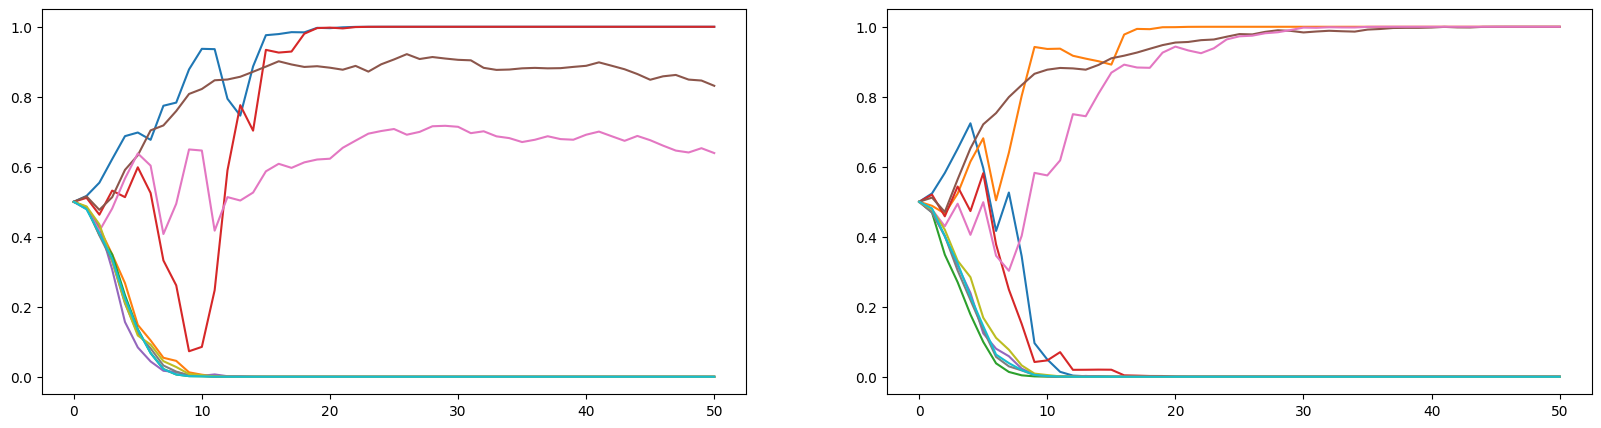

In [219]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].plot(p[0,:,:])
ax[1].plot(p[1,:,:])

In [83]:
if alpha_in_CE:
    reg_matrix = np.ones((H,d,d))*alpha
else:
    reg_matrix = np.zeros((H,d,d))
for h in range(1):
    np.fill_diagonal(reg_matrix[h],0)
    reg_matrix[h][np.triu_indices(d,1)] = B[h,i]*999999
    reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T


gls1 = dg.sgl_inner_em(X1, max_iter = 10000, lamda = reg_matrix[0], tol = 1e-6)
gls1.fit(nr_workers=1, lik_type="gaussian",verbose=False)

gls2 = dg.sgl_inner_em(X2, max_iter = 10000, lamda = reg_matrix[0], tol = 1e-6)
gls2.fit(nr_workers=1, lik_type="gaussian",verbose=False)

theta1 = gls1.theta[-1].copy()
theta1[np.abs(theta1)<1e-2] = 0
theta2 = gls2.theta[-1].copy()
theta2[np.abs(theta2)<1e-2] = 0

In [102]:
A2

array([[ 1.12925027,  0.        ,  0.        ,  0.30753538,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.46401636, -0.61734779, -0.68118747],
       [ 0.30753538,  0.        , -0.61734779,  1.85389052, -0.34949575],
       [ 0.        ,  0.        , -0.68118747, -0.34949575,  1.        ]])

In [7]:
theta_reference[1]

array([[ 1.16218141, -0.07743371,  0.02823972,  0.19666853,  0.02064291],
       [-0.07743371,  0.9426613 ,  0.        ,  0.        , -0.03705912],
       [ 0.02823972,  0.        ,  1.46798489, -0.58279549, -0.68189899],
       [ 0.19666853,  0.        , -0.58279549,  1.73727871, -0.24792508],
       [ 0.02064291, -0.03705912, -0.68189899, -0.24792508,  0.90301702]])

In [78]:
val1 = np.linalg.norm(theta_reference[0]-theta1)
print(val1)
val2 = np.linalg.norm(theta_reference[1]-theta2)
val2

0.326072070300612


0.24772205982635115

In [94]:
theta_reference[1]

array([[ 1.14713822,  0.01755399, -0.028211  ,  0.26315216,  0.03590831],
       [ 0.01755399,  1.00202876,  0.04864476,  0.        , -0.0424186 ],
       [-0.028211  ,  0.04864476,  1.5564057 , -0.63446134, -0.65829588],
       [ 0.26315216,  0.        , -0.63446134,  1.77355046, -0.33028594],
       [ 0.03590831, -0.0424186 , -0.65829588, -0.33028594,  1.02223249]])

In [65]:
val_func

array([-0.38192895])

In [67]:
np.linalg.norm(theta_reference[1]-theta_reference[0])

0.5205670597095622

In [31]:
theta_reference[:,0,2]

array([-3.33370550e-01, -1.37219312e-07])

In [42]:
theta_reference[1][np.triu_indices(d,1)]

array([ 0.        , -0.01079889,  0.31853194, -0.02554411,  0.        ,
        0.03179928,  0.        , -0.64732262, -0.60617013, -0.24189137])

In [16]:
np.mean(p[0,1,:])

0.474445514165322

In [18]:
val_func.shape

(1,)

#  Test code

Improved CE

In [105]:
d = 10
s = 0.3
obs_per_graph = 200
alpha = 0.02
kappa = 0.05
ratio_nr_zeros = None
model = 'Bernoulli'
bootstrap_X = False
nr_ce_its = 20
N = 1000
tail_prob = 0.95
alpha_in_CE = True
error = 'cai'

As = gen_local_change(d,s)

X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(As[0]), size = obs_per_graph)
X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[1]), size = obs_per_graph)
X3 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[2]), size = obs_per_graph)

X = np.vstack([X1,X2,X3])

nr_its = nr_ce_its



dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = X1.shape[0], max_iter = 10000, lamda = alpha, kappa =kappa, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
theta_1 = dg_opt1.theta

d = X1.shape[1]

nr_params = int(d*(d-1)/2)

H = len(dg_opt1.theta)
p = np.zeros((H,nr_its+1, nr_params))
eigvals = np.zeros((H,nr_its,N, d))
sigmas = np.zeros((H,nr_its+1, nr_params))

value_vals = np.zeros((H,nr_its, N))

pbar = tqdm.tqdm(total = nr_its*N)






if model == 'expon':
    p[:,0] = alpha
elif model == 'Bernoulli':
    p[:,0] = 0.5
elif model == 'Gaussian':
    p[:,0]= alpha
    sigmas[:,0] = p[:,0]*0.8


    
for it_nr in range(1,nr_its+1):
    # print(it_nr)

    if model == 'Bernoulli':
        B = np.zeros((3,N,nr_params))
        B[0] = scipy.stats.bernoulli.rvs(p = p[0,it_nr-1], size = (N,nr_params))   
        B[1] = scipy.stats.bernoulli.rvs(p = p[1,it_nr-1], size = (N,nr_params))   
        B[2] = scipy.stats.bernoulli.rvs(p = p[2,it_nr-1], size = (N,nr_params))   
    elif model == 'expon':
        B = np.zeros((3,N,nr_params))
        B[0] = scipy.stats.expon.rvs(scale = p[0,it_nr-1], size = (N,nr_params))  
        B[1] = scipy.stats.expon.rvs(scale = p[1,it_nr-1], size = (N,nr_params))  
        B[2] = scipy.stats.expon.rvs(scale = p[2,it_nr-1], size = (N,nr_params))  
    elif model == 'Gaussian':
        B = np.zeros((3,N,nr_params))
        B[0] = scipy.stats.norm.rvs(loc = p[0,it_nr-1], scale = sigmas[0,it_nr-1], size = (N,nr_params))  
        B[1] = scipy.stats.norm.rvs(loc = p[1,it_nr-1], scale = sigmas[1,it_nr-1], size = (N,nr_params))  
        B[2] = scipy.stats.norm.rvs(loc = p[2,it_nr-1], scale = sigmas[2,it_nr-1], size = (N,nr_params))  
        B[B<0] = 0
    else:
        raise ValueError("model not known")

    # find optimal theta where B_i dictates which elements get regularized to infinity
    for i in range(N):
        if model == 'expon':
            reg_matrix = np.zeros((H,d,d))
            for h in range(3):
                reg_matrix[h][np.triu_indices(d,1)] = B[h,i]
                reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T
        elif model == 'Gaussian':
            reg_matrix = np.zeros((H,d,d))
            for h in range(3):
                reg_matrix[h][np.triu_indices(d,1)] = B[h,i]
                reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T
        elif model == 'Bernoulli':
            if alpha_in_CE:
                reg_matrix = np.ones((H,d,d))*alpha
            else:
                reg_matrix = np.zeros((H,d,d))
            for h in range(3):
                np.fill_diagonal(reg_matrix[h],0)
                reg_matrix[h][np.triu_indices(d,1)] = B[h,i]*999999
                reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T


        gls = dg.dygl_inner_em(X, obs_per_graph = X1.shape[0], max_iter = 10000, lamda = reg_matrix, kappa =kappa, tol = 1e-6)
        gls.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        theta_2 = gls.theta.copy()
        val_func = np.zeros(H)
        for h in range(3):
            eigvals[h,it_nr-1, i] = np.linalg.eigvals(theta_2[h])
            X_hi = X[(h*obs_per_graph):((h+1)*obs_per_graph)].copy()

            if error == 'cai':
                p_val, value_vals[h,it_nr-1,i] = my_hdtest(X_hi, np.linalg.inv(theta_2[h]),X_hi, np.linalg.inv(theta_1[h]))
            elif error == 'fro':
                value_vals[h,it_nr-1,i] = scipy.linalg.norm(theta_1[h]-theta_2[h])
            else:
                raise ValueError("error not known")
            # value_vals[i] = scipy.linalg.norm(theta_1-theta_2)

                    
        pbar.update()

    # Get quantile (best value)
    for h in range(3):
        value_vals[h,it_nr-1] = -value_vals[h,it_nr-1]
        val_func[h] = np.quantile(value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])], tail_prob)
    
    # update p
    for h in range(3):
        for i in range(nr_params):
            p[h,it_nr, i] = np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*B[h,~np.isnan(value_vals[h,it_nr-1]),i])/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h]))
            sigmas[h,it_nr, i] = np.sqrt(np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func[h])*(B[h,~np.isnan(value_vals[h,it_nr-1]),i]-p[h,it_nr-1, i])**2)/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])]>= val_func[h])))

    w = np.exp(-2/it_nr)*0.9
    p[h,it_nr] = w*p[h,it_nr] + (1-w)*p[h,it_nr-1]

 55%|█████▍    | 10937/20000 [10:05<08:51, 17.06it/s]

KeyboardInterrupt: 

Exponential

In [4]:

def simulate(d = 10, s = 0.3, obs_per_graph = 200, alpha = 0.02,kappa = 0.05, ratio_nr_zeros = None, model = 'Bernoulli', bootstrap_X = False, nr_ce_its = 100, N = 1000, tail_prob = 0.95, alpha_in_CE = True):

    As = gen_local_change(d,s)

    X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(As[0]), size = obs_per_graph)
    X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[1]), size = obs_per_graph)
    X3 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[2]), size = obs_per_graph)

    X = np.vstack([X1,X2,X3])

    nr_its = nr_ce_its



    dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = X1.shape[0], max_iter = 10000, lamda = alpha, kappa =kappa, tol = 1e-6)
    dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

    d = X1.shape[1]

    nr_params = int(d*(d-1)/2)

    H = dg_opt1.theta.shape[0]
    p = np.zeros((H,nr_its+1, nr_params))
    eigvals = np.zeros((H,nr_its,N, d))
    sigmas = np.zeros((H,nr_its+1, nr_params))

    value_vals = np.zeros((H,nr_its, N))

    pbar = tqdm.tqdm(total = nr_its*N*H)
    for h in range(H):
        X_h = X[(h*obs_per_graph):((h+1)*obs_per_graph)].copy()

        theta_1 = dg_opt1.theta[h]
        s_1 = np.linalg.inv(theta_1.copy())

        if ratio_nr_zeros is not None:
            edges = theta_1[np.triu_indices(d,1)]
            edges[np.abs(edges)<1e-3] = 0
            nr_zeros = ratio_nr_zeros*np.sum(edges==0)
        else:
            nr_zeros = None




        if model == 'expon':
            p[h,0] = alpha
        elif model == 'Bernoulli':
            p[h,0] = 0.5
        elif model == 'Gaussian':
            p[h,0]= alpha
            sigmas[h,0] = p[h,0]*0.5


        
        for it_nr in range(1,nr_its+1):
            # print(it_nr)

            if model == 'Bernoulli':
                B = scipy.stats.bernoulli.rvs(p = p[h,it_nr-1], size = (N,nr_params))   
            elif model == 'expon':
                B = scipy.stats.expon.rvs(scale = p[h,it_nr-1], size = (N,nr_params))  
            elif model == 'Gaussian':
                B = scipy.stats.norm.rvs(loc = p[h,it_nr-1], scale = sigmas[h,it_nr-1], size = (N,nr_params))  
                B[B<0] = 0
            else:
                raise ValueError("model not known")

            # find optimal theta where B_i dictates which elements get regularized to infinity
            for i in range(N):
                if model == 'expon':
                    reg_matrix = np.zeros((d,d))
                    reg_matrix[np.triu_indices(d,1)] = B[i]
                    reg_matrix = reg_matrix + reg_matrix.T
                elif model == 'Gaussian':
                    reg_matrix = np.zeros((d,d))
                    reg_matrix[np.triu_indices(d,1)] = B[i]
                    reg_matrix = reg_matrix + reg_matrix.T
                elif model == 'Bernoulli':
                    if alpha_in_CE:
                        reg_matrix = np.ones((d,d))*alpha
                    else:
                        reg_matrix = np.zeros((d,d))
                    np.fill_diagonal(reg_matrix,0)
                    reg_matrix[np.triu_indices(d,1)] = B[i]*999999
                    reg_matrix = reg_matrix + reg_matrix.T
                if bootstrap_X:
                    X_i = X_h[np.random.choice(X_h.shape[0], size = X_h.shape[0], replace=True)].copy()
                else:
                    X_i = X_h

                gls = dg.sgl_inner_em(X_i, max_iter = 1000, lamda = reg_matrix, tol = 1e-4)#[np.random.choice(X1.shape[0], size = X1.shape[0], replace=True)]
                gls.fit(nr_workers=1, lik_type="gaussian",verbose=False)
                theta_2 = gls.theta[-1].copy()
                eigvals[h,it_nr-1, i] = np.linalg.eigvals(theta_2)

                #X_tmp = multivariate_normal.rvs(cov = np.linalg.inv(theta_2),size = X_i.shape[0])

                p_val, value_vals[h,it_nr-1,i] = my_hdtest(X_i, np.linalg.inv(theta_2), X_h, s_1)
                # value_vals[i] = scipy.linalg.norm(theta_1-theta_2)

                if nr_zeros is not None:
                    edges = theta_2[np.triu_indices(d,1)]
                    edges[np.abs(edges)<1e-3] = 0
                    if np.sum(edges==0)>nr_zeros:
                        p_val, value_vals[h,it_nr-1,i] = np.nan
                        
                pbar.update()

            # Get quantile (best value)
            value_vals[h,it_nr-1] = -value_vals[h,it_nr-1]
            val_func = np.quantile(value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])], tail_prob)
            
            # update p

            for i in range(nr_params):
                p[h,it_nr, i] = np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func)*B[~np.isnan(value_vals[h,it_nr-1]),i])/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func))
                sigmas[h,it_nr, i] = np.sqrt(np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])] >= val_func)*(B[~np.isnan(value_vals[h,it_nr-1]),i]-p[h,it_nr-1, i])**2)/np.sum((value_vals[h,it_nr-1,~np.isnan(value_vals[h,it_nr-1])]>= val_func)))



            w = np.exp(-2/it_nr)*0.9
            p[h,it_nr] = w*p[h,it_nr] + (1-w)*p[h,it_nr-1]

    
    out_dict = {'alpha':alpha, 'kappa':kappa, 'p_distribution':p, 'thetas': dg_opt1.theta, 'eig_distribution':eigvals, 'X':X, 'As':As, 'N':N, 'nr_ce_it':nr_its,
                'ratio_nr_zeros':ratio_nr_zeros,'nr_zeros_ce':ratio_nr_zeros, 'obs_per_graph':obs_per_graph, 'alpha_in_CE':True, 'bootstrap_X':bootstrap_X,
                'alpha_in_CE':alpha_in_CE, 'sigmas':sigmas, 'model':model, 'value_vals':value_vals}

    with open(f'../data/GraphHypTestNotebook/{model}_boot_{bootstrap_X}_nrzero_{ratio_nr_zeros}_tp_{tail_prob}_alphaCE_{alpha_in_CE}_{obs_per_graph}.pkl', 'wb') as handle:
        pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return p, eigvals, dg_opt1.theta, 

In [130]:
with open(f'../data/GraphHypTestNotebook/Bernoulli_boot_False_nrzero_None_tp_0.9_alphaCE_True_200.pkl', 'rb') as handle:
    graph_sampling_testing = pickle.load(handle)

graph_sampling_testing.keys()
X = graph_sampling_testing['X']
p = graph_sampling_testing['p_distribution']
As = graph_sampling_testing['As']
eigvals = graph_sampling_testing['eig_distribution']
thetas = graph_sampling_testing['thetas']
nr_ce_its = graph_sampling_testing['nr_ce_it']
obs_per_graph = graph_sampling_testing['obs_per_graph']
model = graph_sampling_testing['model']
sigmas = graph_sampling_testing['sigmas']
bootstrap_X = graph_sampling_testing['bootstrap_X']
alpha_in_CE = graph_sampling_testing['alpha_in_CE']
nr_ce_itr = p.shape[1]-1
alpha = graph_sampling_testing['alpha']
kappa = graph_sampling_testing['kappa']
edges_0 = thetas[0][np.triu_indices(10,1)]
edges_true_0 = As[0][np.triu_indices(10,1)]
nr_zeros_ce = graph_sampling_testing['nr_zeros_ce']

In [127]:
graph_sampling_testing.keys()

dict_keys(['alpha', 'kappa', 'p_distribution', 'thetas', 'eig_distribution', 'X', 'As', 'N', 'nr_ce_it', 'ratio_nr_zeros', 'nr_zeros_ce', 'obs_per_graph', 'alpha_in_CE', 'bootstrap_X', 'sigmas', 'model', 'value_vals'])

In [108]:
d = 10
s = 0.3
obs_per_graph = 30
alpha = 0.02
kappa = 0.05
ratio_nr_zeros = None
model = 'Bernoulli'
bootstrap_X = True
alpha_in_CE=True
nr_ce_its = 20
N = 1000
tail_prob = 0.95
alpha_in_CE = True

As = gen_local_change(d,s)

X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(As[0]), size = obs_per_graph)
X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[1]), size = obs_per_graph)
X3 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[2]), size = obs_per_graph)

X = np.vstack([X1,X2,X3])

nr_its = nr_ce_its



dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = X1.shape[0], max_iter = 10000, lamda = alpha, kappa =kappa, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

theta_1 = dg_opt1.theta[0]
s_1 = np.linalg.inv(theta_1.copy())

if ratio_nr_zeros is not None:
    edges = theta_1[np.triu_indices(d,1)]
    edges[np.abs(edges)<1e-3] = 0
    nr_zeros = ratio_nr_zeros*np.sum(edges==0)
else:
    nr_zeros = None

d = X1.shape[1]

nr_params = int(d*(d-1)/2)

p = np.zeros((nr_its+1, nr_params))
eigvals = np.zeros((nr_its,N, d))
sigmas = np.zeros((nr_its+1, nr_params))

value_vals = np.zeros((nr_its, N))

if model == 'expon':
    p[0] = alpha
elif model == 'Bernoulli':
    p[0] = 0.5
elif model == 'Gaussian':
    p[0]= alpha
    sigmas[0] = p[0]*0.5


pbar = tqdm.tqdm(total = nr_its*N)
for it_nr in range(1,nr_its+1):
    # print(it_nr)

    if model == 'Bernoulli':
        B = scipy.stats.bernoulli.rvs(p = p[it_nr-1], size = (N,nr_params))   
    elif model == 'expon':
        B = scipy.stats.expon.rvs(scale = p[it_nr-1], size = (N,nr_params))  
    elif model == 'Gaussian':
        B = scipy.stats.norm.rvs(loc = p[it_nr-1], scale = sigmas[it_nr-1], size = (N,nr_params))  
        B[B<0] = 0
    else:
        raise ValueError("model not known")

    # find optimal theta where B_i dictates which elements get regularized to infinity
    for i in range(N):
        if model == 'expon':
            reg_matrix = np.zeros((d,d))
            reg_matrix[np.triu_indices(d,1)] = B[i]
            reg_matrix = reg_matrix + reg_matrix.T
        elif model == 'Gaussian':
            reg_matrix = np.zeros((d,d))
            reg_matrix[np.triu_indices(d,1)] = B[i]
            reg_matrix = reg_matrix + reg_matrix.T
        elif model == 'Bernoulli':
            if alpha_in_CE:
                reg_matrix = np.ones((d,d))*alpha
            else:
                reg_matrix = np.zeros((d,d))
            np.fill_diagonal(reg_matrix,0)
            reg_matrix[np.triu_indices(d,1)] = B[i]*999999
            reg_matrix = reg_matrix + reg_matrix.T
        if bootstrap_X:
            X_i = X1[np.random.choice(X1.shape[0], size = X1.shape[0], replace=True)].copy()
        else:
            X_i = X1

        gls = dg.sgl_inner_em(X_i, max_iter = 1000, lamda = reg_matrix, tol = 1e-4)#[np.random.choice(X1.shape[0], size = X1.shape[0], replace=True)]
        gls.fit(nr_workers=1, lik_type="gaussian",verbose=False)
        theta_2 = gls.theta[-1].copy()
        eigvals[it_nr-1, i] = np.linalg.eigvals(theta_2)

        #X_tmp = multivariate_normal.rvs(cov = np.linalg.inv(theta_2),size = X_i.shape[0])

        p_val, value_vals[it_nr-1,i] = my_hdtest(X_i, np.linalg.inv(theta_2), X_i, s_1)
        # value_vals[i] = scipy.linalg.norm(theta_1-theta_2)

        if nr_zeros is not None:
            edges = theta_2[np.triu_indices(d,1)]
            edges[np.abs(edges)<1e-3] = 0
            if np.sum(edges==0)>nr_zeros:
                p_val, value_vals[it_nr-1,i] = np.nan
                
        pbar.update()

    # Get quantile (best value)
    value_vals[it_nr-1] = -value_vals[it_nr-1]
    val_func = np.quantile(value_vals[it_nr-1,~np.isnan(value_vals[it_nr-1])], tail_prob)
    
    # update p

    for i in range(nr_params):
        p[it_nr, i] = np.sum((value_vals[it_nr-1,~np.isnan(value_vals[it_nr-1])] >= val_func)*B[~np.isnan(value_vals[it_nr-1]),i])/np.sum((value_vals[it_nr-1,~np.isnan(value_vals[it_nr-1])] >= val_func))
        sigmas[it_nr, i] = np.sqrt(np.sum((value_vals[it_nr-1,~np.isnan(value_vals[it_nr-1])] >= val_func)*(B[~np.isnan(value_vals[it_nr-1]),i]-p[it_nr-1, i])**2)/np.sum((value_vals[it_nr-1,~np.isnan(value_vals[it_nr-1])]>= val_func)))



    w = np.exp(-2/it_nr)*0.9
    p[it_nr] = w*p[it_nr] + (1-w)*p[it_nr-1]

pbar.close()

  1%|          | 158/20000 [00:02<04:41, 70.48it/s]

KeyboardInterrupt: 

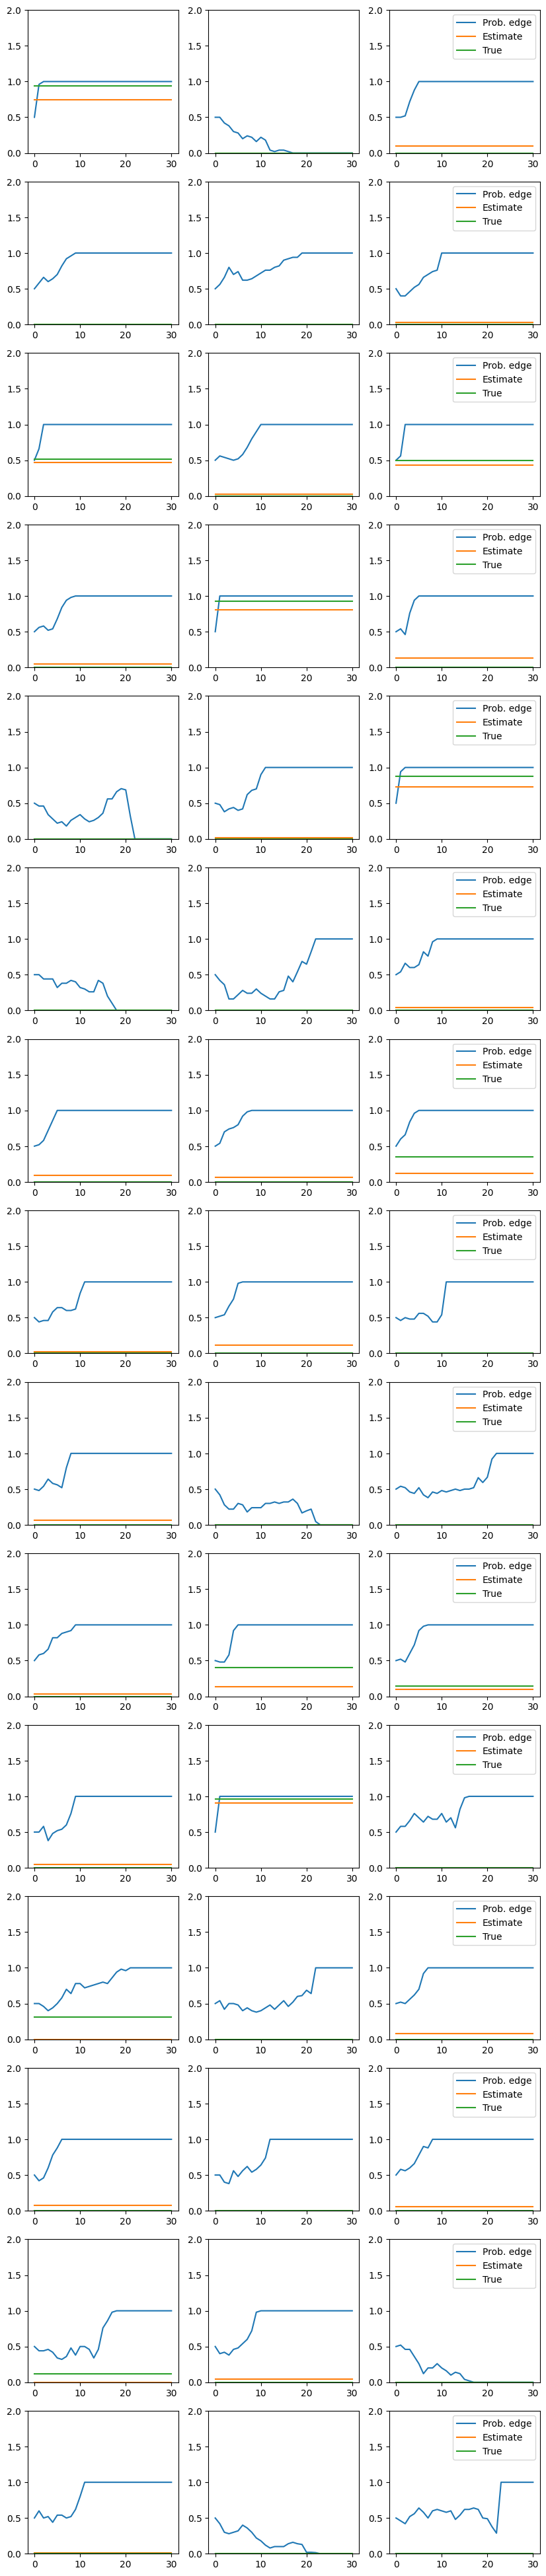

In [50]:
fig, ax = plt.subplots(15,3, figsize = (10,50))
for i in range(15):
    ax[i,0].plot(1-p[0,:,i*3])
    ax[i,0].plot([np.abs(edges_0[i*3])]*p.shape[1])
    ax[i,0].plot([np.abs(edges_true_0[i*3])]*p.shape[1])
    ax[i,0].set_ylim((0,2))

    ax[i,1].plot(1-p[0,:,i*3+1])
    ax[i,1].plot([np.abs(edges_0[i*3+1])]*p.shape[1])
    ax[i,1].plot([np.abs(edges_true_0[i*3+1])]*p.shape[1])
    ax[i,1].set_ylim((0,2))

    ax[i,2].plot(1-p[0,:,i*3+2], label = 'Prob. edge')
    ax[i,2].plot([np.abs(edges_0[i*3+2])]*p.shape[1], label = 'Estimate')
    ax[i,2].plot([np.abs(edges_true_0[i*3+2])]*p.shape[1], label = 'True')
    ax[i,2].set_ylim((0,2))
    ax[i,2].legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


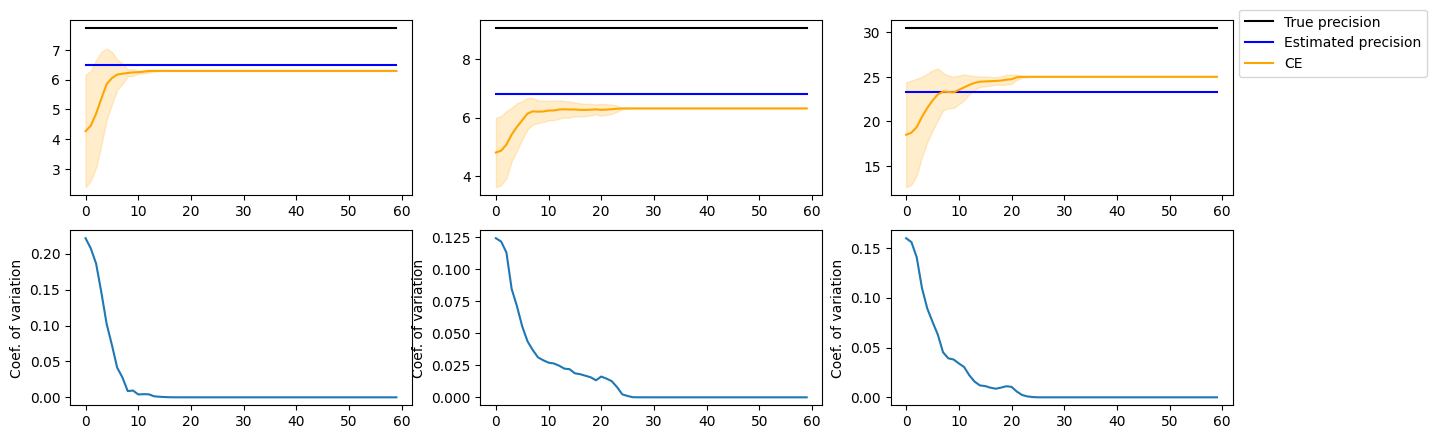

In [131]:

fig, ax = plt.subplots(2,3, figsize = (15,5))
for h in range(3):
    mean = np.zeros(nr_ce_itr)
    std = np.zeros(nr_ce_itr)
    eigs = np.linalg.eigvals(graph_sampling_testing['thetas'][h])
    true_est = np.max(eigs)/np.min(eigs) 
    eigs = np.linalg.eigvals(graph_sampling_testing['As'][h])
    true = np.max(eigs)/np.min(eigs) 
    for i in range(nr_ce_itr):

        mean[i] = np.mean(np.max(eigvals[h,i], axis = 1)/np.min(eigvals[h,i], axis = 1))
        std[i] = np.std(np.max(eigvals[h,i], axis = 1)/np.min(eigvals[h,i], axis = 1))


    ax[0,h].plot(range(nr_ce_itr), [true]*nr_ce_itr, color = 'black', label = "True precision")
    ax[0,h].plot(range(nr_ce_itr), [true_est]*nr_ce_itr, color = 'blue', label = "Estimated precision")
    ax[0,h].plot(range(nr_ce_itr), mean, color = 'orange', label = 'CE')
    ax[0,h].fill_between(range(nr_ce_itr), mean + 2*std, mean - 2*std, alpha = 0.2, color = 'orange')
    ax[0,2].legend(bbox_to_anchor = (1,1.1))

    ax[1,h].plot(range(nr_ce_itr),std/mean)
    ax[1,h].set_ylabel('Coef. of variation')


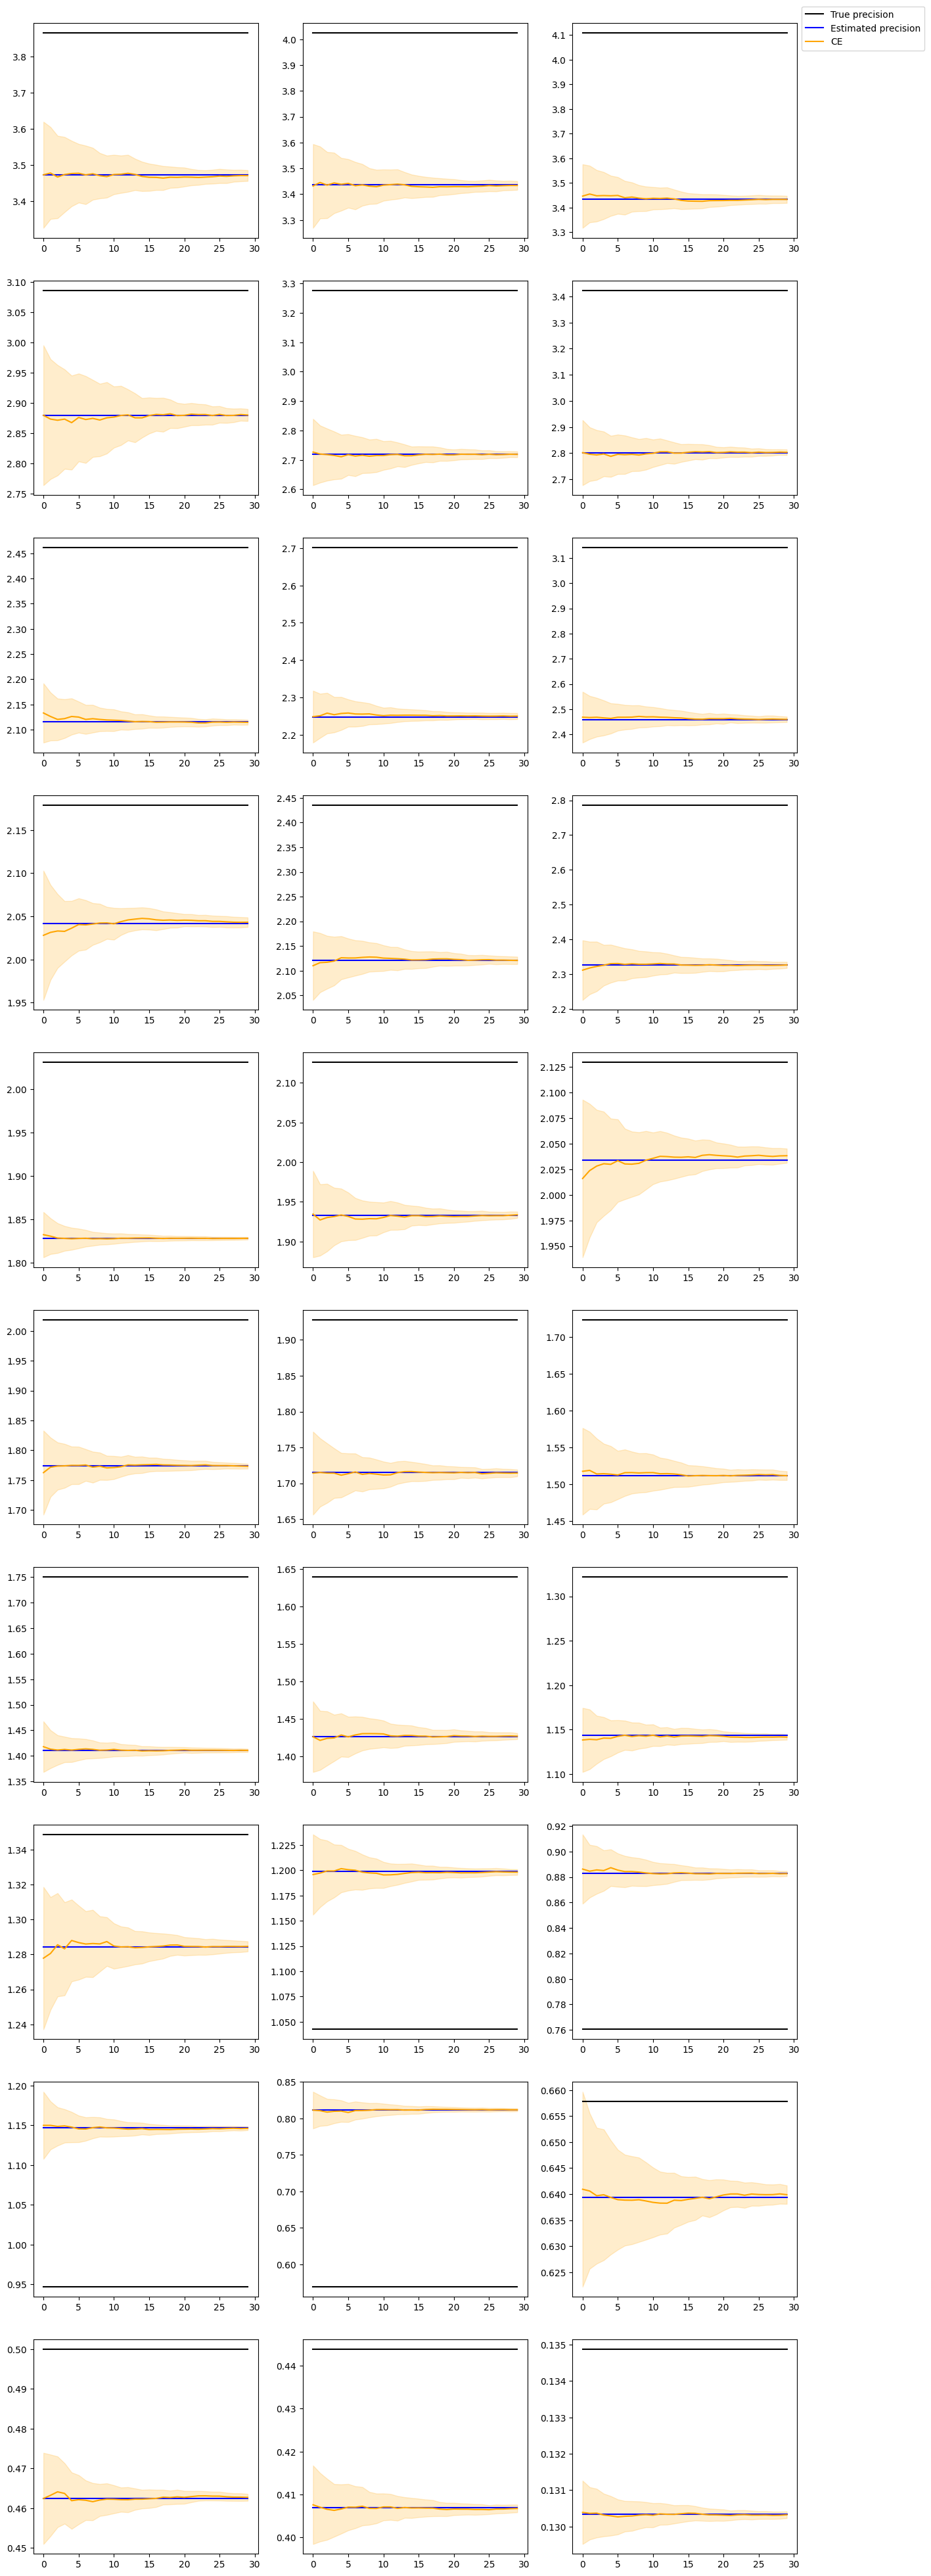

In [116]:

fig, ax = plt.subplots(10,3, figsize = (15,50))
# Need to sort all eig...
eig_distribution = eigvals.copy()
for h in range(eig_distribution.shape[0]):
    for i in  range(eig_distribution.shape[1]):
        for j in  range(eig_distribution.shape[2]):
            eig_distribution[h,i,j] = sorted(eig_distribution[h,i,j])


for j in range(1,11):
    for h in range(3):
        mean = np.zeros(nr_ce_its)
        std = np.zeros(nr_ce_its)
        eigs_est = np.linalg.eigvals(thetas[h])
        true_est = sorted(eigs_est)[-j]
        eigs = np.linalg.eigvals(As[h])
        true = sorted(eigs)[-j] 
        for i in range(nr_ce_itr):
            mean[i] = np.mean(eig_distribution[h,i,:,-j])
            std[i] = np.std(eig_distribution[h,i,:,-j])


        ax[j-1,h].plot(range(nr_ce_its), [true]*nr_ce_its, color = 'black', label = "True precision")
        ax[j-1,h].plot(range(nr_ce_its), [true_est]*nr_ce_its, color = 'blue', label = "Estimated precision")
        ax[j-1,h].plot(range(nr_ce_its), mean, color = 'orange', label = 'CE')
        ax[j-1,h].fill_between(range(nr_ce_its), mean + 2*std, mean - 2*std, alpha = 0.2, color = 'orange')
        #ax[j-1,h].set_ylim((0,7))
        if j == 1 and h == 2:
            ax[j-1,h].legend(bbox_to_anchor = (1,1.1))




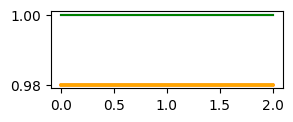

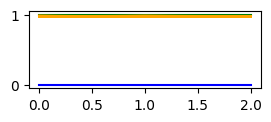

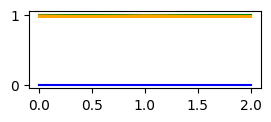

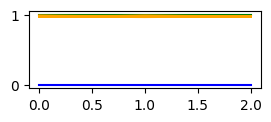

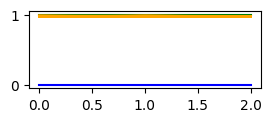

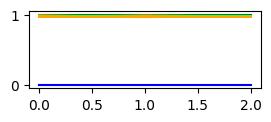

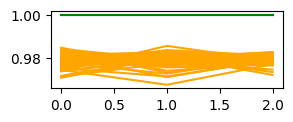

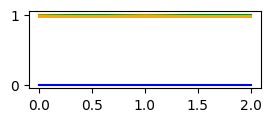

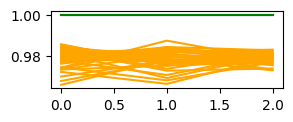

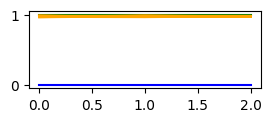

In [117]:

for i in range(10):
    fig, ax = plt.subplots(1,1, figsize = (3,1))
    ax.plot([np.abs(np.sign(As[0][np.triu_indices(10,1)][i]))]*len(p[:,i]), color = 'blue', label = 'True value')
    ax.plot([np.abs(np.sign(thetas[0][np.triu_indices(10,1)][i]))]*len(p[:,i]), color = 'green', label = 'Estimated value')
    ax.plot(1-p[:,i], color = 'orange', label = 'Estimated probability')
    #ax.legend()

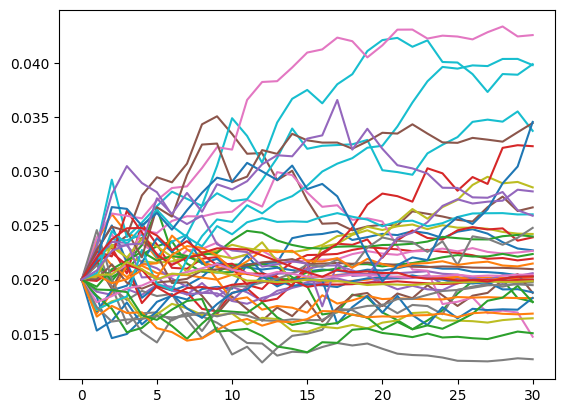

In [118]:
out = plt.plot(p[0,:])

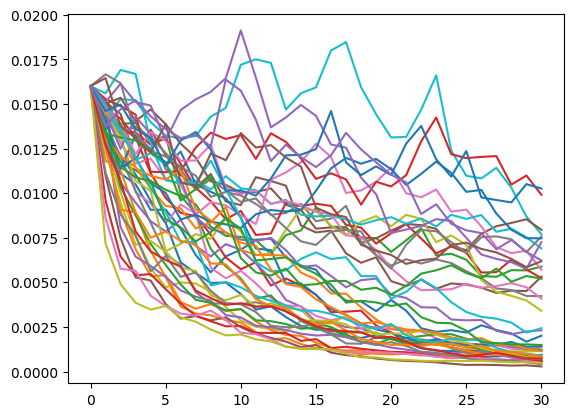

In [119]:
out = plt.plot(sigmas[0,:])

Perform ABC

In [ ]:
# Simulate static
print(model)
print(alpha_in_CE)

B = 1000
sample_nr = 2
bootstrap_boot = False

d = X.shape[1]

thetas_sim = [[], [], []]
pvals = np.zeros((3,B))
fros = np.zeros((3,B))
nr_rejections = [0,0,0]
pbar = tqdm.tqdm(total = B*3)

for h in range(3):
    X1 = X[obs_per_graph*h:(h+1)*obs_per_graph].copy()
    s_1 = np.linalg.inv(thetas[h])
    for b in range(B):
        
        if model == 'expon':
            berns = scipy.stats.expon.rvs(scale = p[h,sample_nr], size = len(p[h,sample_nr]))  
            reg_matrix = np.zeros((d,d))  # ATTENTION TO NUMPY ZERO OR ONES
            reg_matrix[np.triu_indices(d,1)] = berns
            reg_matrix = reg_matrix + reg_matrix.T
        elif model == 'Gaussian':
            berns =scipy.stats.norm.rvs(loc = alpha, scale = 0.01, size = len(p[h,sample_nr]))  # scipy.stats.norm.rvs(loc = p[h,sample_nr], scale = sigmas[h,sample_nr], size = len(p[h,sample_nr]))  
            berns[berns<0] = 0
            reg_matrix = np.zeros((d,d))
            reg_matrix[np.triu_indices(d,1)] = berns
            reg_matrix = reg_matrix + reg_matrix.T
        elif model == 'Bernoulli':
            berns = scipy.stats.bernoulli.rvs(p = p[h,sample_nr], size = len(p[h,sample_nr]))  
            if alpha_in_CE:
                reg_matrix = np.ones((d,d))*alpha
            else:
                reg_matrix = np.zeros((d,d))
            np.fill_diagonal(reg_matrix,0)
            reg_matrix[np.triu_indices(d,1)] = berns*999999
            reg_matrix = reg_matrix + reg_matrix.T
            
        if bootstrap_boot:
            X_i = X1[np.random.choice(X1.shape[0], size = X1.shape[0], replace=True)].copy()
        else:
            X_i = X1


        # berns = scipy.stats.bernoulli.rvs(p = 0.5, size = len(p[sample_nr]))  
        # reg_matrix = np.zeros((d,d))*0.02
        # reg_matrix[np.triu_indices(d,1)] = berns*999999
        # reg_matrix = reg_matrix + reg_matrix.T

            
        gls = dg.sgl_inner_em(X_i, max_iter = 500, lamda = reg_matrix, tol = 1e-4)
        gls.fit(nr_workers=1, lik_type="gaussian",verbose=False)
        theta_2 = gls.theta[-1].copy()
        X_s = multivariate_normal.rvs(cov = np.linalg.inv(theta_2),size = X1.shape[0])
        
        pvals[h,b], _ = my_hdtest(X_i, np.linalg.inv(theta_2), X1, s_1)
        fros[h,b] = np.linalg.norm(theta_2-thetas[h])/np.linalg.norm(thetas[h])
        if fros[h,b] >np.inf:
            nr_rejections[h]+=1
        else:
            thetas_sim[h].append(theta_2.copy())
        pbar.update()
pbar.close()
        

    




In [132]:
# Simulate Dynamic
# Simulate static
print(model)
print(alpha_in_CE)
print(obs_per_graph)

B = 1000
sample_nr = 10
bootstrap_boot = False

d = X.shape[1]

thetas_sim = [[], [], []]
pvals = np.zeros((3,B))
fros = np.zeros((3,B))
nr_rejections = [0,0,0]
pbar = tqdm.tqdm(total = B)
H = 3
for b in range(B):
    

    if model == 'expon':
        reg_matrix = np.zeros((H,d,d))
        for h in range(3):
            berns = scipy.stats.expon.rvs(scale = p[h,sample_nr], size = len(p[h,sample_nr]))  
            reg_matrix[h][np.triu_indices(d,1)] = berns
            reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T
    elif model == 'Gaussian':
        reg_matrix = np.zeros((H,d,d))
        for h in range(3):
            berns = scipy.stats.norm.rvs(loc = p[h,sample_nr], scale = sigmas[h,sample_nr], size = len(p[h,sample_nr]))
            reg_matrix[h][np.triu_indices(d,1)] = berns
            reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T
    elif model == 'Bernoulli':
        if alpha_in_CE:
            reg_matrix = np.ones((H,d,d))*alpha
        else:
            reg_matrix = np.zeros((H,d,d))
        for h in range(3):
            berns = scipy.stats.bernoulli.rvs(p = p[h,sample_nr], size = len(p[h,sample_nr]))  
            np.fill_diagonal(reg_matrix[h],0)
            reg_matrix[h][np.triu_indices(d,1)] = berns*999999
            reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T
        
    if bootstrap_boot:
        pass
    else:
        X_i = X


        # berns = scipy.stats.bernoulli.rvs(p = 0.5, size = len(p[sample_nr]))  
        # reg_matrix = np.zeros((d,d))*0.02
        # reg_matrix[np.triu_indices(d,1)] = berns*999999
        # reg_matrix = reg_matrix + reg_matrix.T


        gls = dg.dygl_inner_em(X_i, obs_per_graph = obs_per_graph, max_iter = 1000, lamda = reg_matrix, kappa =kappa, tol = 1e-6)
        gls.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        theta_2 = gls.theta.copy()

        
        for h in range(3):
            X_s = multivariate_normal.rvs(cov = np.linalg.inv(theta_2[h]),size = int(X.shape[0]/H))
            X_hi = X[(h*obs_per_graph):((h+1)*obs_per_graph)].copy()
            pvals[h,b], _ = my_hdtest(X_i, np.linalg.inv(theta_2[h]), X_hi, np.linalg.inv(thetas[h]))
            fros[h,b] = np.linalg.norm(theta_2[h]-thetas[h])/np.linalg.norm(thetas[h])
            if fros[h,b] >np.inf:
                nr_rejections[h]+=1
            else:
                thetas_sim[h].append(theta_2[h].copy())
        pbar.update()
pbar.close()
        

    




Bernoulli
True
200


100%|██████████| 1000/1000 [00:53<00:00, 18.52it/s]


<AxesSubplot: ylabel='Density'>

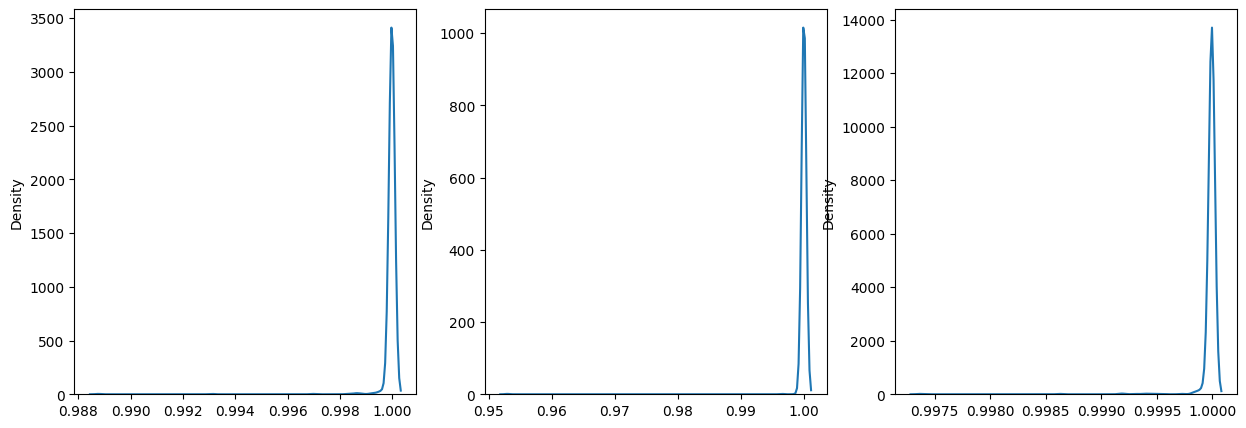

In [82]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.kdeplot(pvals[0], ax = ax[0])
sns.kdeplot(pvals[1], ax = ax[1])
sns.kdeplot(pvals[2], ax = ax[2])

<AxesSubplot: ylabel='Density'>

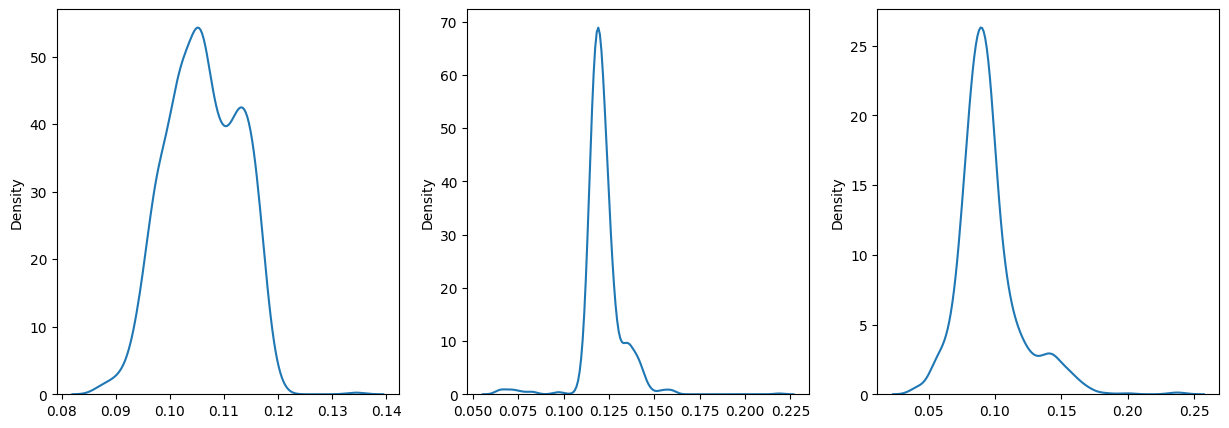

In [133]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.kdeplot(fros[0], ax = ax[0])
sns.kdeplot(fros[1], ax = ax[1])
sns.kdeplot(fros[2], ax = ax[2])

<ErrorbarContainer object of 3 artists>

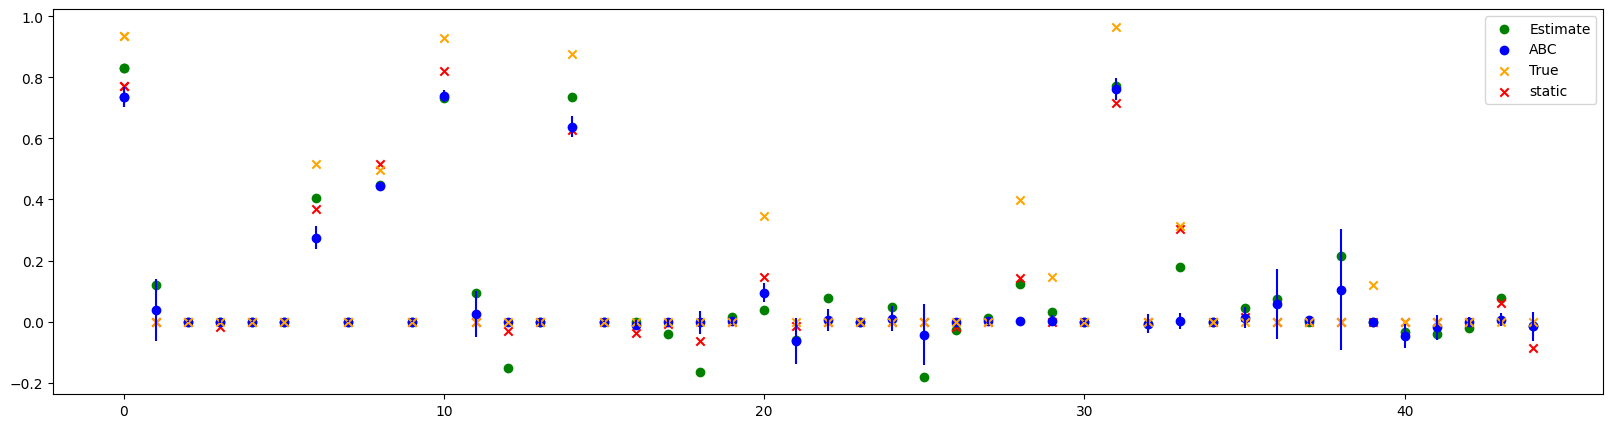

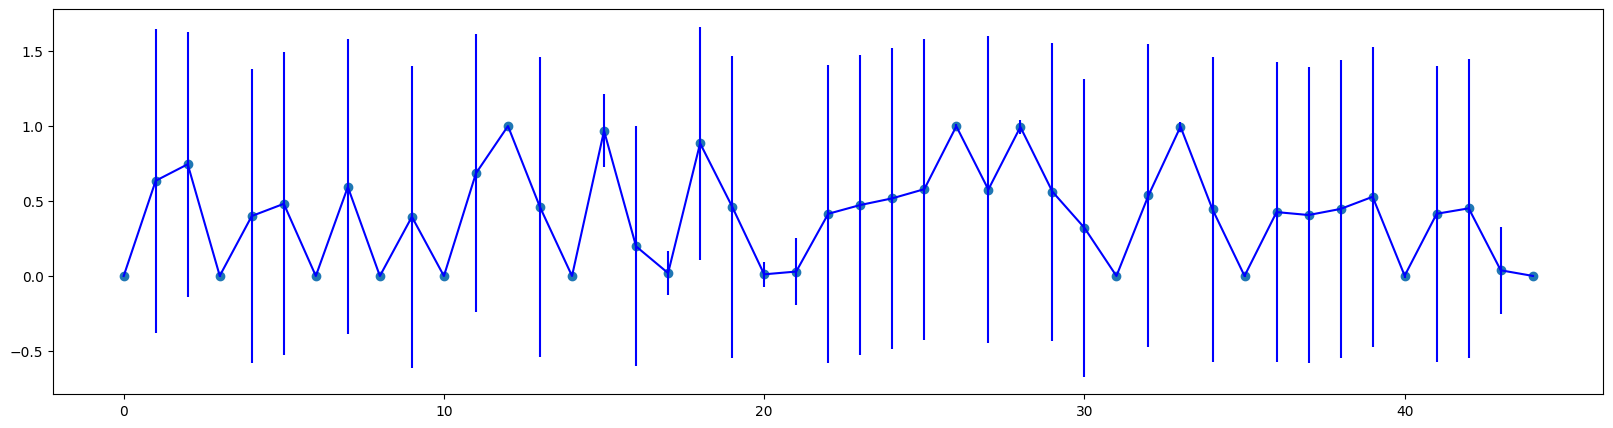

In [134]:

theta_sgls = []
for h in range(3):
    X_h=X[obs_per_graph*h:(h+1)*obs_per_graph]
    gls = dg.sgl_inner_em(X_h, max_iter = 500, lamda = alpha, tol = 1e-4)
    gls.fit(nr_workers=1, lik_type="gaussian",verbose=False)
    theta_sgls.append(gls.theta[-1].copy())



h = 0
theta_est = thetas[h]
theta_est[np.abs(theta_est)<1e-3] = 0
theta_u = theta_est[np.triu_indices(d,1)]
theta_s = theta_sgls[h][np.triu_indices(d,1)]
std_u = np.std(np.array(thetas_sim[h]), axis = 0 )[np.triu_indices(d,1)]
mean_u = np.mean(np.array(thetas_sim[h]), axis = 0 )[np.triu_indices(d,1)]
A_true_u = As[h][np.triu_indices(10,1)]

fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.scatter(0, theta_u[0], label ='Estimate', color = 'green')
ax.scatter(0, mean_u[0], label ='ABC', color = 'blue')
ax.scatter(0, A_true_u[0], marker = 'x', label ='True', color = 'orange')
ax.scatter(0, theta_s[0], marker = 'x', label ='static', color = 'red')

ax.errorbar(0, mean_u[0], 2*std_u[0], color = 'blue')
ax.legend()

for i in range( 45):
    ax.scatter(i, theta_u[i], color = 'green')
    ax.scatter(i, theta_s[i], marker = 'x', label ='static', color = 'red')
    ax.scatter(i, mean_u[i], label ='ABC', color = 'blue')
    ax.scatter(i, A_true_u[i], marker = 'x', color = 'orange')
    ax.errorbar(i, mean_u[i], 2*std_u[i], color = 'blue')
    


fig, ax = plt.subplots(1,1, figsize = (20,5))

ax.scatter(range(len(p[h,sample_nr])),p[h,sample_nr])
ax.errorbar(range(len(p[h,sample_nr])), p[h,sample_nr], 2*sigmas[h,sample_nr], color = 'blue')



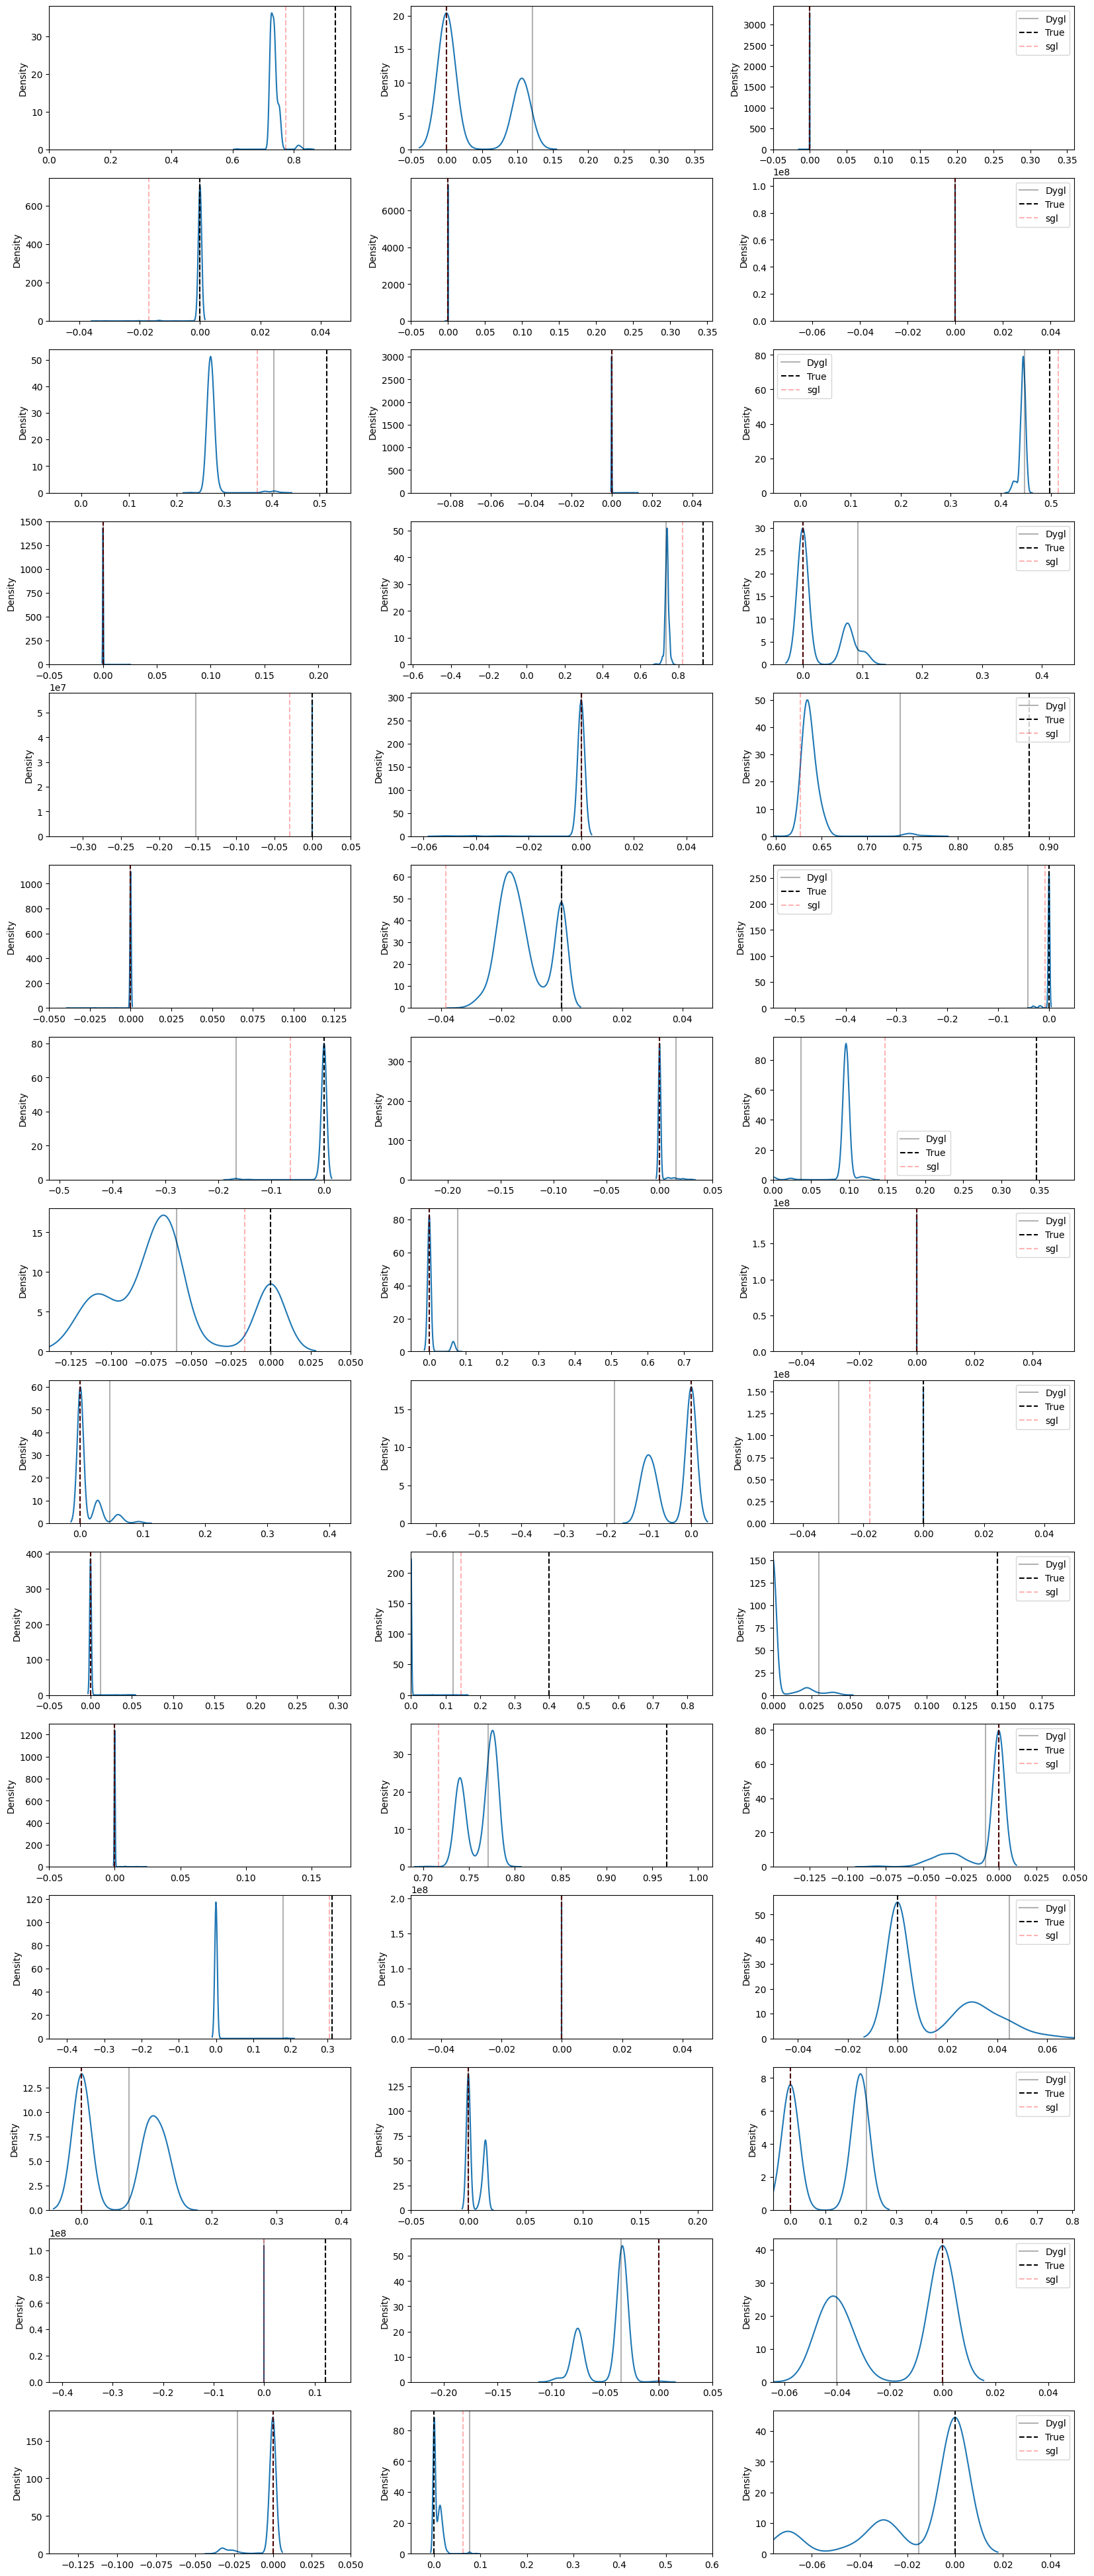

In [135]:
fig, ax = plt.subplots(15,3, figsize = (20,50))
cnt = 0
h = 0
for i in range(10):
    for j in range(i+1,10):
        cnt_col = cnt % 3
        cnt_row = int(cnt / 3)
        theta_est = thetas[h].copy()
        theta_est[np.abs(theta_est)<1e-3] = 0
        sns.kdeplot(np.array(thetas_sim[h])[:,i,j], ax = ax[cnt_row, cnt_col])
        ax[cnt_row, cnt_col].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black', alpha = 0.3)
        ax[cnt_row, cnt_col].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
        ax[cnt_row, cnt_col].axvline(x = theta_sgls[h][i,j], label = 'sgl', color = 'red', linestyle = 'dashed', alpha = 0.3)
        ax[cnt_row, cnt_col].set_xlim((np.min((np.min(np.array(thetas_sim)[:,:,i,j]), As[h,i,j]-0.05)),np.max((np.max(np.array(thetas_sim)[:,:,i,j]), As[h,i,j]+0.05))))
        if cnt_col == 2:
            ax[cnt_row, cnt_col].legend()
        cnt+=1



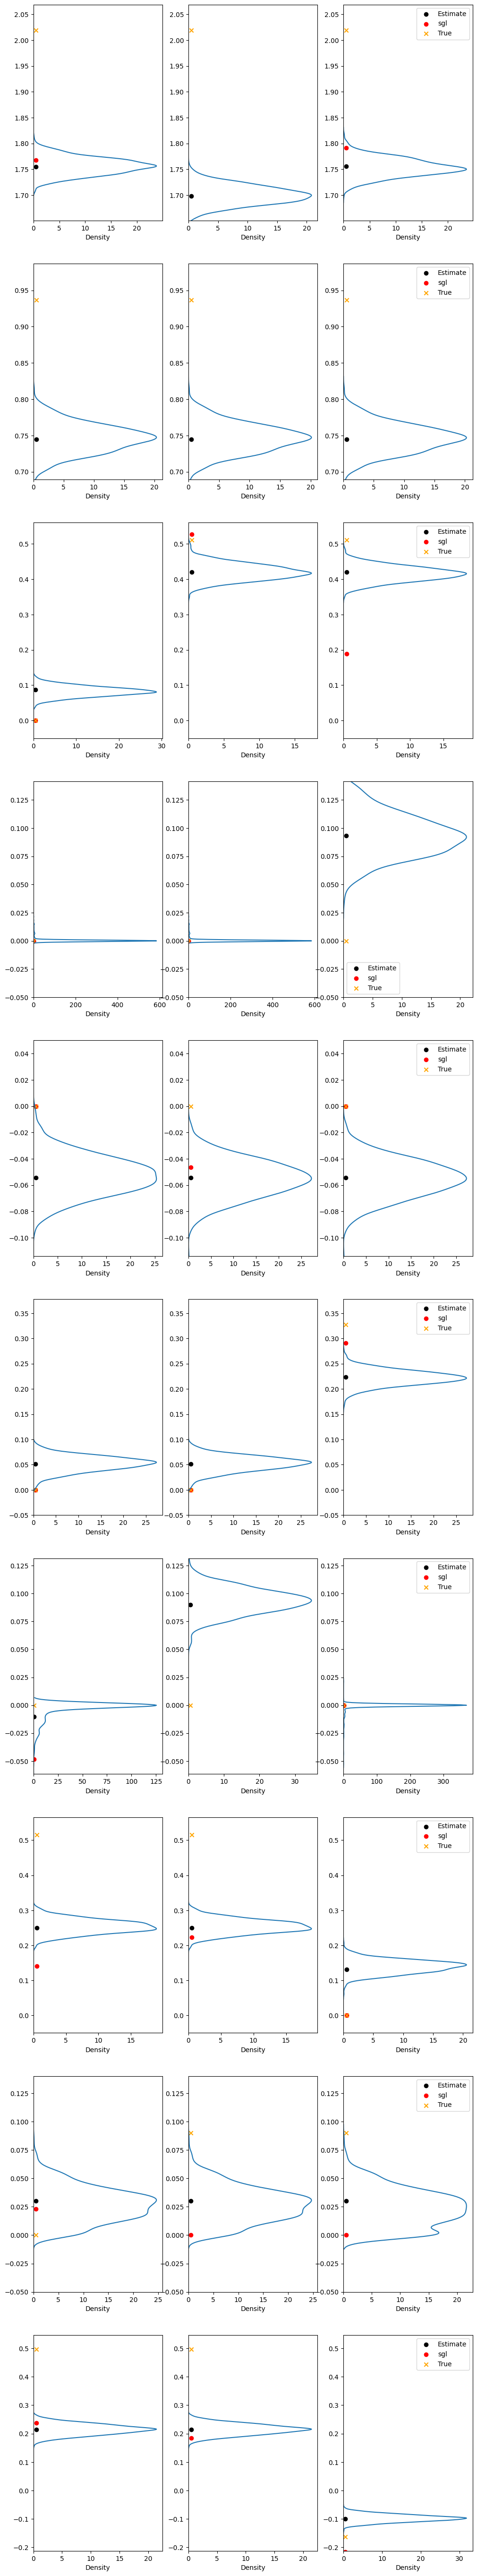

In [54]:

theta_est = thetas.copy()
As = np.array(graph_sampling_testing['As'])
theta_est[np.abs(theta_est)<1e-3] = 0

fig, ax = plt.subplots(10,3, figsize = (12,70))
n_i =0
for n_j in range(0,10):
    for h in range(3):
        ax[n_j,h].scatter([0.5], theta_est[h,n_i,n_j], label ='Estimate', color = 'black')
        ax[n_j,h].scatter([0.5], theta_sgls[h][n_i,n_j], label ='sgl', color = 'red')
        ax[n_j,h].scatter([0.5], As[h,n_i,n_j], label ='True', color = 'orange', marker = 'x' )
        sns.kdeplot(y = np.array(thetas_sim[h])[:,n_i,n_j], ax = ax[n_j,h])
        ax[n_j,h].set_ylim((np.min((np.min(np.array(thetas_sim)[:,:,n_i,n_j]), np.min(As[:,n_i,n_j]-0.05))),np.max((np.max(np.array(thetas_sim)[:,:,n_i,n_j]), np.max(As[:,n_i,n_j]+0.05)))))
    
    ax[n_j,2].legend()

Compare to bootstrap of X, same alpha, kappa

In [104]:
# Simulate Dynamic
# Simulate static
print(model)
print(alpha_in_CE)
print(obs_per_graph)
print(alpha)
print(kappa)

B = 1000
sample_nr = 2
bootstrap_boot = False

d = X.shape[1]

thetas_sim_boot = [[], [], []]
pvals = np.zeros((3,B))
fros = np.zeros((3,B))
nr_rejections = [0,0,0]
pbar = tqdm.tqdm(total = B)

for b in range(B):


    Xs = []
    for h in range(3):
        X_tmp = X[(h*obs_per_graph):((h+1)*obs_per_graph)]
        X_tmp = X_tmp[np.random.choice(X_tmp.shape[0], size = X_tmp.shape[0], replace=True)].copy()
        Xs.append(X_tmp.copy())
        
    X_i = np.vstack((Xs[0],Xs[1],Xs[2]))


        # berns = scipy.stats.bernoulli.rvs(p = 0.5, size = len(p[sample_nr]))  
        # reg_matrix = np.zeros((d,d))*0.02
        # reg_matrix[np.triu_indices(d,1)] = berns*999999
        # reg_matrix = reg_matrix + reg_matrix.T


    gls = dg.dygl_inner_em(X_i, obs_per_graph = obs_per_graph, max_iter = 1000, lamda = alpha, kappa =kappa, tol = 1e-6)
    gls.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
    theta_2 = gls.theta.copy()

        
    for h in range(3):
        thetas_sim_boot[h].append(theta_2[h].copy())
    pbar.update()
pbar.close()
        


Gaussian
False
200
0.02
0.05


100%|██████████| 1000/1000 [01:10<00:00, 14.24it/s]


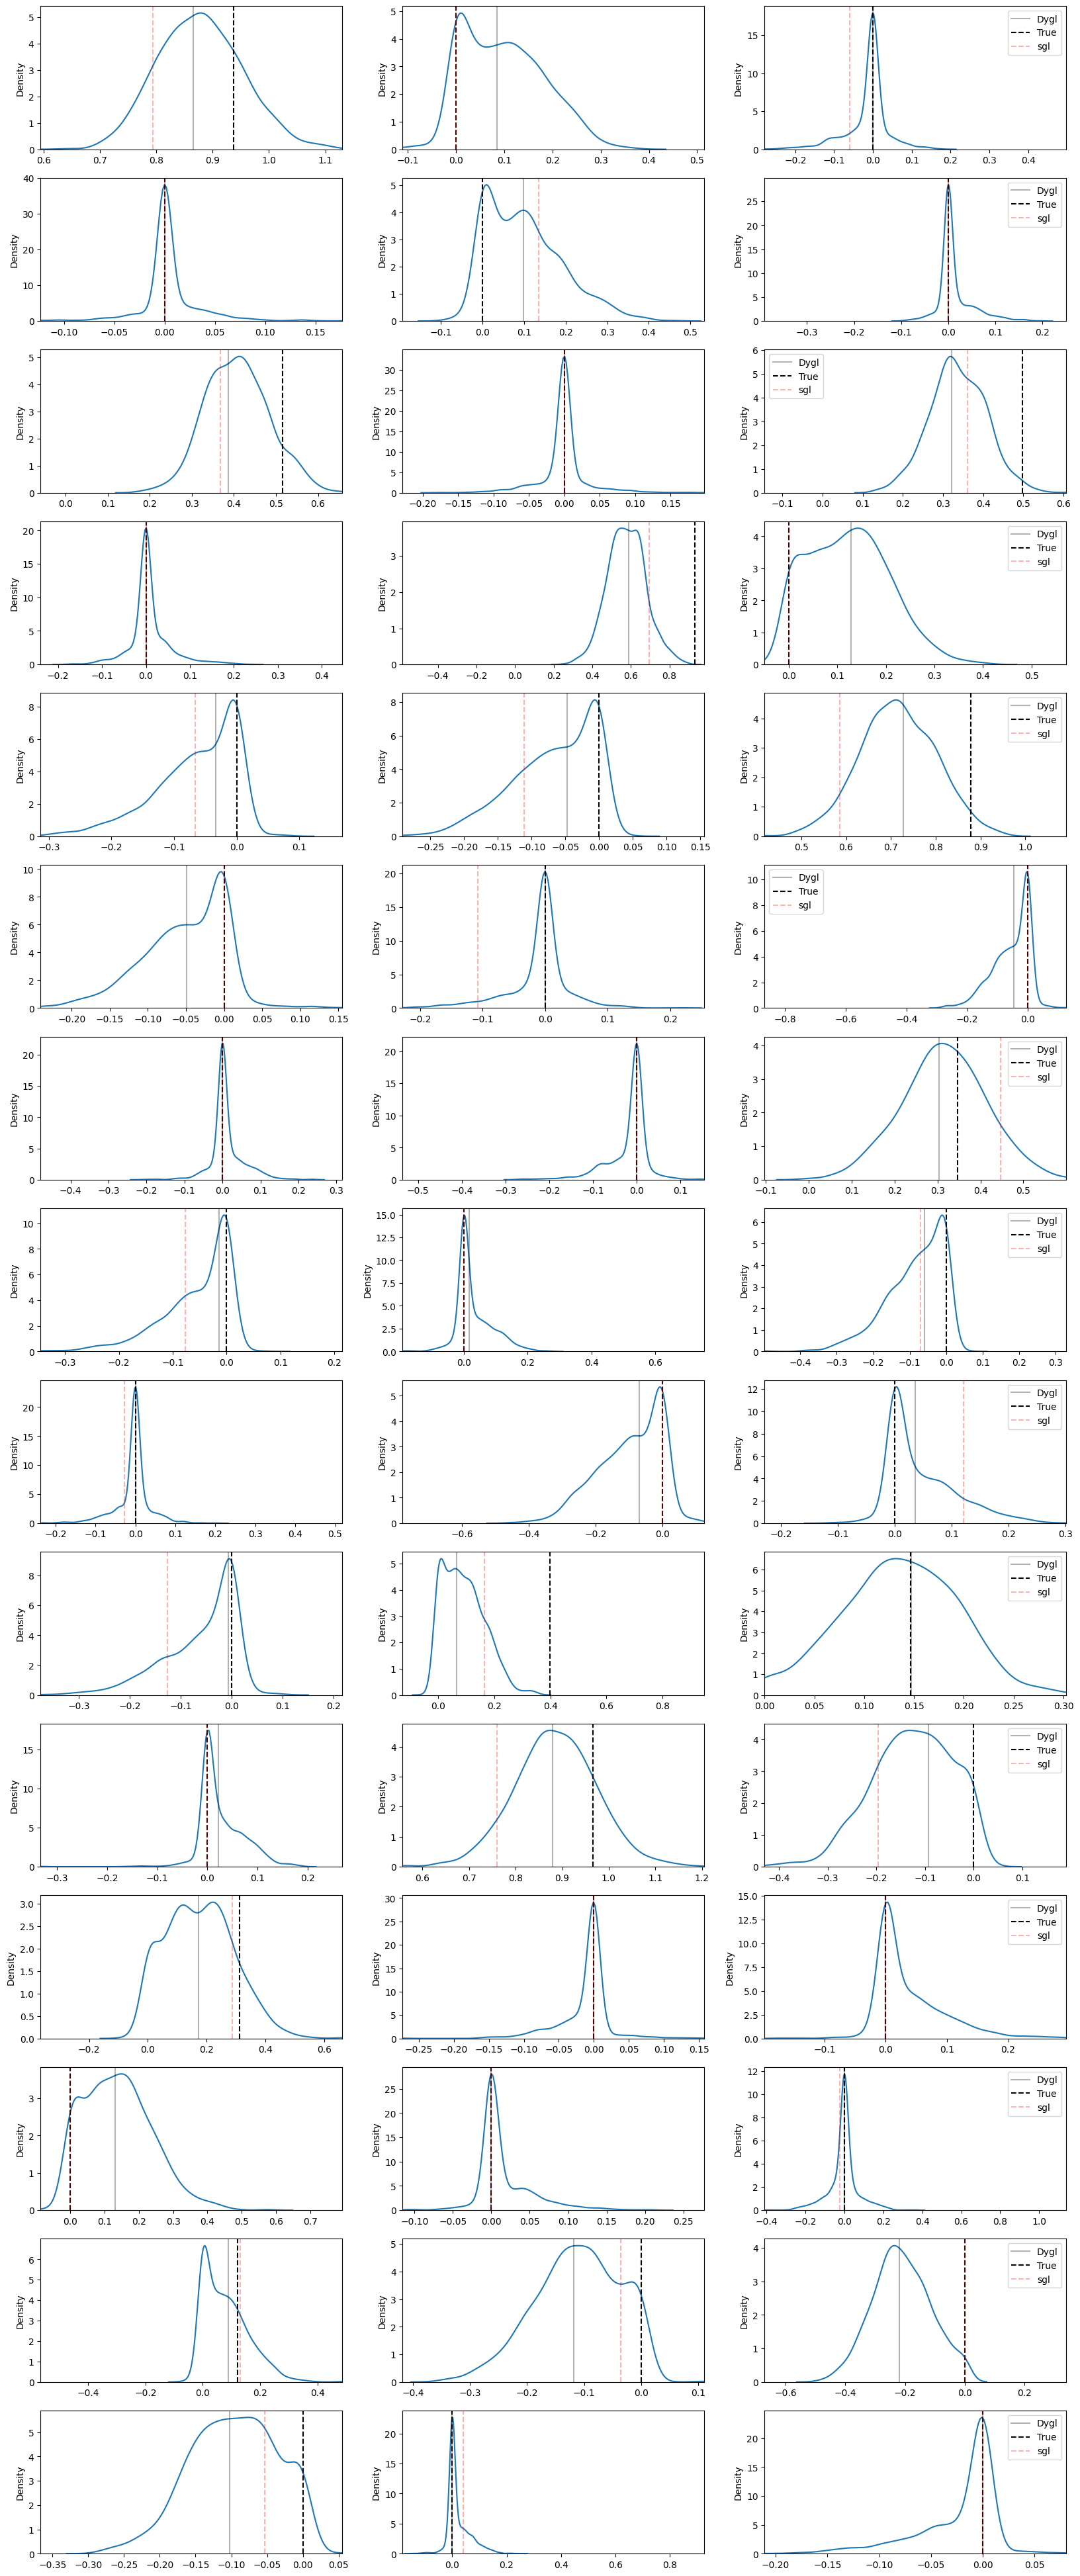

In [105]:
fig, ax = plt.subplots(15,3, figsize = (20,50))
cnt = 0
h = 0
for i in range(10):
    for j in range(i+1,10):
        cnt_col = cnt % 3
        cnt_row = int(cnt / 3)
        theta_est = thetas[h].copy()
        theta_est[np.abs(theta_est)<1e-3] = 0
        sns.kdeplot(np.array(thetas_sim_boot[h])[:,i,j], ax = ax[cnt_row, cnt_col])
        ax[cnt_row, cnt_col].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black', alpha = 0.3)
        ax[cnt_row, cnt_col].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
        ax[cnt_row, cnt_col].axvline(x = theta_sgls[h][i,j], label = 'sgl', color = 'red', linestyle = 'dashed', alpha = 0.3)
        ax[cnt_row, cnt_col].set_xlim((np.min((np.min(np.array(thetas_sim_boot)[:,:,i,j]), As[h,i,j]-0.05)),np.max((np.max(np.array(thetas_sim_boot)[:,:,i,j]), As[h,i,j]+0.05))))
        if cnt_col == 2:
            ax[cnt_row, cnt_col].legend()
        cnt+=1



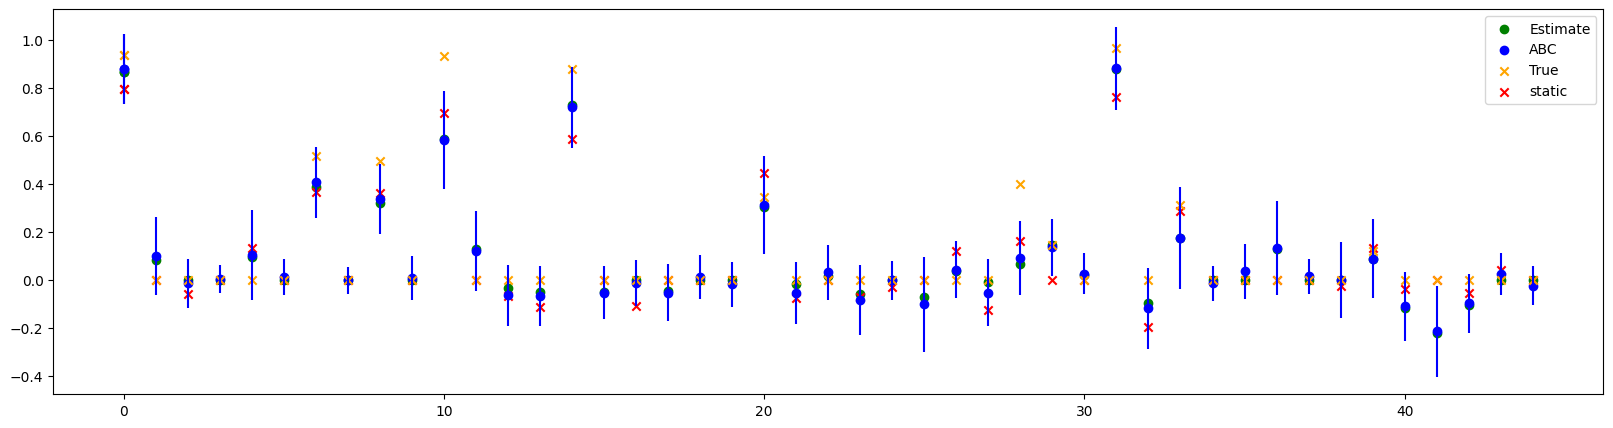

In [102]:

theta_sgls = []
for h in range(3):
    X_h=X[obs_per_graph*h:(h+1)*obs_per_graph]
    gls = dg.sgl_inner_em(X_h, max_iter = 500, lamda = alpha, tol = 1e-4)
    gls.fit(nr_workers=1, lik_type="gaussian",verbose=False)
    theta_sgls.append(gls.theta[-1].copy())



h = 0
theta_est = thetas[h]
theta_est[np.abs(theta_est)<1e-3] = 0
theta_u = theta_est[np.triu_indices(d,1)]
theta_s = theta_sgls[h][np.triu_indices(d,1)]
std_u = np.std(np.array(thetas_sim_boot[h]), axis = 0 )[np.triu_indices(d,1)]
mean_u = np.mean(np.array(thetas_sim_boot[h]), axis = 0 )[np.triu_indices(d,1)]
A_true_u = As[h][np.triu_indices(10,1)]

fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.scatter(0, theta_u[0], label ='Estimate', color = 'green')
ax.scatter(0, mean_u[0], label ='ABC', color = 'blue')
ax.scatter(0, A_true_u[0], marker = 'x', label ='True', color = 'orange')
ax.scatter(0, theta_s[0], marker = 'x', label ='static', color = 'red')

ax.errorbar(0, mean_u[0], 2*std_u[0], color = 'blue')
ax.legend()

for i in range( 45):
    ax.scatter(i, theta_u[i], color = 'green')
    ax.scatter(i, theta_s[i], marker = 'x', label ='static', color = 'red')
    ax.scatter(i, mean_u[i], label ='ABC', color = 'blue')
    ax.scatter(i, A_true_u[i], marker = 'x', color = 'orange')
    ax.errorbar(i, mean_u[i], 2*std_u[i], color = 'blue')
    




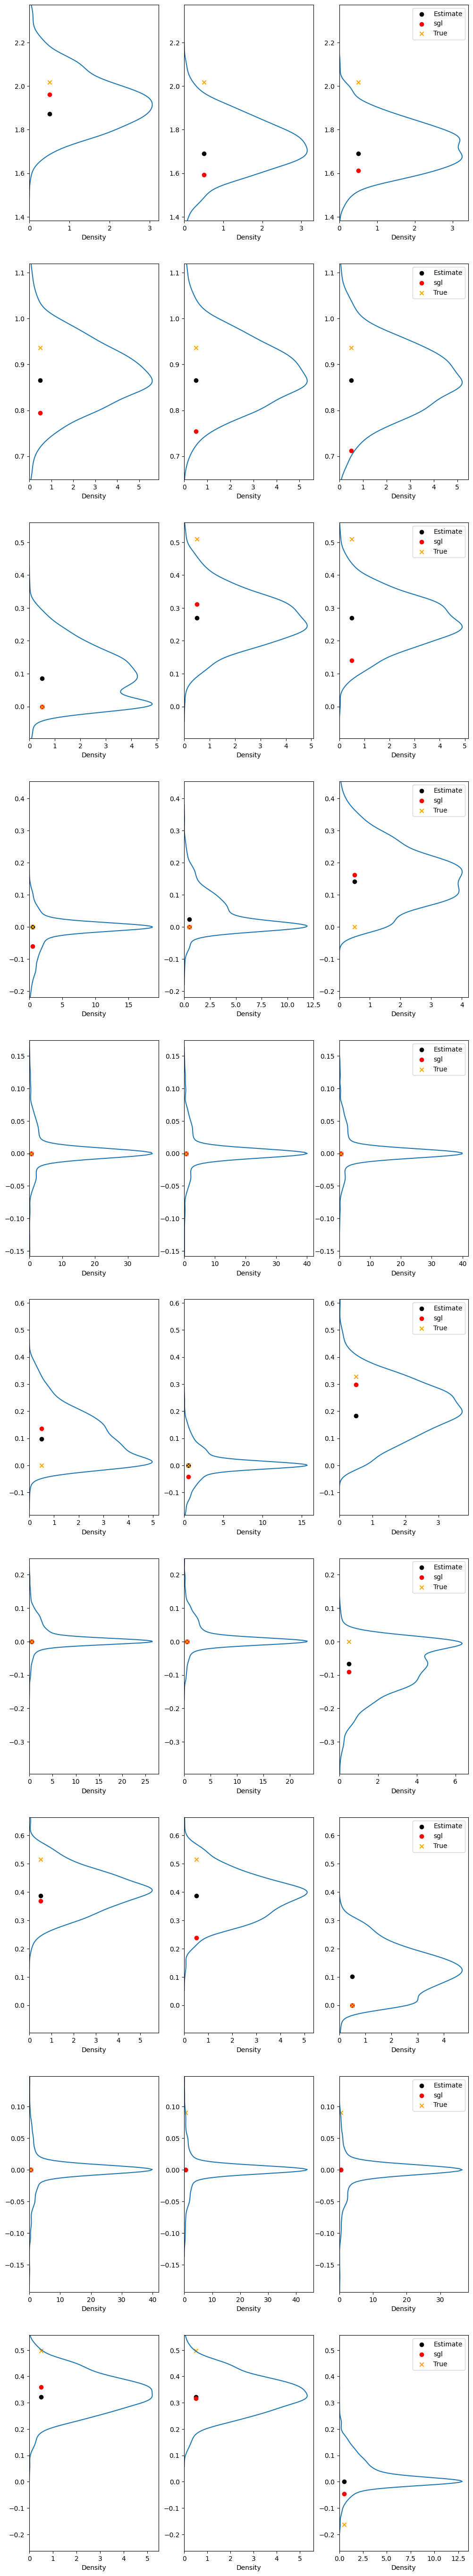

In [103]:

theta_est = thetas.copy()
As = np.array(graph_sampling_testing['As'])
theta_est[np.abs(theta_est)<1e-3] = 0

fig, ax = plt.subplots(10,3, figsize = (12,70))
n_i =0
for n_j in range(0,10):
    for h in range(3):
        ax[n_j,h].scatter([0.5], theta_est[h,n_i,n_j], label ='Estimate', color = 'black')
        ax[n_j,h].scatter([0.5], theta_sgls[h][n_i,n_j], label ='sgl', color = 'red')
        ax[n_j,h].scatter([0.5], As[h,n_i,n_j], label ='True', color = 'orange', marker = 'x' )
        sns.kdeplot(y = np.array(thetas_sim[h])[:,n_i,n_j], ax = ax[n_j,h])
        ax[n_j,h].set_ylim((np.min((np.min(np.array(thetas_sim)[:,:,n_i,n_j]), np.min(As[:,n_i,n_j]-0.05))),np.max((np.max(np.array(thetas_sim)[:,:,n_i,n_j]), np.max(As[:,n_i,n_j]+0.05)))))
    
    ax[n_j,2].legend()

# Read


In [226]:
with open(f'../data/GraphHypTest/new_30_cai_xs_both_ref_and_ce.pkl', 'rb') as handle:
    graph_sampling_testing = pickle.load(handle)

graph_sampling_testing.keys()

dict_keys(['alphas', 'kappas', 'p_distribution', 'thetas', 'thetas_sim', 'X', 'As', 'N', 'nr_ce_it', 'ratio_nr_zeros', 'obs_per_graph', 'alpha_in_CE', 'model', 'bootstrap_X', 'sigmas'])

In [332]:
print(np.round(graph_sampling_testing['thetas'][0,2,0][0,:20],2))
print(np.round(graph_sampling_testing['thetas'][0,2,1][0,:20],2))
print(np.round(graph_sampling_testing['thetas'][0,2,2][0,:20],2))

[ 3.64  0.   -0.04 -0.   -0.03  0.29  0.    0.   -0.   -0.   -0.    0.
 -0.   -0.    0.    0.05  0.06  0.    0.   -0.12]
[ 3.06  0.   -0.   -0.   -0.    0.29  0.    0.17 -0.    0.   -0.    0.15
 -0.    0.3  -0.33 -0.13  0.06  0.    0.    0.38]
[ 2.33 -0.   -0.    0.    0.01  0.21  0.    0.61 -0.05 -0.   -0.    0.53
  0.22  0.42 -0.02 -0.57  0.06  0.    0.    0.38]


Get AIC

In [333]:
graph_sampling_testing['X'].shape

(300, 20)

In [237]:
np.round(graph_sampling_testing['thetas_sim'][0,0,29,500,0],2)

array([[ 3.87, -0.28,  0.85,  0.21,  1.41, -0.12,  1.4 ,  0.39,  0.  ,
         0.53],
       [-0.28,  3.54, -0.04,  1.1 ,  0.68,  0.38, -0.7 ,  0.27,  0.82,
         0.76],
       [ 0.85, -0.04,  2.93,  0.33,  0.83, -0.41,  0.4 ,  0.17, -0.24,
        -0.26],
       [ 0.21,  1.1 ,  0.33,  2.45,  0.42,  1.09,  0.33,  0.48, -0.13,
         0.  ],
       [ 1.41,  0.68,  0.83,  0.42,  4.91,  0.84, -0.42,  0.25, -1.15,
         0.33],
       [-0.12,  0.38, -0.41,  1.09,  0.84,  3.18, -0.31, -0.67, -0.37,
         1.14],
       [ 1.4 , -0.7 ,  0.4 ,  0.33, -0.42, -0.31,  3.39,  0.56,  0.06,
         1.14],
       [ 0.39,  0.27,  0.17,  0.48,  0.25, -0.67,  0.56,  2.02,  0.  ,
         0.24],
       [ 0.  ,  0.82, -0.24, -0.13, -1.15, -0.37,  0.06,  0.  ,  5.42,
         0.03],
       [ 0.53,  0.76, -0.26,  0.  ,  0.33,  1.14,  1.14,  0.24,  0.03,
         3.06]])

In [243]:
AICs = np.empty((len(graph_sampling_testing['kappas']), len(graph_sampling_testing['alphas'])))

pbar = tqdm.tqdm(total = np.prod(AICs.shape))

for k_cnt, kappa in enumerate(graph_sampling_testing['kappas']):
    for a_cnt, kappa in enumerate(graph_sampling_testing['alphas']):
        try:
            thetas = graph_sampling_testing['thetas_sim'][k_cnt][a_cnt][29,500]
            liks = log_lik_all(100, thetas, graph_sampling_testing['X'], 'gaussian')
            nr_params_val = find_nr_params(thetas, 't')
            AICs[k_cnt, a_cnt] = 2*(np.sum(nr_params_val) - np.sum(liks))
        except:
            continue

        pbar.update()
pbar.close()


      

100%|██████████| 12/12 [00:00<00:00, 856.97it/s]


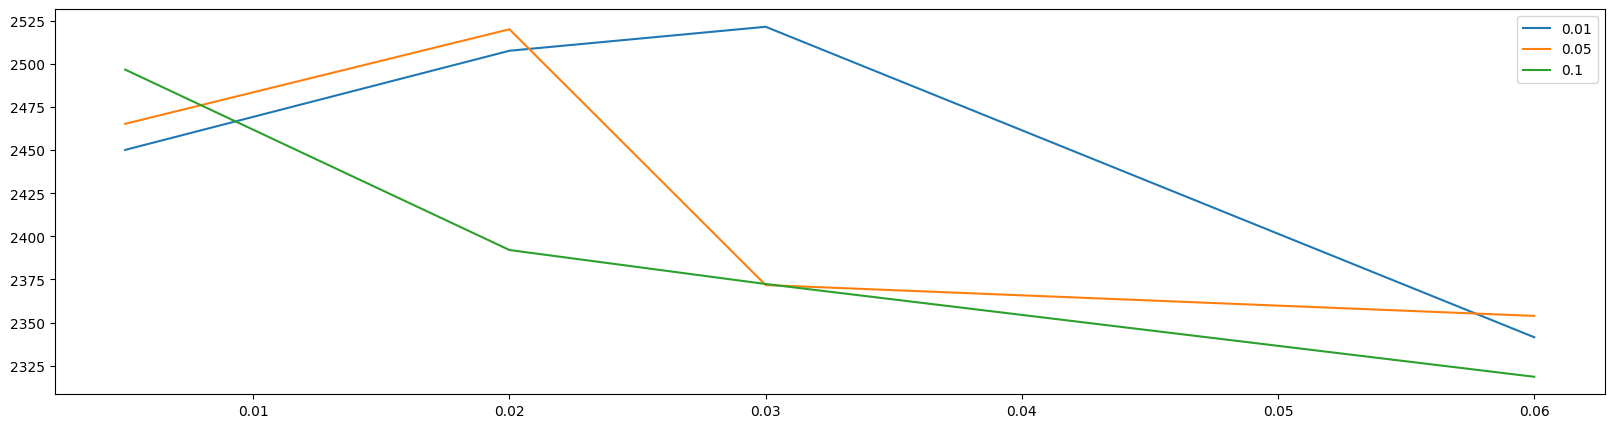

In [244]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
for i in range(3):
    ax.plot(graph_sampling_testing['alphas'], AICs[i], label = np.round(graph_sampling_testing['kappas'][i],2))
ax.legend()
    

How does p change with CE iteraion

In [322]:
graph_sampling_testing['p_distribution'].shape

(3, 5, 3, 61, 190)

In [248]:
graph_sampling_testing['p_distribution'].shape

(3, 4, 3, 31, 45)

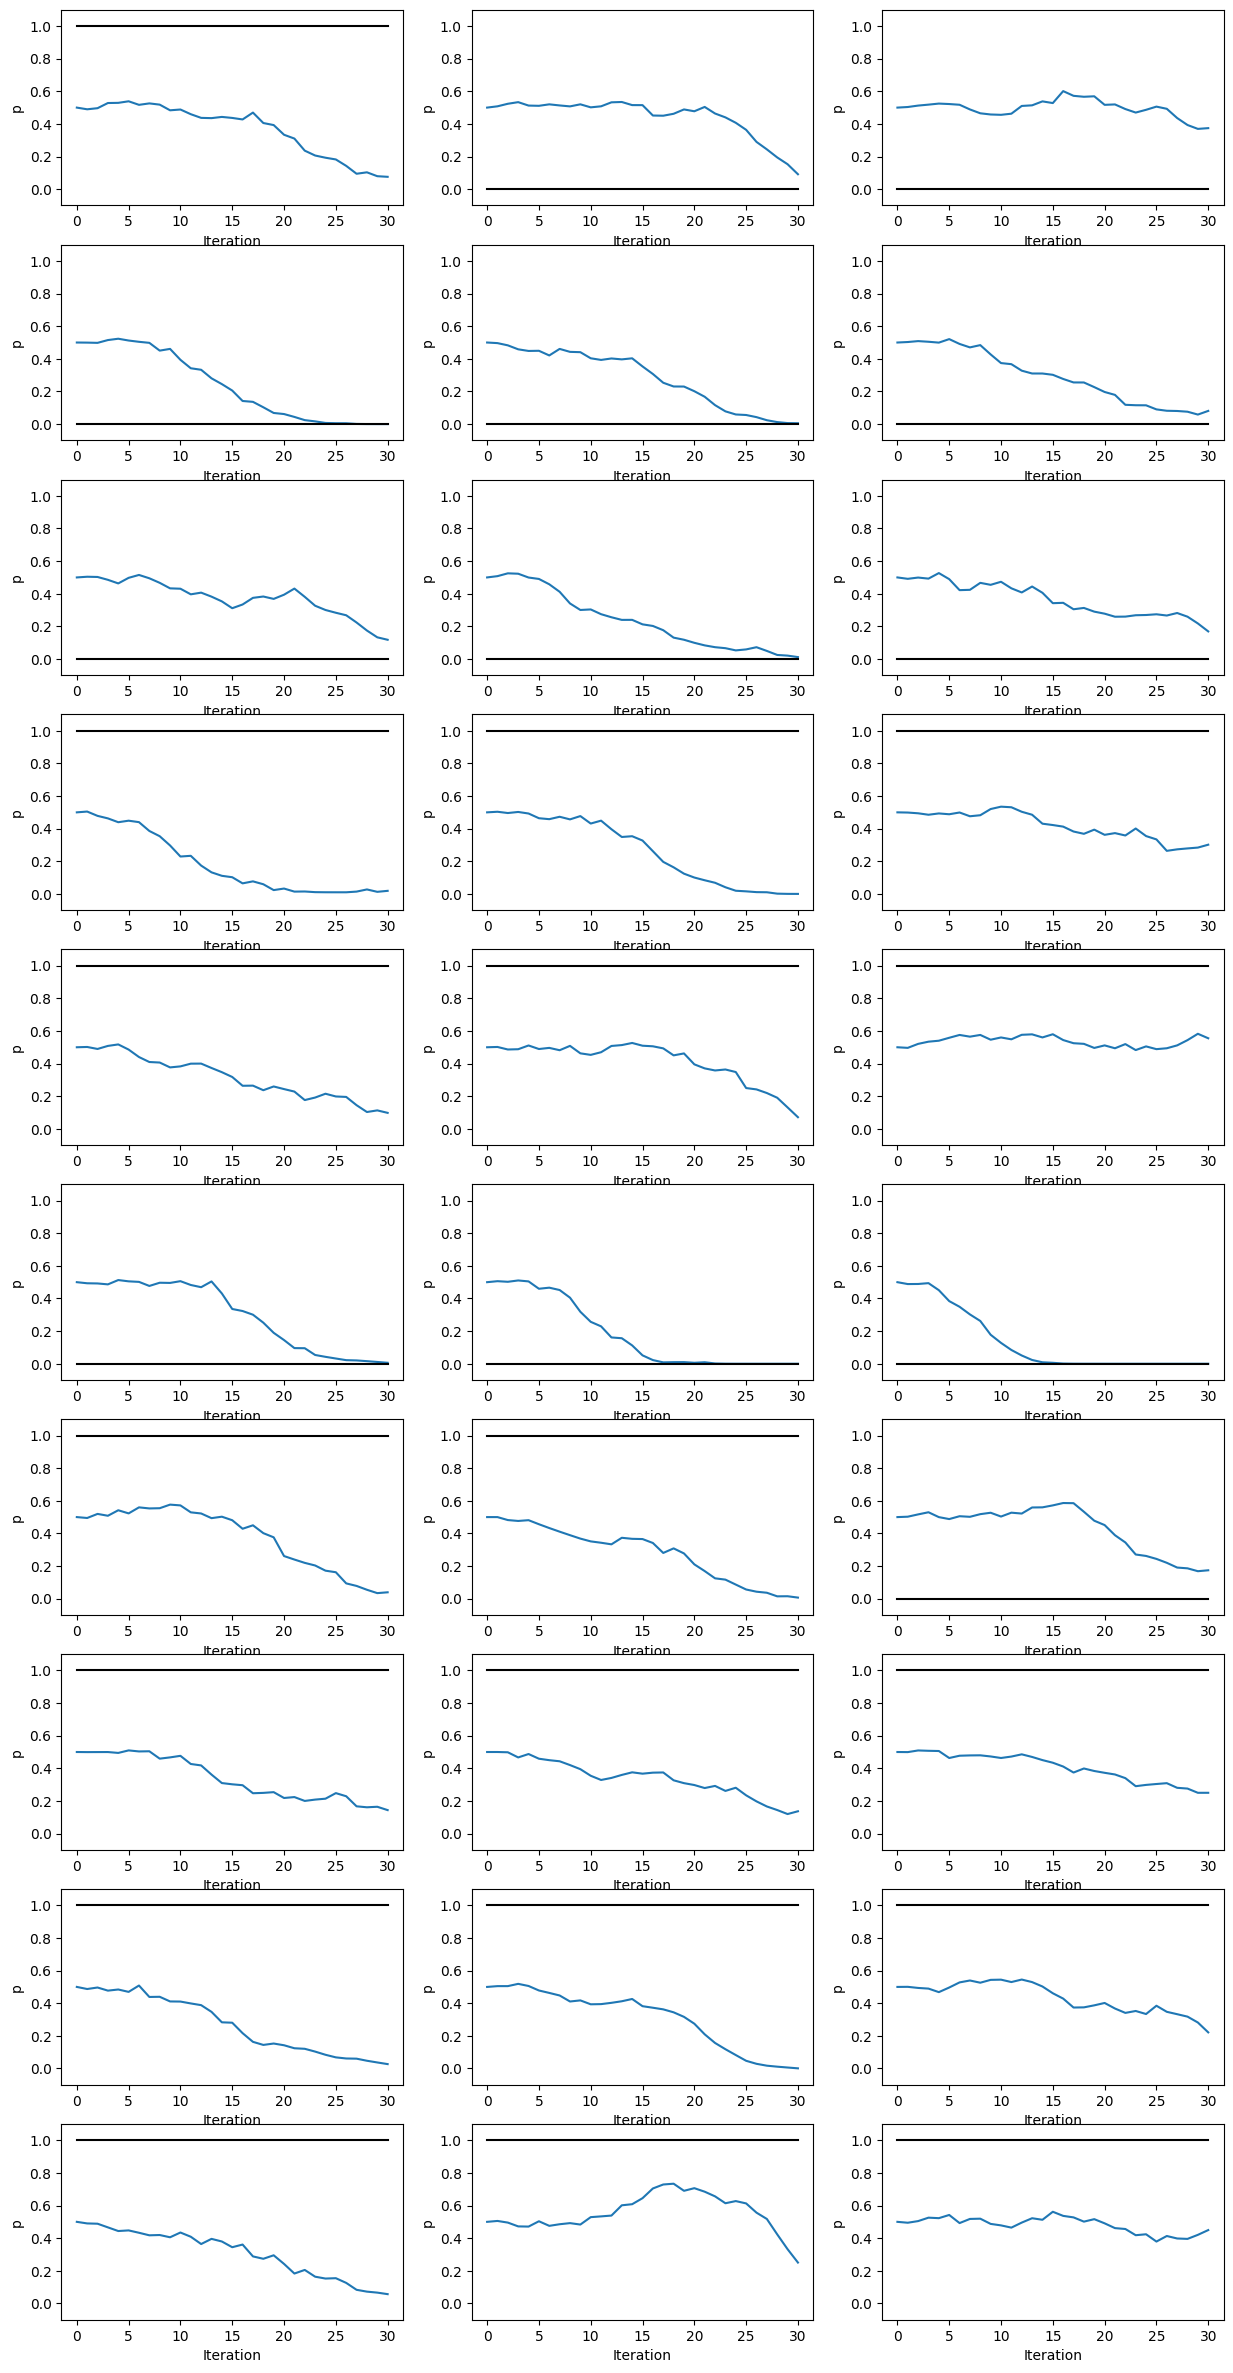

In [251]:

# For binomial
fig, ax = plt.subplots(10,3, figsize = (15,30))
for h in range(3):
    for i in range(10):
        for k in [0]:
            for j in [2]:
                ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]), graph_sampling_testing['p_distribution'][h,j,k,:,i])
                #A_est = graph_sampling_testing['thetas'][h,j,k][np.triu_indices(20,1)]
                #A_est[np.abs(A_est)<1e-3] = 0
                #ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]),[1-np.abs(np.sign(A_est[i]))]*61, color = 'orange')
        A_true = graph_sampling_testing['As'][h][np.triu_indices(10,1)]
        ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]),[1-np.abs(np.sign(A_true[i]))]*31, color = 'black')
        ax[i,h].set_xlabel('Iteration')
        ax[i,h].set_ylabel('p')
        ax[i,h].set_ylim((-0.1,1.1))


# # For exponential model
# nr_ce_itr = graph_sampling_testing['p_distribution'].shape[3]
# fig, ax = plt.subplots(20,3, figsize = (15,30))
# for h in range(3):
#     for i in range(20):
#         for k in [0]:
#             for j in [1]:
#                 ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]), graph_sampling_testing['p_distribution'][h,j,k,:,i])
#                 A_est = graph_sampling_testing['thetas'][h,j,k][np.triu_indices(20,1)]
#                 A_est[np.abs(A_est)<1e-3] = 0
#                 ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]),[0.1*np.abs(A_est[i])/np.max(np.abs(A_est))]*nr_ce_itr, color = 'orange')
#         A_true = graph_sampling_testing['As'][h][np.triu_indices(20,1)]
#         ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]),[0.1*np.abs(A_true[i])/np.max(np.abs(A_true))]*nr_ce_itr, color = 'black')
#         ax[i,h].set_xlabel('Iteration')
#         ax[i,h].set_ylabel('p')
#         ax[i,h].set_ylim((0,0.1))



Distribution of spectrum for each CE iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


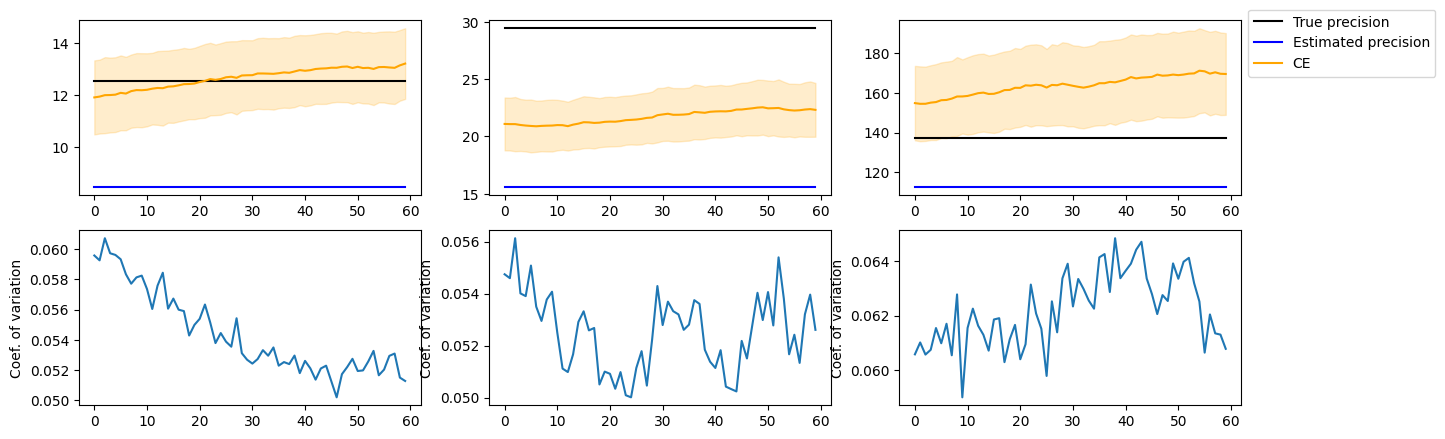

In [336]:
nr_ce_itr = graph_sampling_testing['eig_distribution'].shape[3]


nr_samples = graph_sampling_testing['eig_distribution'].shape[3]
fig, ax = plt.subplots(2,3, figsize = (15,5))
a = 1
k = 0
for h in range(3):
    mean = np.zeros(nr_samples)
    std = np.zeros(nr_samples)
    eigs = np.linalg.eigvals(graph_sampling_testing['thetas'][k,a,h])
    true_est = np.max(eigs)/np.min(eigs) 
    eigs = np.linalg.eigvals(graph_sampling_testing['As'][h])
    true = np.max(eigs)/np.min(eigs) 
    for i in range(nr_ce_itr):

        mean[i] = np.mean(np.max(graph_sampling_testing['eig_distribution'][k,a,h,i], axis = 1)/np.min(graph_sampling_testing['eig_distribution'][k,a,h,i], axis = 1))
        std[i] = np.std(np.max(graph_sampling_testing['eig_distribution'][k,a,h,i], axis = 1)/np.min(graph_sampling_testing['eig_distribution'][k,a,h,i], axis = 1))


    ax[0,h].plot(range(nr_samples), [true]*nr_samples, color = 'black', label = "True precision")
    ax[0,h].plot(range(nr_samples), [true_est]*nr_samples, color = 'blue', label = "Estimated precision")
    ax[0,h].plot(range(nr_samples), mean, color = 'orange', label = 'CE')
    ax[0,h].fill_between(range(nr_samples), mean + 2*std, mean - 2*std, alpha = 0.2, color = 'orange')
    ax[0,2].legend(bbox_to_anchor = (1,1.1))

    ax[1,h].plot(range(nr_samples),std/mean)
    ax[1,h].set_ylabel('Coef. of variation')



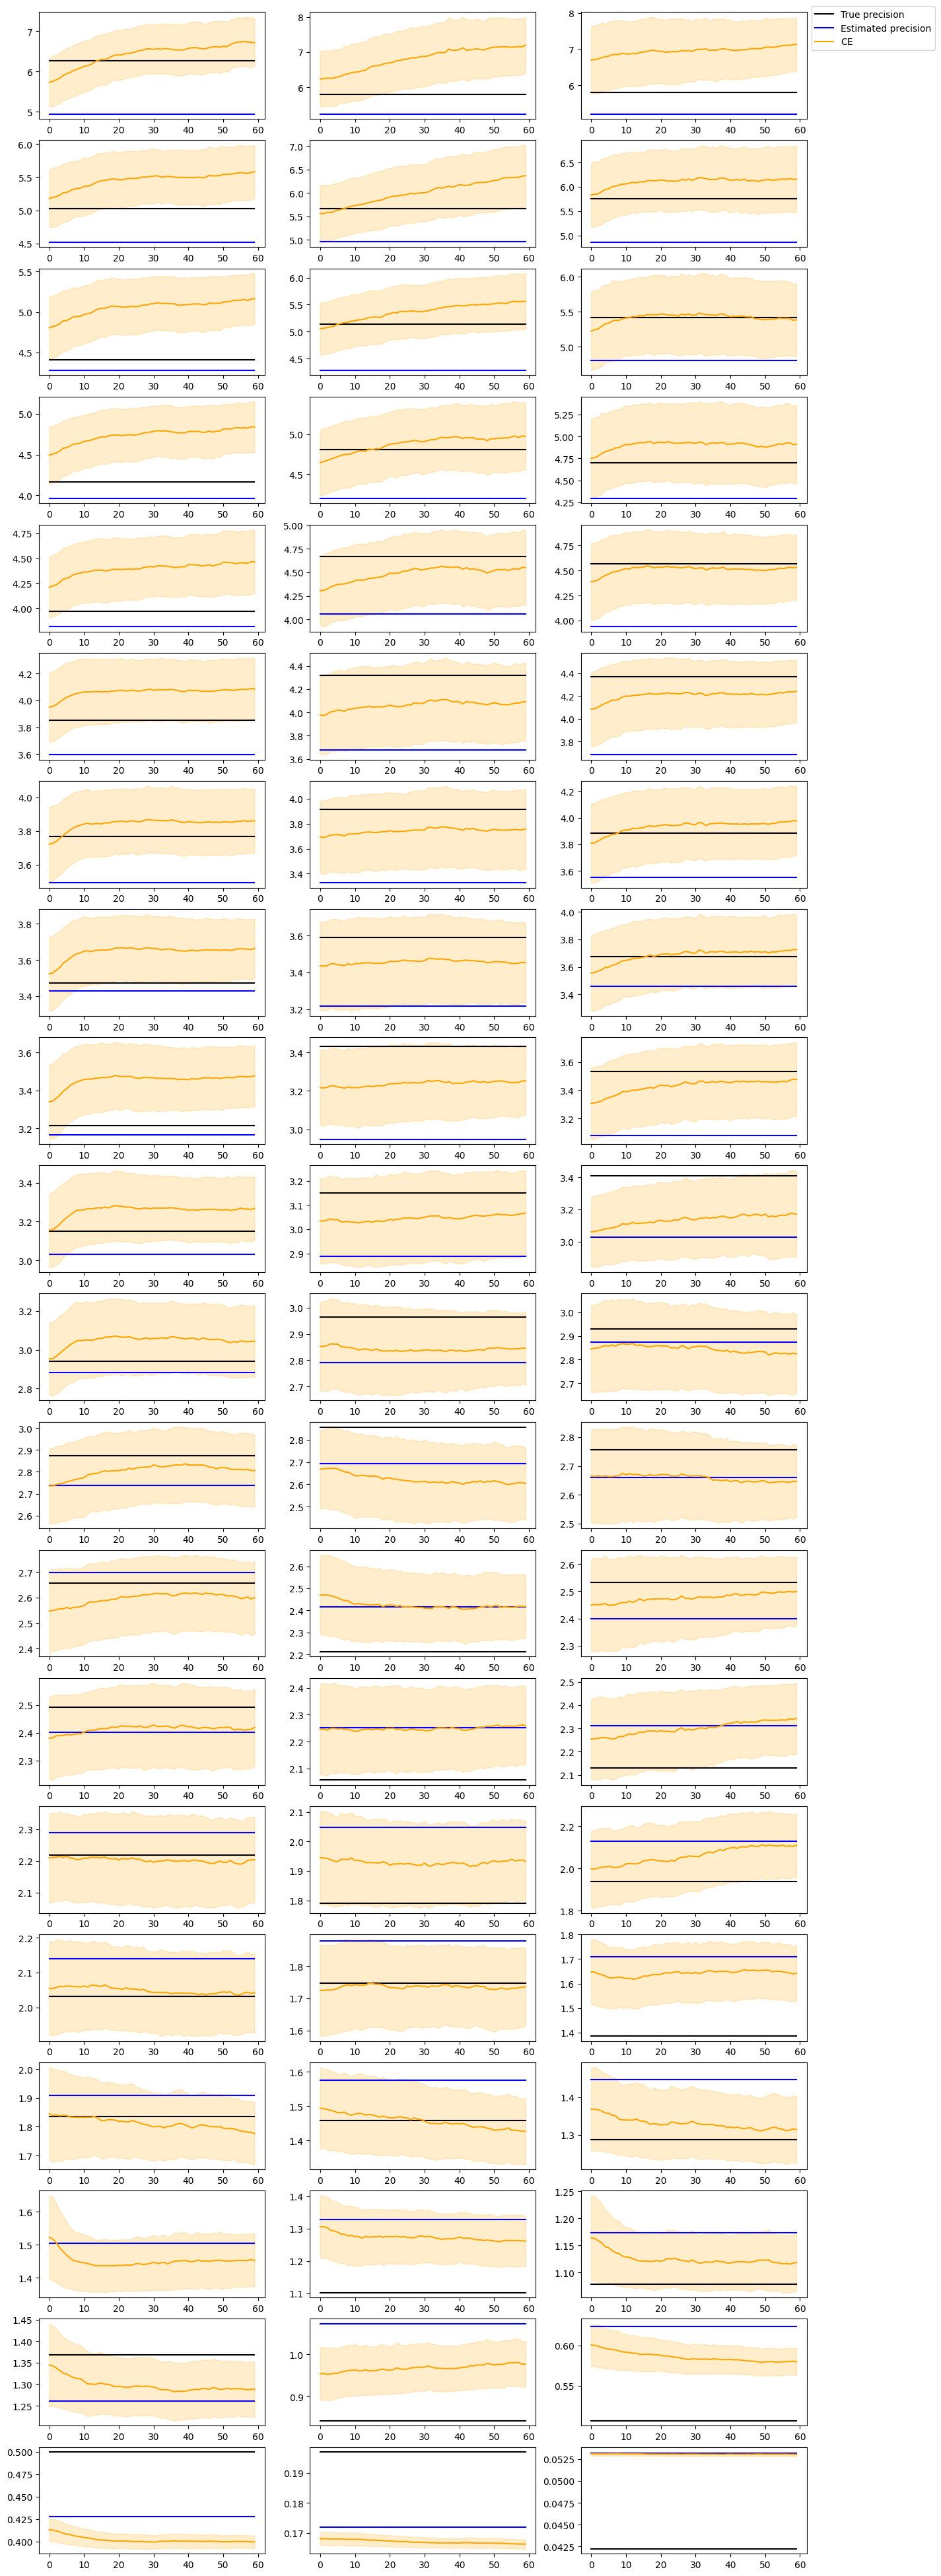

In [325]:



nr_ce_itr = graph_sampling_testing['eig_distribution'].shape[3]


nr_samples = graph_sampling_testing['eig_distribution'].shape[3]
fig, ax = plt.subplots(20,3, figsize = (15,50))
a = 2
k = 0

# Need to sort all eig...
eig_distribution = graph_sampling_testing['eig_distribution'][k,a].copy()
for h in range(eig_distribution.shape[0]):
    for i in  range(eig_distribution.shape[1]):
        for j in  range(eig_distribution.shape[2]):
            eig_distribution[h,i,j] = sorted(eig_distribution[h,i,j])


for j in range(1,21):
    for h in range(3):
        mean = np.zeros(nr_samples)
        std = np.zeros(nr_samples)
        eigs_est = np.linalg.eigvals(graph_sampling_testing['thetas'][k,a,h])
        true_est = sorted(eigs_est)[-j]
        eigs = np.linalg.eigvals(graph_sampling_testing['As'][h])
        true = sorted(eigs)[-j] 
        for i in range(nr_ce_itr):
            mean[i] = np.mean(eig_distribution[h,i,:,-j])
            std[i] = np.std(eig_distribution[h,i,:,-j])


        ax[j-1,h].plot(range(nr_samples), [true]*nr_samples, color = 'black', label = "True precision")
        ax[j-1,h].plot(range(nr_samples), [true_est]*nr_samples, color = 'blue', label = "Estimated precision")
        ax[j-1,h].plot(range(nr_samples), mean, color = 'orange', label = 'CE')
        ax[j-1,h].fill_between(range(nr_samples), mean + 2*std, mean - 2*std, alpha = 0.2, color = 'orange')
        #ax[j-1,h].set_ylim((0,7))
        if j == 1 and h == 2:
            ax[j-1,h].legend(bbox_to_anchor = (1,1.1))


    




Coef of variation

Plot graph and p next to each other.


In [252]:
P = np.zeros(graph_sampling_testing['thetas'].shape)
d = graph_sampling_testing['thetas'].shape[3]
for i in range(graph_sampling_testing['thetas'].shape[0]):
    for j in range(graph_sampling_testing['thetas'].shape[1]):
        for k in range(graph_sampling_testing['thetas'].shape[2]):
            P[i,j,k][ np.triu_indices(d,1)] = graph_sampling_testing['p_distribution'][i,j,k,15]
            P[i,j,k] =  P[i,j,k] +  P[i,j,k].T
            np.fill_diagonal(P[i,j,k],0)

In [253]:

sample_nr = {0:58, 1:58, 2:58}

alphas = graph_sampling_testing['alphas']
kappas = graph_sampling_testing['kappas']

B = 1000
d = graph_sampling_testing['thetas'][k_cnt,a_cnt,0].shape[0]
thetas_sim = np.zeros((len(kappas), len(alphas), 3,B, d, d))
pbar = tqdm.tqdm(total = len(alphas)*len(kappas))
for k in range(len(kappas)):
    for a in range(len(alphas)):
        for i in range(3):
            for b in range(B):
                # Bern
                # p = scipy.stats.bernoulli.rvs(p = graph_sampling_testing['p_distribution'][k,a,i,sample_nr[i]], size = len(graph_sampling_testing['p_distribution'][k,a,i,sample_nr[i]]))    
                # reg_matrix = np.ones((d,d))*alphas[a]
                # reg_matrix[np.triu_indices(d,1)] = p*999999
                # reg_matrix = reg_matrix + reg_matrix.T
                # Expon 
                p = scipy.stats.expon.rvs(scale = graph_sampling_testing['p_distribution'][k_cnt,a_cnt,i,sample_nr[i]],  size = len(graph_sampling_testing['p_distribution'][k_cnt,a_cnt,i,sample_nr[i]]))    
                reg_matrix = np.zeros((d,d))
                reg_matrix[np.triu_indices(d,1)] = p
                reg_matrix = reg_matrix + reg_matrix.T
                # Normal 
                # p = scipy.stats.norm.rvs(loc = graph_sampling_testing['p_distribution'][k_cnt,a_cnt,i,sample_nr[i]], scale = 0.3*graph_sampling_testing['p_distribution'][k_cnt,a_cnt,i,sample_nr[i]],  size = len(graph_sampling_testing['p_distribution'][k_cnt,a_cnt,i,sample_nr[i]]))    
                # p[p<0] = 0
                # reg_matrix = np.zeros((d,d))
                # reg_matrix[np.triu_indices(d,1)] = p
                # reg_matrix = reg_matrix + reg_matrix.T
                gls = dg.sgl_inner_em(graph_sampling_testing['X'][100*i:100*(i+1)], max_iter = 500, lamda = reg_matrix, tol = 1e-3)
                gls.fit(nr_workers=1, lik_type="gaussian",verbose=False)
                thetas_sim[k,a,i,b] =  gls.theta[-1].copy()
        pbar.update()
pbar.close()

  0%|          | 0/12 [00:00<?, ?it/s]

IndexError: index 58 is out of bounds for axis 3 with size 31

In [340]:
# graph_sampling_testing['thetas_sim'] = thetas_sim
# with open(f'../data/GraphHypTest/local_change_rnr0_0.8_model_expon_alphaCE_False_boot_False.pkl', 'wb') as handle:
#     pickle.dump(graph_sampling_testing, handle, protocol=pickle.HIGHEST_PROTOCOL)


<AxesSubplot: >

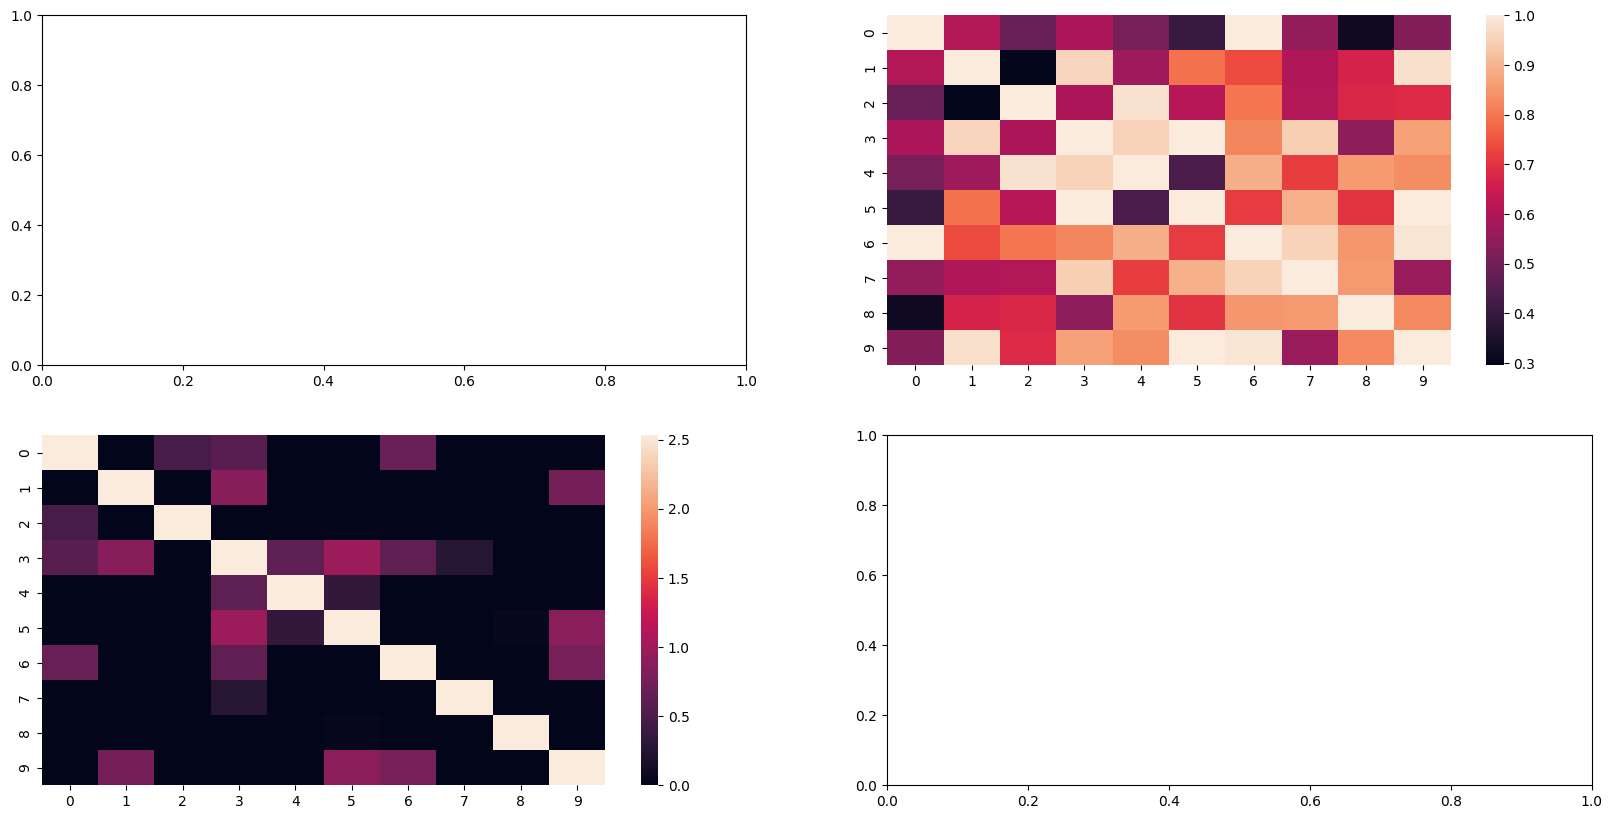

In [255]:
fig, ax = plt.subplots(2,2, figsize =(20,10))
#sns.heatmap(graph_sampling_testing['thetas'][k_cnt,a_cnt,0], ax = ax[0,0])
P_tmp = P[2,0,0]
sns.heatmap(1-P_tmp, ax = ax[0,1])
sns.heatmap(graph_sampling_testing['As'][0], ax = ax[1,0])
#sns.heatmap(np.std(thetas_sim[0,0,0,:], axis = 0 ), ax = ax[1,1])

Look at std false positive, true positive, false negative, true negative.

In [118]:
# True positive
theta_est = graph_sampling_testing['thetas'][2,2,0].copy()
A_true = graph_sampling_testing['As'][0].copy()
d = A_true.shape[0]
std = np.std(thetas_sim, axis = 0 )[np.triu_indices(d,1)]
theta_est[np.abs(theta_est)<1e-3] = 0
bool_lis = np.where((theta_est[np.triu_indices(d,1)] == 0) & (A_true[np.triu_indices(d,1)] == 0))
plt.hist(std[bool_lis])

IndexError: index 3 is out of bounds for axis 0 with size 3

(array([13.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([6.65913301e-08, 4.45113209e-04, 8.90159828e-04, 1.33520645e-03,
        1.78025306e-03, 2.22529968e-03, 2.67034630e-03, 3.11539292e-03,
        3.56043954e-03, 4.00548615e-03, 4.45053277e-03]),
 <BarContainer object of 10 artists>)

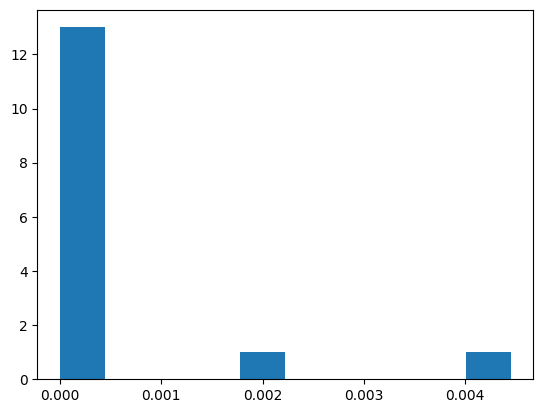

In [ ]:
# False positive
theta_est = graph_sampling_testing['thetas'][2,2,0].copy()
A_true = graph_sampling_testing['As'][0].copy()
d = A_true.shape[0]
std = np.std(thetas_sim, axis = 0 )[np.triu_indices(d,1)]
theta_est[np.abs(theta_est)<1e-3] = 0
bool_lis = np.where((theta_est[np.triu_indices(d,1)] == 0) & (A_true[np.triu_indices(d,1)] != 0))
plt.hist(std[bool_lis])

(array([14.,  9.,  4.,  3.,  5., 10.,  1.,  1.,  0.,  2.]),
 array([1.02960653e-06, 3.24028390e-02, 6.48046485e-02, 9.72064579e-02,
        1.29608267e-01, 1.62010077e-01, 1.94411886e-01, 2.26813696e-01,
        2.59215505e-01, 2.91617315e-01, 3.24019124e-01]),
 <BarContainer object of 10 artists>)

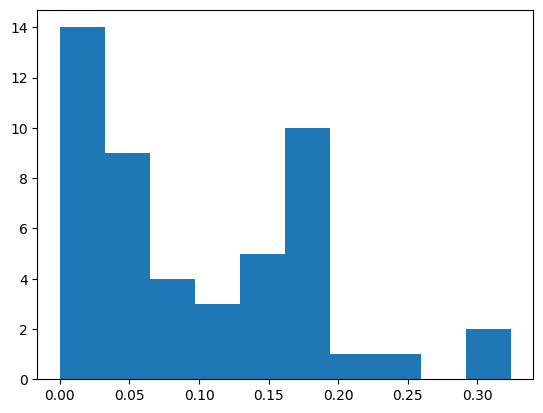

In [ ]:
# True negative
theta_est = graph_sampling_testing['thetas'][2,2,0].copy()
A_true = graph_sampling_testing['As'][0].copy()
d = A_true.shape[0]
std = np.std(thetas_sim, axis = 0 )[np.triu_indices(d,1)]
theta_est[np.abs(theta_est)<1e-3] = 0
bool_lis = np.where((theta_est[np.triu_indices(d,1)] != 0) & (A_true[np.triu_indices(d,1)] != 0))
plt.hist(std[bool_lis])

(array([16.,  8.,  5.,  2.,  1.,  0.,  2.,  1.,  2.,  1.]),
 array([4.55145419e-07, 7.48451907e-03, 1.49685830e-02, 2.24526469e-02,
        2.99367108e-02, 3.74207747e-02, 4.49048387e-02, 5.23889026e-02,
        5.98729665e-02, 6.73570304e-02, 7.48410943e-02]),
 <BarContainer object of 10 artists>)

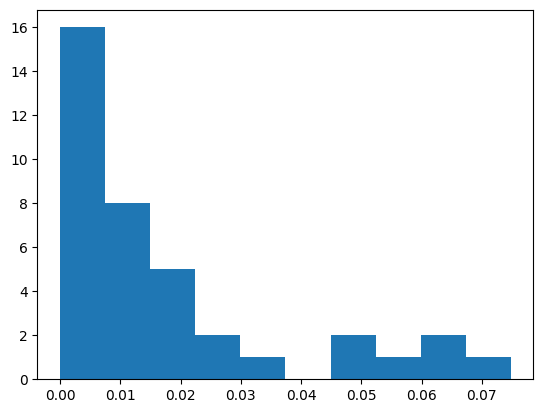

In [ ]:
# False negative
theta_est = graph_sampling_testing['thetas'][2,2,0].copy()
A_true = graph_sampling_testing['As'][0].copy()
d = A_true.shape[0]
std = np.std(thetas_sim, axis = 0 )[np.triu_indices(d,1)]
theta_est[np.abs(theta_est)<1e-3] = 0
bool_lis = np.where((theta_est[np.triu_indices(d,1)] != 0) & (A_true[np.triu_indices(d,1)] == 0))
plt.hist(std[bool_lis])

Std for low vs high values.

In [185]:
theta_est = graph_sampling_testing['thetas'][2,2,0].copy()
theta_est[np.abs(theta_est)<1e-3] = 0
theta_u = theta_est[np.triu_indices(d,1)]
std_u = np.std(thetas_sim, axis = 0 )[np.triu_indices(d,1)]

plt.boxplot([std_u[np.abs(theta_u) == 0], std_u[(np.abs(theta_u) < 0.3) & (np.abs(theta_u) > 0)], std_u[np.abs(theta_u) >= 0.3]])

IndexError: index 3 is out of bounds for axis 0 with size 3

In [256]:
graph_sampling_testing['thetas_sim'].shape

(3, 4, 30, 1000, 3, 10, 10)

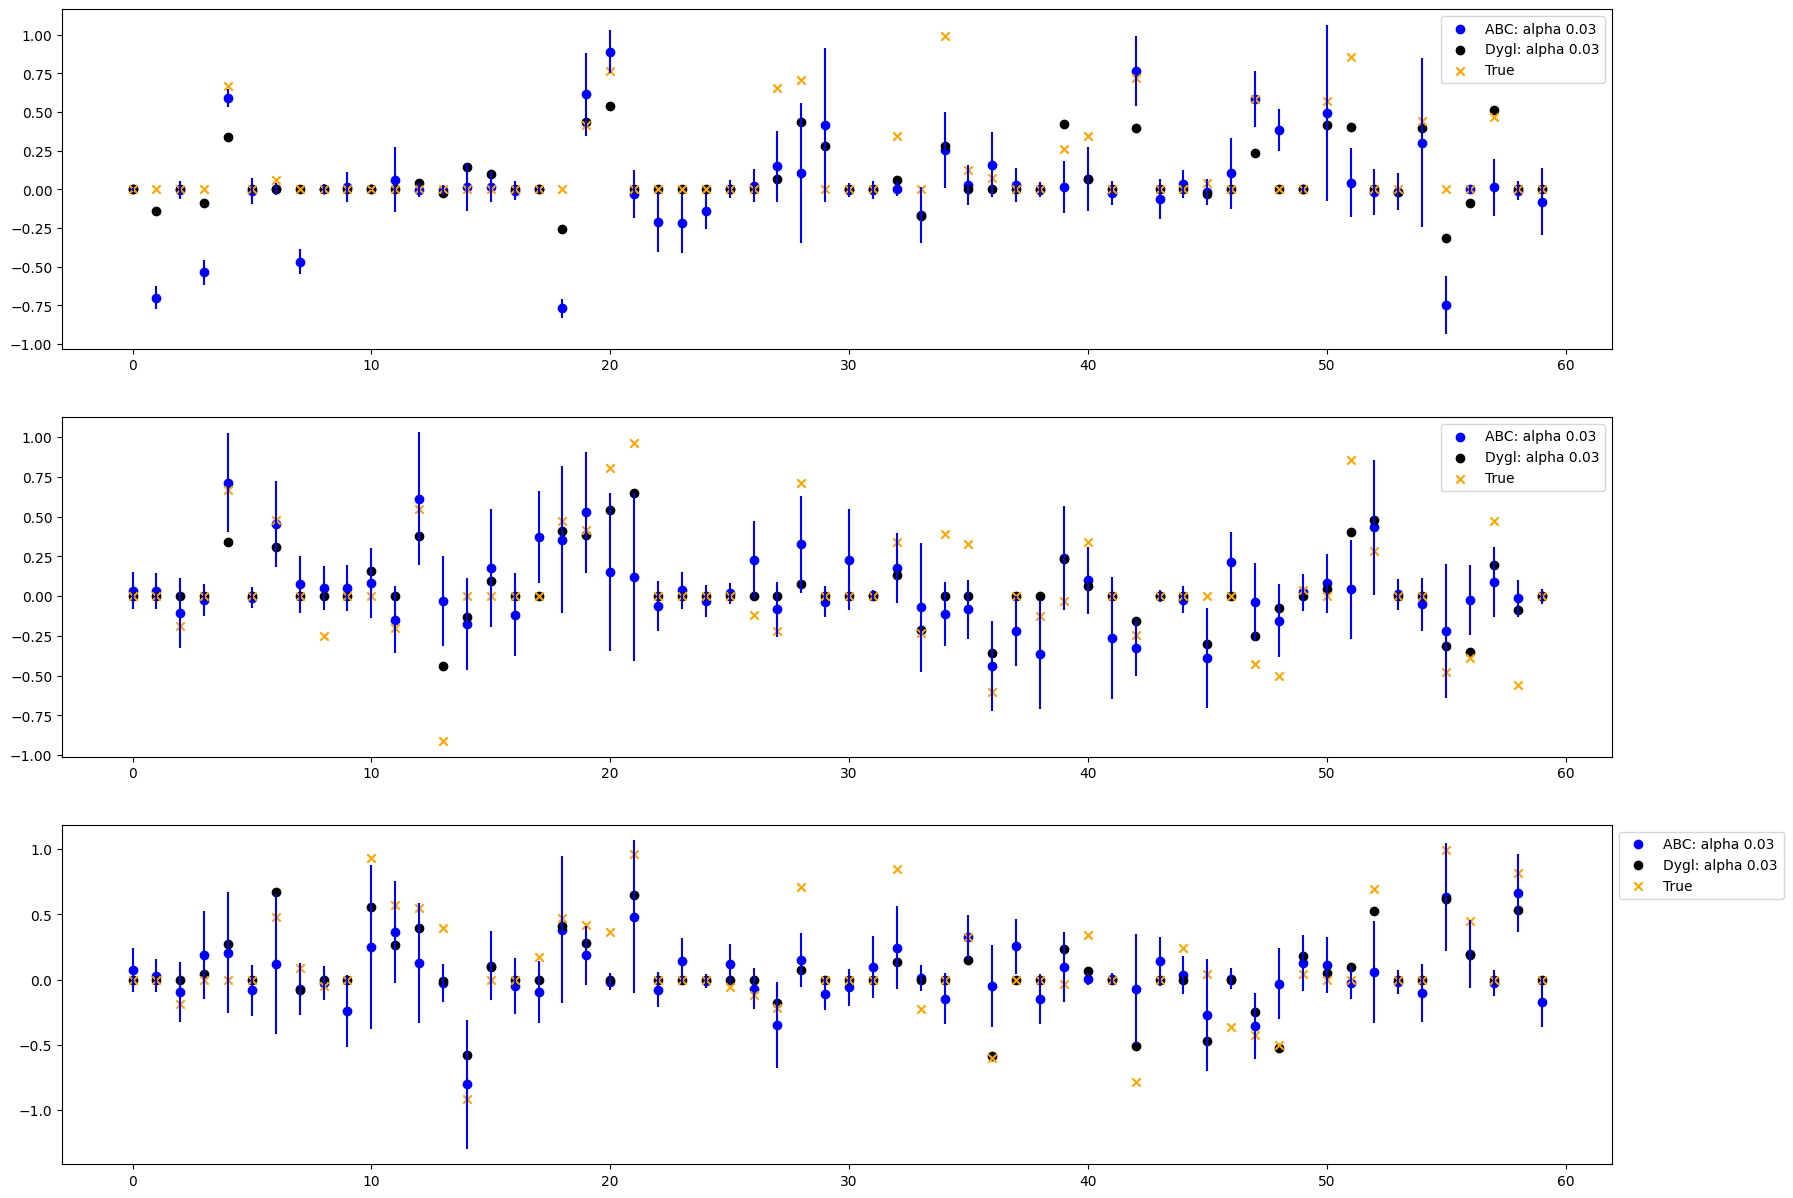

In [341]:

fig, ax = plt.subplots(3,1, figsize = (20,15))

colors = ['blue', 'red', 'green', 'pink', 'yellow']

#for a in range(len(alphas)):
a = 1
k = 0
for h in range(3):
    theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
    theta_est[np.abs(theta_est)<1e-3] = 0
    theta_u = theta_est[np.triu_indices(d,1)]
    mean_u = np.mean(thetas_sim[k,a,h,:], axis = 0 )[np.triu_indices(d,1)]
    std_u = np.std(thetas_sim[k,a,h,:], axis = 0 )[np.triu_indices(d,1)]
    A_true_u = graph_sampling_testing['As'][h].copy()[np.triu_indices(d,1)]


    ax[h].scatter(0, mean_u[0], label =f'ABC: alpha {np.round(alphas[a],2)}', color = 'blue')
    ax[h].scatter(0, theta_u[0], label =f'Dygl: alpha {np.round(alphas[a],2)}', color = 'black')
    ax[h].scatter(0, A_true_u[0], marker = 'x', label ='True', color = 'orange')
    ax[h].errorbar(0, mean_u[0], 2*std_u[0], color = 'blue')

    ax[h].legend(bbox_to_anchor = (1,1))

    for i in range(1, 60):
        ax[h].scatter(i, mean_u[i], label =f'alpha {np.round(alphas[a],2)} ABC', color = 'blue')
        ax[h].scatter(i, theta_u[i], label =f'alpha {np.round(alphas[a],2)}  Dygl', color = 'black')
        ax[h].scatter(i, A_true_u[i], marker = 'x', label ='True', color = 'orange')
        ax[h].errorbar(i, mean_u[i], 2*std_u[i], color = 'blue')

Text(0.5, 1.0, 'kappa 0.1')

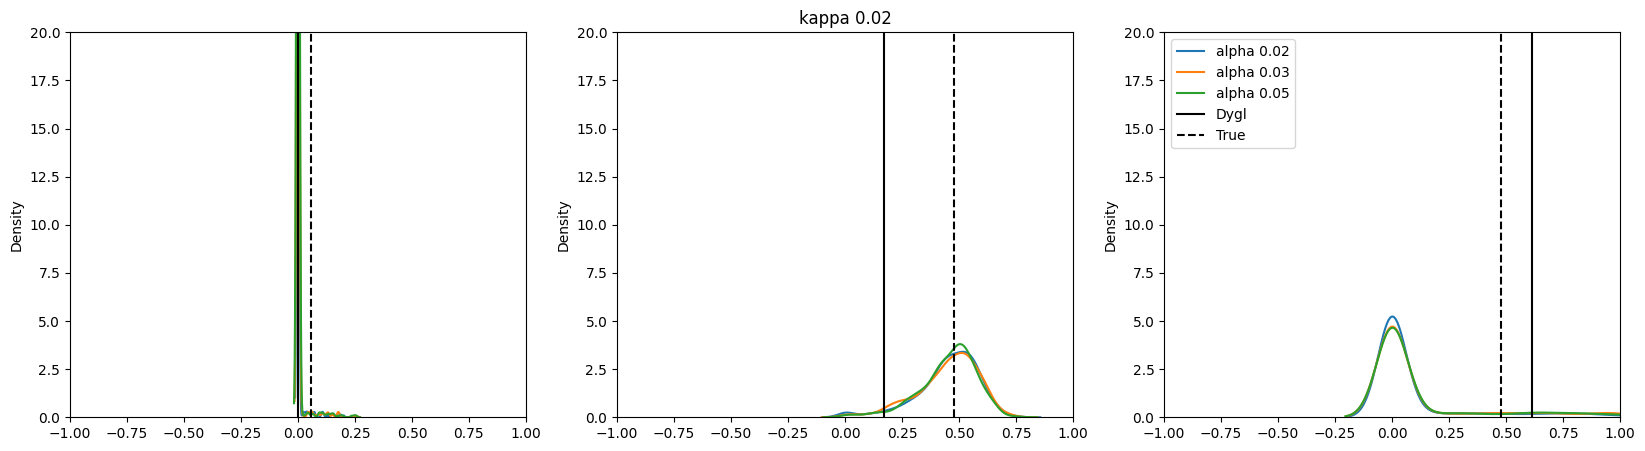

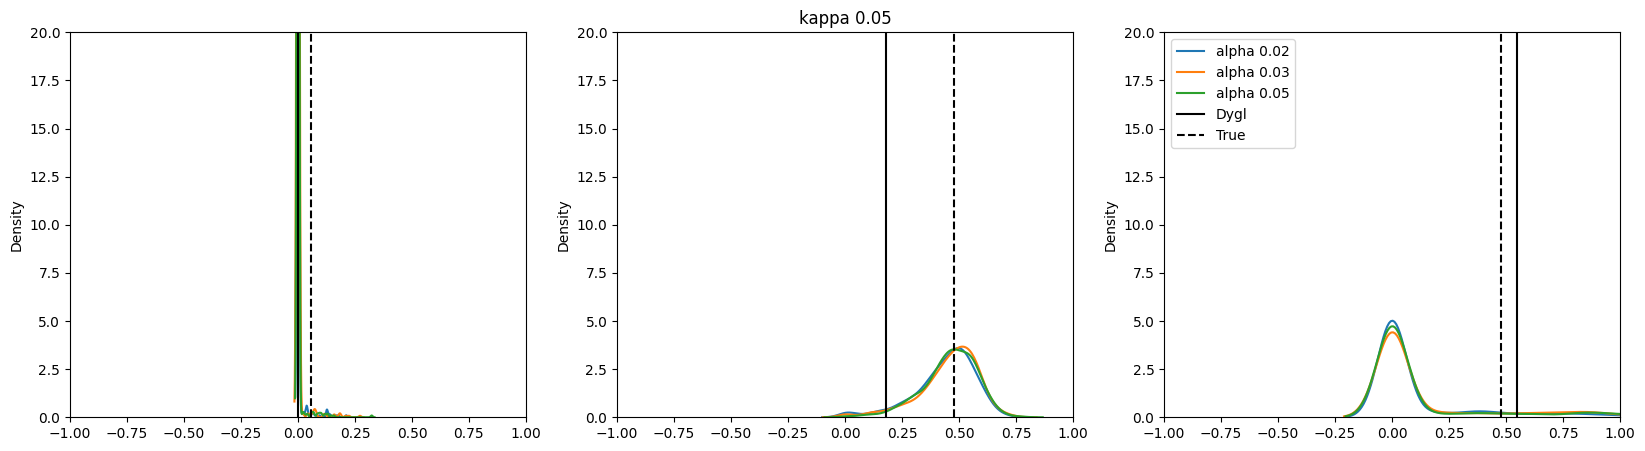

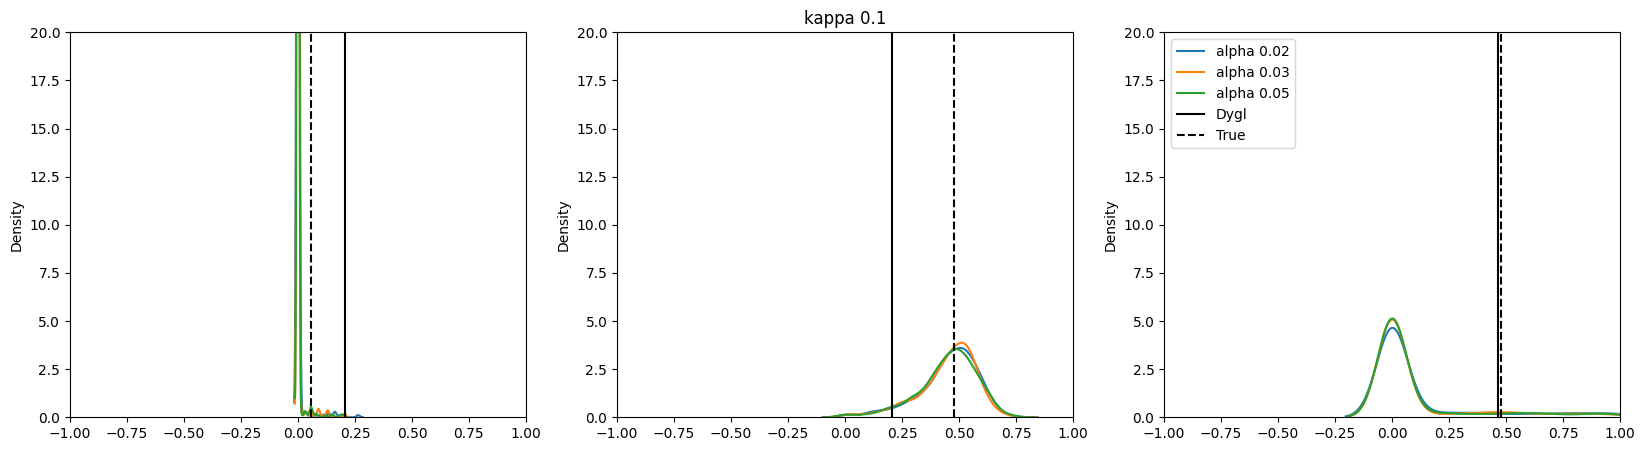

In [344]:
# (0,5) 


xlim = (-1,1)
i = 0
j = 7


As = graph_sampling_testing['As']
fig, ax = plt.subplots(1,3, figsize = (20, 5))
k = 0
for h in range(3):
    for a in range(len(graph_sampling_testing['alphas'])):
        theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
        theta_est[np.abs(theta_est)<1e-3] = 0
        sns.kdeplot(thetas_sim[k,a,h,:,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}')
    ax[h].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black')
    ax[h].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
    ax[h].set_ylim((0,20))
    ax[h].set_xlim(xlim)
ax[2].legend()
ax[1].set_title(f'kappa {graph_sampling_testing["kappas"][k]}')

fig, ax = plt.subplots(1,3, figsize = (20, 5))
k = 1
for h in range(3):
    for a in range(len(graph_sampling_testing['alphas'])):
        theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
        theta_est[np.abs(theta_est)<1e-3] = 0
        sns.kdeplot(thetas_sim[k,a,h,:,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}')
    ax[h].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black')
    ax[h].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
    ax[h].set_ylim((0,20))
    ax[h].set_xlim(xlim)
ax[2].legend()
ax[1].set_title(f'kappa {graph_sampling_testing["kappas"][k]}')

fig, ax = plt.subplots(1,3, figsize = (20, 5))
k = 2
for h in range(3):
    for a in range(len(graph_sampling_testing['alphas'])):
        theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
        theta_est[np.abs(theta_est)<1e-3] = 0
        sns.kdeplot(thetas_sim[k,a,h,:,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}')
    ax[h].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black')
    ax[h].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
    ax[h].set_ylim((0,20))
    ax[h].set_xlim(xlim)
ax[2].legend()
ax[1].set_title(f'kappa {graph_sampling_testing["kappas"][k]}')



# mean_u = np.mean(thetas_sim[k,a,h,:], axis = 0 )
# std_u = np.std(thetas_sim[k,a,h,:], axis = 0 )
# A_true_u = graph_sampling_testing['As'][h].copy()[np.triu_indices(d,1)]

plot a some edge paths

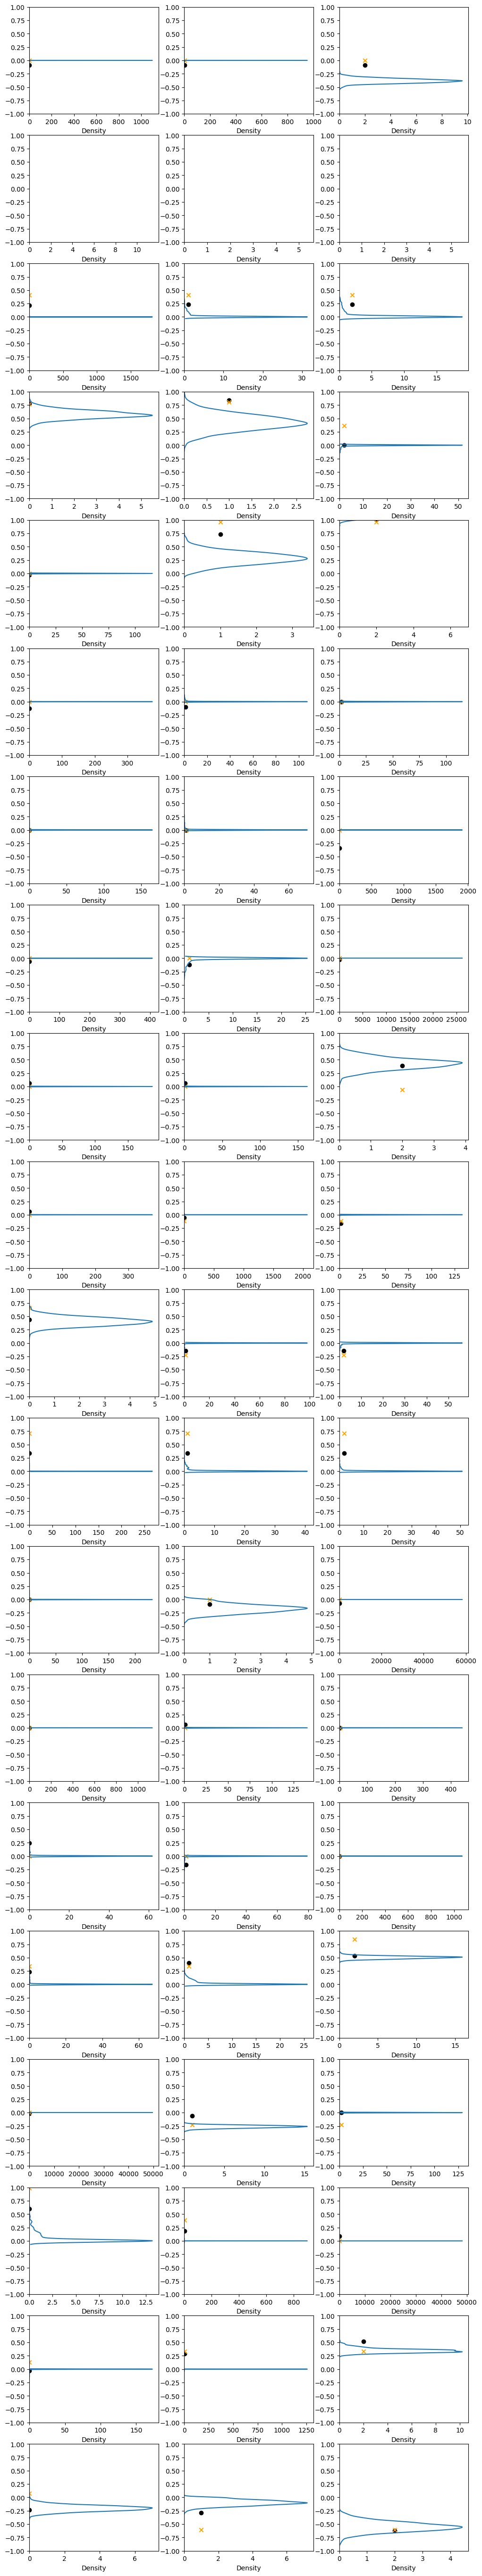

In [305]:




k = 0
a = 1

theta_est = graph_sampling_testing['thetas'][k,a].copy()
As = np.array(graph_sampling_testing['As'])
theta_est[np.abs(theta_est)<1e-3] = 0
std_u = np.std(thetas_sim[k,a,:], axis = 1 )

fig, ax = plt.subplots(20,3, figsize = (12,70))
n_i = 1
for n_j in range(0,20):
    for h in range(3):
        ax[n_j,h].scatter([h], theta_est[h,n_i,n_j], label ='Estimate', color = 'black')
        ax[n_j,h].scatter([h], As[h,n_i,n_j], label ='True', color = 'orange', marker = 'x' )
        sns.kdeplot(y = thetas_sim[k,a,h,:,n_i,n_j], ax = ax[n_j,h])
        ax[n_j,h].set_ylim((-1,1))
    #ax.legend()

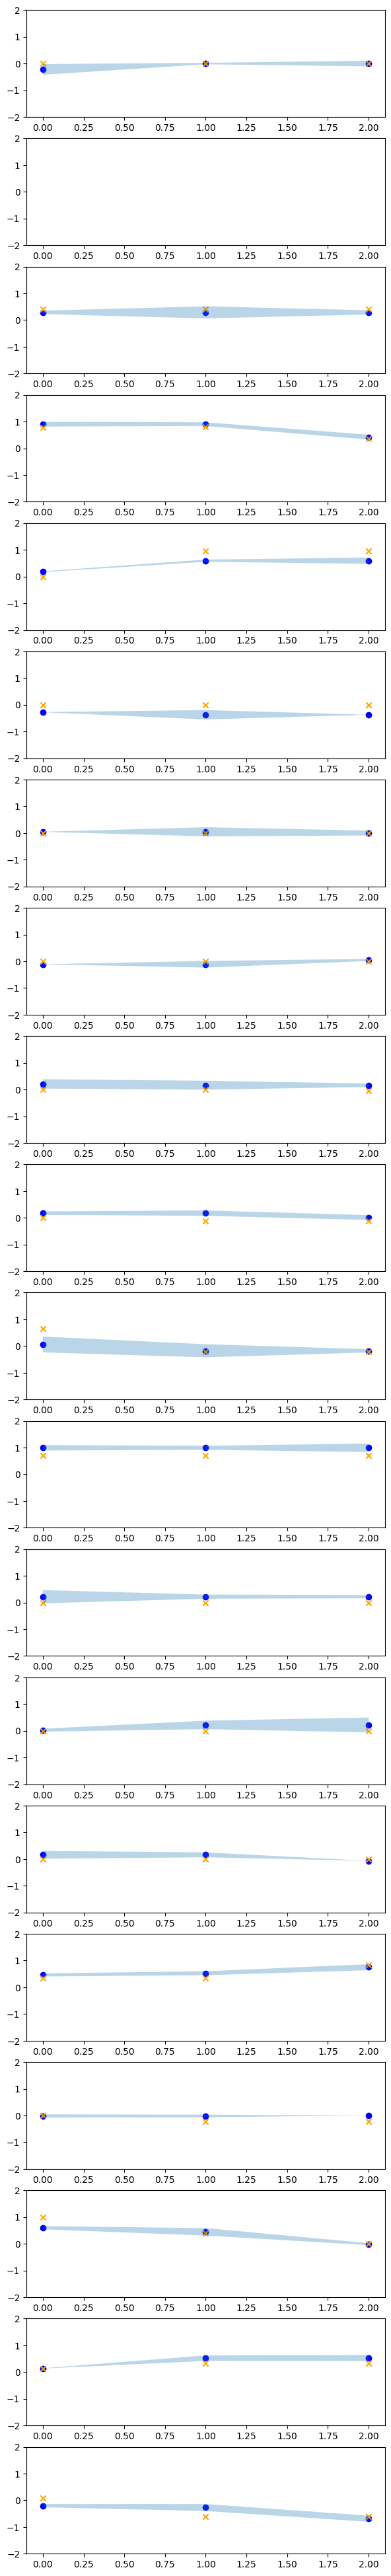

In [265]:
k = 0
a = 0

theta_est = graph_sampling_testing['thetas'][k,a].copy()
As = np.array(graph_sampling_testing['As'])
theta_est[np.abs(theta_est)<1e-3] = 0
std_u = np.std(thetas_sim[k,a,:], axis = 1 )
A_true_u = graph_sampling_testing['As'][0].copy()[np.triu_indices(d,1)]

fig, ax = plt.subplots(20,1, figsize = (7,50))
n_i = 1
for n_j in range(0,20):

    ax[n_j].scatter([0,1,2], theta_est[:,n_i,n_j], label ='Estimate', color = 'blue')
    ax[n_j].scatter([0,1,2], As[:,n_i,n_j], label ='True', color = 'orange', marker = 'x' )
    ax[n_j].fill_between([0,1,2],theta_est[:,n_i,n_j]-2*std_u[:,n_i,n_j] ,theta_est[:,n_i,n_j]+2*std_u[:,n_i,n_j], alpha = 0.3)
    ax[n_j].set_ylim((-2,2))
    #ax.legend()



In [132]:
theta_est = graph_sampling_testing['thetas'][4,4,0].copy()
theta_est[np.abs(theta_est)<1e-3] = 0
theta_u = theta_est[np.triu_indices(d,1)]
std_u = np.std(thetas_sim, axis = 0 )[np.triu_indices(d,1)]
A_true_u = graph_sampling_testing['As'][0].copy()[np.triu_indices(d,1)]

fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.scatter(0, theta_u[0], label ='Estimate', color = 'blue')
ax.scatter(0, A_true_u[0], marker = 'x', label ='True', color = 'orange')
ax.errorbar(0, theta_u[0], 2*std_u[0], color = 'blue')
ax.legend()

for i in range(1, 60):
    ax.scatter(i, theta_u[i], color = 'blue')
    ax.scatter(i, A_true_u[i], marker = 'x', color = 'orange')
    ax.errorbar(i, theta_u[i], 2*std_u[i], color = 'blue')

IndexError: index 4 is out of bounds for axis 0 with size 3

In [274]:
np.sum((A_true_u <theta_u+2*std_u) & (A_true_u >theta_u-2*std_u) )/len((A_true_u <theta_u+2*std_u))

ValueError: operands could not be broadcast together with shapes (190,) (3,20,20) 

# Distribution under the null


In [3]:
d = 50
s = 0.3
As = gen_all_all_zero(d,s)

In [5]:
len([i for i in range(500,1800)])/20

65.0

In [43]:
np.exp(-np.linspace(3.5, 1,20))

array([0.03019738, 0.03444398, 0.03928777, 0.04481272, 0.05111465,
       0.05830279, 0.0665018 , 0.07585381, 0.08652097, 0.09868824,
       0.11256657, 0.12839657, 0.14645272, 0.16704807, 0.19053969,
       0.2173349 , 0.24789826, 0.28275969, 0.32252361, 0.36787944])

In [4]:

cov_true1 = np.linalg.inv(As[0])
cov_true2 = np.linalg.inv(As[2])
X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true1, size = 100)
X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true2, size = 100)

out = HDtest.testCov(X1,X2,method = 'CLX')
out = dict(zip(out.names, list(out)))
out

{'statistics': array([23.73381939]),
 'p.value': array([0.00176808]),
 'alternative': array(['two.sided'], dtype='<U9'),
 'method': array(['Two-Sample CLX test'], dtype='<U19'),
 'data.name': array(['structure(c(-0.0310242931931308, -0.613065040377813, 0.457099202962966,  and structure(c(-1.102433724493, 0.147407186722494, 0.157950459280688, ',
        '-0.559045541330947, -0.562077013772041, 0.901282541837721, 0.0240343611631735,  and 1.08146465809996, 0.0690380116525647, 0.01105661444502, 0.572653507984666, ',
        '0.308558012615719, 0.48326001085759, -0.175910651578174, -0.378311964363161,  and 0.768566493960613, 0.0595918965808831, -0.22427369884945, -0.574412710999814, ',
        ...,
        '0.0243624671190961), .Dim = c(100L, 50L)) and -0.0692883184075226, 0.0599001658088842, 0.433835475392711, -0.452175088169699, ',
        'structure(c(-0.0310242931931308, -0.613065040377813, 0.457099202962966,  and 0.28429423214151, -0.16603268501606, -0.232930642914499), .Dim = c(100L, 

In [5]:
my_hdtest(X1, np.cov(X1.T)*(X1.shape[0]-1)/X1.shape[0], X2, np.cov(X2.T)*(X1.shape[0]-1)/X1.shape[0])

(3.6783786198535395e-05, 17.196698592741757)

In [17]:
d = 200
s = 0.3
As = gen_all_all_zero(d,s)
nr_sims = 10000
test_stat = np.zeros(nr_sims)
test_stat_R = np.zeros(nr_sims)

cov_true = np.linalg.inv(As[0])
pbar = tqdm.tqdm(total = nr_sims)

for i in range(nr_sims):
    # Generate Data
    X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true, size = 1000)
    X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true, size = 1000)

    #out = HDtest.testCov(X1,X2,method = 'CLX')
    #out = dict(zip(out.names, list(out)))
    #out

    p,test_stat[i] = my_hdtest(X1, np.cov(X1.T)*(X1.shape[0]-1)/X1.shape[0], X2, np.cov(X2.T)*(X2.shape[0]-1)/X2.shape[0]) # out['statistics'][0] #
    #out = HDtest.testCov(X1,X2,method = 'CLX')
    #out = dict(zip(out.names, list(out)))
    #test_stat_R[i] = out['statistics'][0]
    pbar.update()
pbar.close()

100%|██████████| 10000/10000 [31:45<00:00,  5.25it/s] 


In [8]:
def dens_f(t):
    const = 1/(np.sqrt(8*np.pi))

    return np.exp(-const*np.exp(-t/2))* np.exp(-t/2)*const*0.5

dens_f = np.vectorize(dens_f)

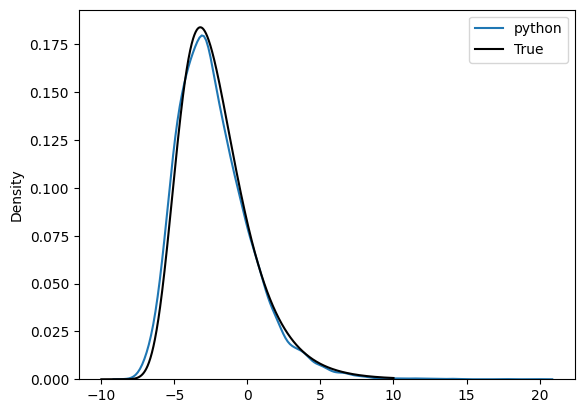

In [19]:
sns.kdeplot(test_stat, label = "python")
plt.plot(np.linspace(-10,10,1000),dens_f(np.linspace(-10,10,1000)), label = 'True', color = 'black')
plt.legend()

Distribution with lasso

In [5]:
d = 20
s = 0.3
As = gen_all_all_zero(d,s)
nr_sims = 5000
alphas = np.linspace(0,0.2,21)
test_stat = np.zeros((len(alphas), nr_sims))

cov_true = np.linalg.inv(As[0])
pbar = tqdm.tqdm(total = nr_sims*len(alphas))

for j in range(len(alphas)):
    for i in range(nr_sims):
        # Generate Data
        X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true, size = 1000)
        X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true, size = 1000)

        dgl_out_1 = dg.sgl(100, alphas[j])
        dgl_out_1.fit(X1, lik_type='gaussian', verbose=False)
        dgl_out_2 = dg.sgl(100, alphas[j])
        dgl_out_2.fit(X2, lik_type='gaussian', verbose=False)


        p,test_stat[j,i] = my_hdtest(X1, np.linalg.inv(dgl_out_1.theta[-1]), X2, np.linalg.inv(dgl_out_2.theta[-1]) )# out['statistics'][0] #
        # p,test_stat[i] = my_hdtest(X1, cov_true, X2, cov_true) # out['statistics'][0] #
        pbar.update()

pbar.close()

  0%|          | 0/105000 [00:00<?, ?it/s]C:\Users/User/Code/DyGraph\DyGraph\gl_admm.py:172: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
100%|██████████| 105000/105000 [2:18:32<00:00, 12.63it/s] 


In [6]:
# d = {'test_stat':test_stat, 'alphas':alphas, 'd':d, 's':s, 'size':1000, 'nr_sims':nr_sims}

# with open(f'../data/GraphHypTest/test_lasso_bias_under_null.pkl', 'wb') as handle:
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

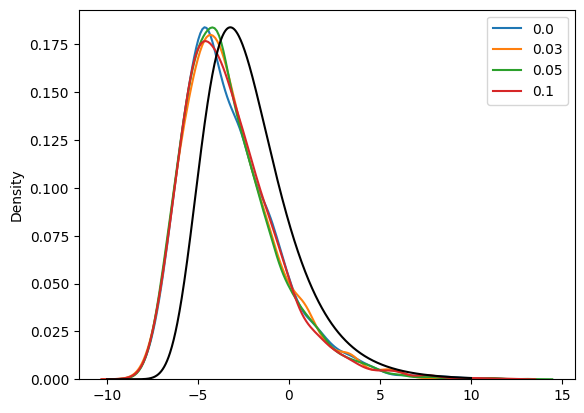

In [13]:
with open(f'../data/GraphHypTest/test_lasso_bias_under_null.pkl', 'rb') as handle:
    test_dict = pickle.load(handle)

sns.kdeplot(test_dict['test_stat'][0],label = test_dict['alphas'][0])
sns.kdeplot(test_dict['test_stat'][3],label = test_dict['alphas'][3])
sns.kdeplot(test_dict['test_stat'][5],label = test_dict['alphas'][5])
sns.kdeplot(test_dict['test_stat'][10],label = test_dict['alphas'][10])
plt.plot(np.linspace(-10,10,1000),dens_f(np.linspace(-10,10,1000)), color = 'black')
plt.legend()

Distribution using bootstrap

In [9]:
d = 100
s = 0.3
As = gen_all_all_zero(d,s)
nr_sims = 1000
test_stat = np.zeros(nr_sims)

cov_true1 = np.linalg.inv(As[0])
cov_true2 = np.linalg.inv(As[2])
pbar = tqdm.tqdm(total = nr_sims)

# Generate Data
X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true1, size = 500)
X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true2, size = 500)
X = np.vstack((X1,X2))
index = np.array(range(X.shape[0]))

_,t_stat_sample= my_hdtest(X1, np.cov(X1.T)*(X1.shape[0]-1)/X1.shape[0], X2, np.cov(X2.T)*(X2.shape[0]-1)/X2.shape[0])
for i in range(nr_sims):
    
    # from sklearn.model_selection import train_test_split
    # X1_tmp, X2_tmp = train_test_split(X, test_size=0.5)

    X1_tmp = X[np.random.choice(index, X.shape[0])]
    X2_tmp = X[np.random.choice(index, X.shape[0])]

    p,test_stat[i] = my_hdtest(X1_tmp, np.cov(X1_tmp.T)*(X1_tmp.shape[0]-1)/X1_tmp.shape[0], X2_tmp, np.cov(X2_tmp.T)*(X2_tmp.shape[0]-1)/X2_tmp.shape[0]) # out['statistics'][0] #
    
    # p,test_stat[i] = my_hdtest(X1, cov_true, X2, cov_true) # out['statistics'][0] #
    pbar.update()
pbar.close()
np.sum(test_stat >t_stat_sample)/len(test_stat)

  1%|          | 6/1000 [00:03<09:29,  1.74it/s]

KeyboardInterrupt: 

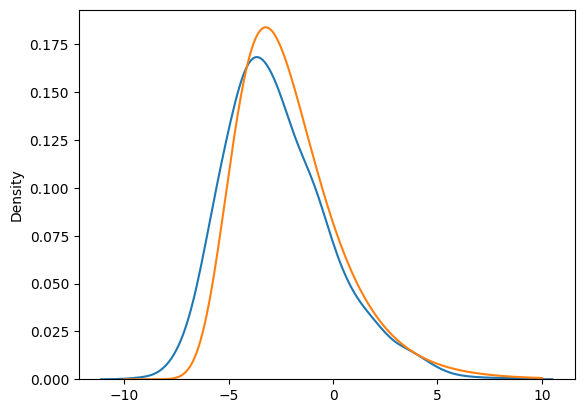

In [349]:
sns.kdeplot(test_stat)
plt.plot(np.linspace(-10,10,1000),dens_f(np.linspace(-10,10,1000)))

# Open Script data

In [16]:
with open(f'../data/GraphHypTest/g_hyp_test_roc.pkl', 'rb') as handle:
    g_hyp_test = pickle.load(handle)

kappas = g_hyp_test['kappas']
alphas = g_hyp_test['alphas']
g_hyp_test.keys()

dict_keys(['alphas', 'kappas', 'p_vals', 'F_norms', 'p_val_s_cross', 'nr_possible_removals'])

Temporal testing

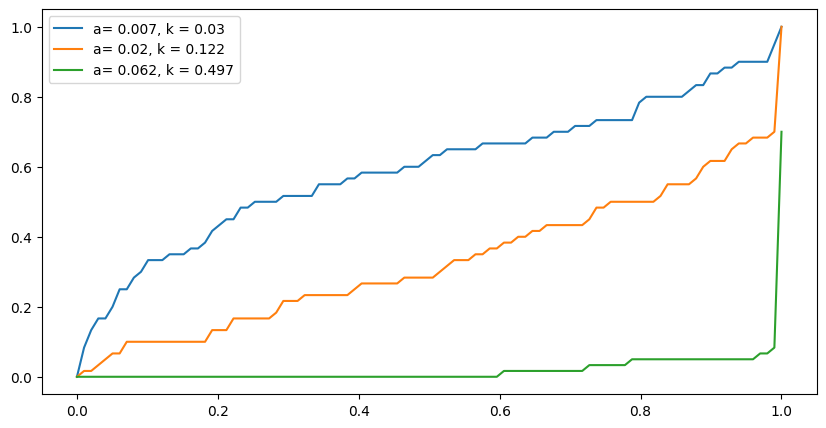

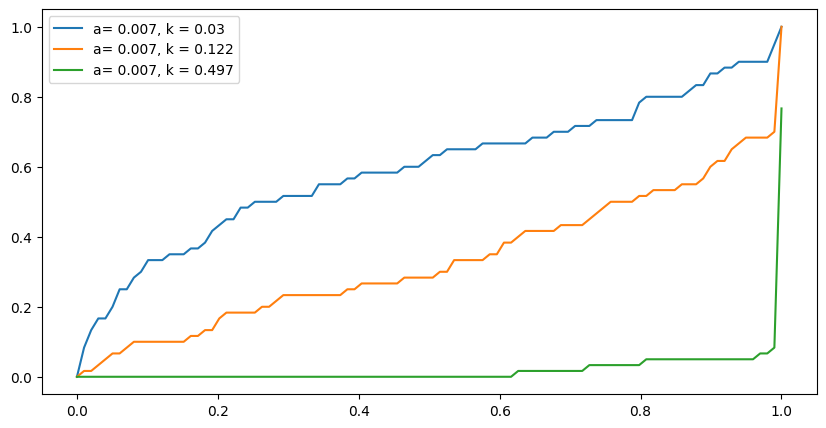

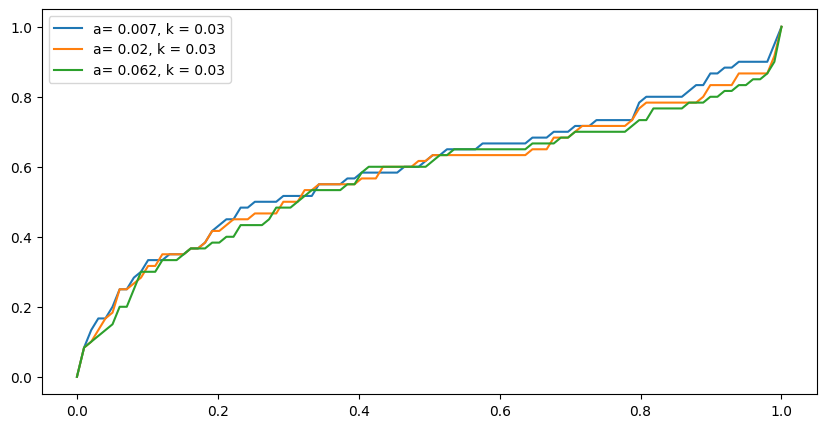

In [17]:
type_1_error = np.linspace(0,1, 100)
roc_curves = np.ones((len(type_1_error), 2,len(g_hyp_test['kappas']), len(g_hyp_test['alphas'])))

p_vals = np.stack(g_hyp_test['p_vals'])

for j in range(len(type_1_error)):
    for i in range(roc_curves.shape[1]):

        roc_curves[j,i] = np.sum(p_vals[:,i] < type_1_error[j], axis = 0)/p_vals.shape[0]





fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(type_1_error, roc_curves[:,0,0,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,0,2,2], label = f'a= {np.round(alphas[2], 3)}, k = {np.round(kappas[2],3)}')
ax.plot(type_1_error, roc_curves[:,0,4,4], label = f'a= {np.round(alphas[4], 3)}, k = {np.round(kappas[4],3)}')

ax.legend()


fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(type_1_error, roc_curves[:,0,0,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,0,2,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[2],3)}')
ax.plot(type_1_error, roc_curves[:,0,4,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[4],3)}')

ax.legend()


fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(type_1_error, roc_curves[:,0,0,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,0,0,2], label = f'a= {np.round(alphas[2], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,0,0,4], label = f'a= {np.round(alphas[4], 3)}, k = {np.round(kappas[0],3)}')

ax.legend()

Text(518.4494949494949, 0.5, 'kappa')

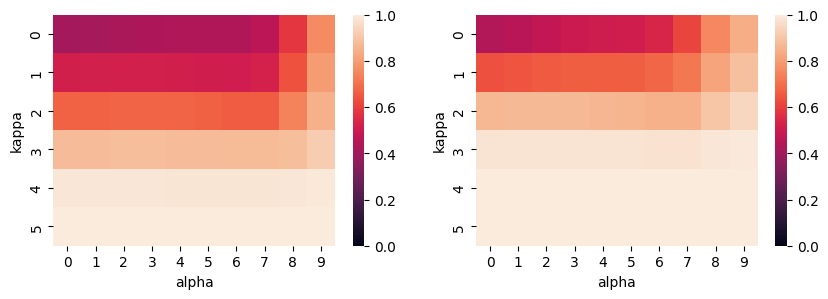

In [20]:
fig, ax = plt.subplots(1,2, figsize = (10,3))

sns.heatmap(np.mean(p_vals, axis = 0)[0], ax = ax[0],vmin = 0, vmax = 1)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("kappa")
sns.heatmap(np.mean(p_vals, axis = 0)[1], ax = ax[1],vmin = 0, vmax = 1)
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("kappa")

cross sectional testing

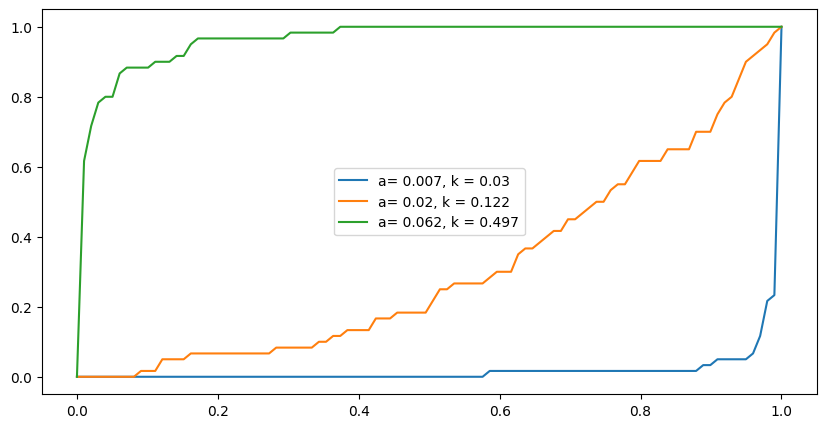

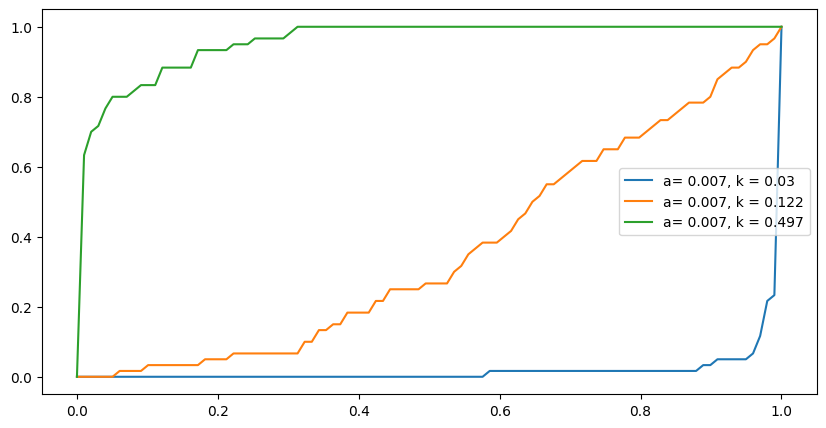

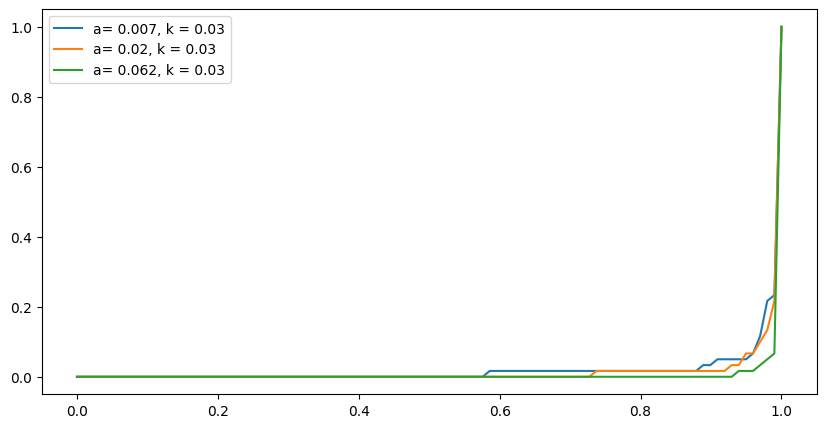

In [22]:
type_1_error = np.linspace(0,1, 100)
roc_curves = np.ones((len(type_1_error), 3,len(g_hyp_test['kappas']), len(g_hyp_test['alphas'])))

p_val_s_cross = np.stack(g_hyp_test['p_val_s_cross'])

for j in range(len(type_1_error)):
    for i in range(roc_curves.shape[1]):

        roc_curves[j,i] = np.sum(p_val_s_cross[:,i] < type_1_error[j], axis = 0)/p_val_s_cross.shape[0]




test_nr = 2

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(type_1_error, roc_curves[:,test_nr,0,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,test_nr,2,2], label = f'a= {np.round(alphas[2], 3)}, k = {np.round(kappas[2],3)}')
ax.plot(type_1_error, roc_curves[:,test_nr,4,4], label = f'a= {np.round(alphas[4], 3)}, k = {np.round(kappas[4],3)}')

ax.legend()


fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(type_1_error, roc_curves[:,test_nr,0,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,test_nr,2,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[2],3)}')
ax.plot(type_1_error, roc_curves[:,test_nr,4,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[4],3)}')

ax.legend()


fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(type_1_error, roc_curves[:,test_nr,0,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,test_nr,0,2], label = f'a= {np.round(alphas[2], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,test_nr,0,4], label = f'a= {np.round(alphas[4], 3)}, k = {np.round(kappas[0],3)}')

ax.legend()

Text(1314.8398692810458, 0.5, 'kappa')

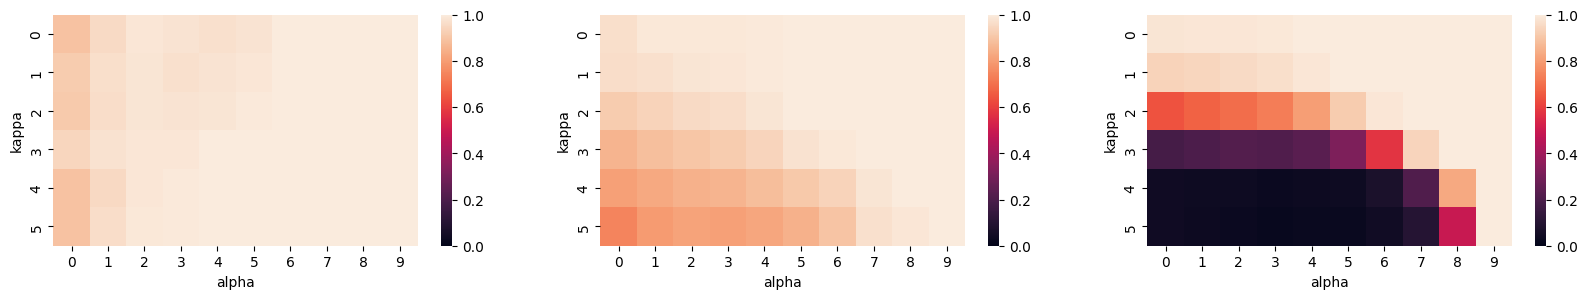

In [23]:
fig, ax = plt.subplots(1,3, figsize = (20,3))

sns.heatmap(np.mean(p_val_s_cross, axis = 0)[0], ax = ax[0],vmin = 0, vmax = 1)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("kappa")
sns.heatmap(np.mean(p_val_s_cross, axis = 0)[1], ax = ax[1],vmin = 0, vmax = 1)
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("kappa")
sns.heatmap(np.mean(p_val_s_cross, axis = 0)[2], ax = ax[2],vmin = 0, vmax = 1)
ax[2].set_xlabel("alpha")
ax[2].set_ylabel("kappa")

<AxesSubplot: >

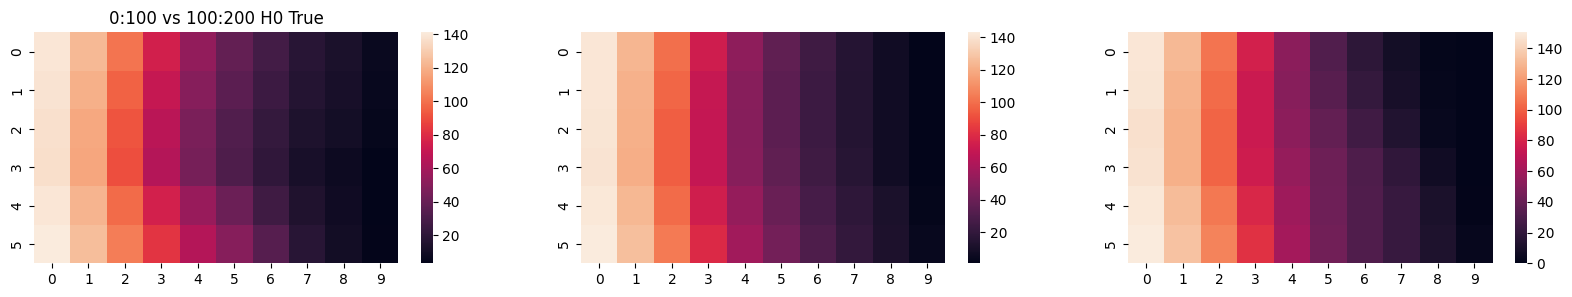

In [63]:

nr_possible_removals = np.stack(g_hyp_test['nr_possible_removals'])
fig, ax = plt.subplots(1,3, figsize = (20,3))

sns.heatmap(np.mean(nr_possible_removals, axis = 0)[0], ax = ax[0])
ax[0].set_title("0:100 vs 100:200 H0 True")
sns.heatmap(np.mean(nr_possible_removals, axis = 0)[1], ax = ax[1])
sns.heatmap(np.mean(nr_possible_removals, axis = 0)[2], ax = ax[2])

# Effect of graphical lasso

In [398]:
d = 20
s = 0.1
As = gen_all_all_zero(d,s)
As[0]

array([[1.58124015, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.58124015, 0.        , 0.71479388, 0.16227859,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.58124015, 0.53275187, 0.        ,
        0.        , 0.95437717, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.20827674],
       [0.        , 0.71479388, 0.53275187, 1.58124015, 0.        ,
        0.        , 0.        , 0.43570767, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

In [414]:
def fun(param, test_stat):

    return -np.sum(np.log(dens_f(test_stat+param)))

d = 20
s = 0.7
As = gen_all_all_zero(d,s,v1=1.05)
nr_sims = 100

cov_true1 = np.linalg.inv(As[0])
cov_true2 = np.linalg.inv(As[1])
alphas = [0.02]
pbar = tqdm.tqdm(total = nr_sims*len(alphas))
opt_const = []
test_stat_alphas = np.zeros((len(alphas), nr_sims))

for cnt, alpha in enumerate(alphas):

    test_stat_tmp = np.zeros(nr_sims)

    for i in range(nr_sims):
        # Generate Data
        X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true1, size = 500)
        X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true2, size = 500)

        obs_per_graph = X1.shape[0]
        dg_opt1 = dg.sgl(max_iter = 300, lamda = obs_per_graph*alpha,  tol = 1e-6)
        dg_opt1.fit(X1, nr_workers=1, lik_type="gaussian",verbose=False)

        obs_per_graph = X2.shape[0]
        dg_opt2 = dg.sgl(max_iter = 300, lamda = obs_per_graph*alpha, tol = 1e-6)
        dg_opt2.fit(X2, nr_workers=1, lik_type="gaussian",verbose=False)


        p,test_stat_tmp[i] = my_hdtest(X1, np.linalg.inv(dg_opt1.theta[-1]), X2, np.linalg.inv(dg_opt2.theta[-1])) # out['statistics'][0] #
        pbar.update()

    test_stat_alphas[cnt] = test_stat_tmp


    out = scipy.optimize.minimize(fun, 2, args = (test_stat_tmp,) )
    opt_const.append(out.x)

    pbar.close()

 24%|██▍       | 24/100 [00:01<00:05, 13.06it/s]C:\Users/User/Code/DyGraph\DyGraph\gl_admm.py:172: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
100%|██████████| 100/100 [00:07<00:00, 13.99it/s]


In [413]:
p

0.9218935739503726

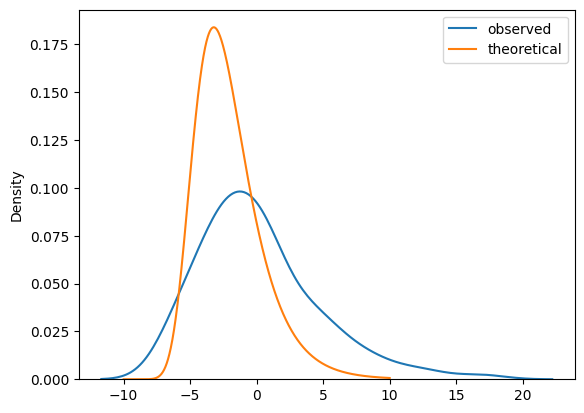

In [415]:
def dens_f(t):
    const = 1/(np.sqrt(8*np.pi))

    return np.exp(-const*np.exp(-t/2))* np.exp(-t/2)*const*0.5

dens_f = np.vectorize(dens_f)

sns.kdeplot(test_stat_alphas[0], label ='observed')
plt.plot(np.linspace(-10,10,1000),dens_f(np.linspace(-10,10,1000)), label = 'theoretical')
plt.legend()
#plt.xlim((-20,10))

In [152]:
# what if we generate from the estimated graphs

def fun(param, test_stat):

    return -np.sum(np.log(dens_f(test_stat+param)))

d = 20
s = 0.7
As = gen_all_all_zero(d,s)
nr_sims = 100

cov_true = np.linalg.inv(As[0])
alphas = [0.02]
pbar = tqdm.tqdm(total = nr_sims*len(alphas))
opt_const = []
test_stat_alphas = np.zeros((len(alphas), nr_sims))

for cnt, alpha in enumerate(alphas):

    test_stat_tmp = np.zeros(nr_sims)

    for i in range(nr_sims):
        # Generate Data
        X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true, size = 500)
        X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true, size = 500)

        obs_per_graph = X1.shape[0]
        dg_opt1 = dg.sgl(max_iter = 300, lamda = obs_per_graph*alpha,  tol = 1e-6)
        dg_opt1.fit(X1, nr_workers=1, lik_type="gaussian",verbose=False)

        obs_per_graph = X2.shape[0]
        dg_opt2 = dg.sgl(max_iter = 300, lamda = obs_per_graph*alpha, tol = 1e-6)
        dg_opt2.fit(X2, nr_workers=1, lik_type="gaussian",verbose=False)

        X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(dg_opt1.theta[-1]), size = X1.shape[0])
        X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(dg_opt2.theta[-1]), size = X2.shape[0])


        p,test_stat_tmp[i] = my_hdtest(X1, np.cov(X1.T)*(X1.shape[0]-1)/X1.shape[0], X2, np.cov(X2.T)*(X2.shape[0]-1)/X2.shape[0]) # out['statistics'][0] #
        pbar.update()

    test_stat_alphas[cnt] = test_stat_tmp


    out = scipy.optimize.minimize(fun, 2, args = (test_stat_tmp,) )
    opt_const.append(out.x)

    pbar.close()

 34%|███▍      | 34/100 [00:02<00:04, 14.15it/s]C:\Users/User/Code/DyGraph\DyGraph\gl_admm.py:172: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
100%|██████████| 100/100 [00:07<00:00, 14.13it/s]


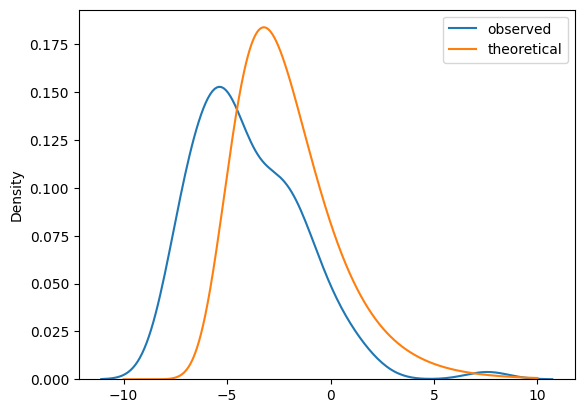

In [281]:
def dens_f(t):
    const = 1/(np.sqrt(8*np.pi))

    return np.exp(-const*np.exp(-t/2))* np.exp(-t/2)*const*0.5

dens_f = np.vectorize(dens_f)

sns.kdeplot(test_stat_alphas[0], label ='observed')
plt.plot(np.linspace(-10,10,1000),dens_f(np.linspace(-10,10,1000)), label = 'theoretical')
plt.legend()
#plt.xlim((-20,10))

In [282]:
# Bootstrap

def fun(param, test_stat):

    return -np.sum(np.log(dens_f(test_stat+param)))

d = 20
s = 0.7
As = gen_all_all_zero(d,s)
nr_sims = 100

cov_true = np.linalg.inv(As[0])
alphas = [0.02]
pbar = tqdm.tqdm(total = nr_sims*len(alphas))
opt_const = []
test_stat_alphas = np.zeros((len(alphas), nr_sims))

for cnt, alpha in enumerate(alphas):

    test_stat_tmp = np.zeros(nr_sims)

    for i in range(nr_sims):
        # Generate Data
        X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true, size = 500)
        X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true, size = 500)

        obs_per_graph = X1.shape[0]
        dg_opt1 = dg.sgl(max_iter = 300, lamda = obs_per_graph*alpha,  tol = 1e-6)
        dg_opt1.fit(X1, nr_workers=1, lik_type="gaussian",verbose=False)

        obs_per_graph = X2.shape[0]
        dg_opt2 = dg.sgl(max_iter = 300, lamda = obs_per_graph*alpha, tol = 1e-6)
        dg_opt2.fit(X2, nr_workers=1, lik_type="gaussian",verbose=False)

 
        X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(dg_opt1.theta[-1]), size = X1.shape[0])
        X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(dg_opt2.theta[-1]), size = X2.shape[0])


        p,test_stat_tmp[i] = my_hdtest(X1, np.cov(X1.T)*(X1.shape[0]-1)/X1.shape[0], X2, np.cov(X2.T)*(X2.shape[0]-1)/X2.shape[0]) # out['statistics'][0] #
        pbar.update()

    test_stat_alphas[cnt] = test_stat_tmp


    out = scipy.optimize.minimize(fun, 2, args = (test_stat_tmp,) )
    opt_const.append(out.x)

    pbar.close()

  2%|▏         | 2/100 [00:00<00:07, 13.98it/s]C:\Users/User/Code/DyGraph\DyGraph\gl_admm.py:172: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


In [283]:
def fun(param, test_stat):

    return -np.sum(np.log(dens_f(test_stat+param)))

d = 20
s = 0.3
As = gen_all_all_zero(d,s)
nr_sims = 1000
test_stat = np.zeros(nr_sims)

cov_true = np.linalg.inv(As[0])
alphas = [0, 0.01, 0.02, 0.05, 0.1]
pbar = tqdm.tqdm(total = nr_sims*len(alphas))
opt_const = []

for alpha in alphas:

    for i in range(nr_sims):
        # Generate Data
        X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true, size = 500)
        X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov = cov_true, size = 500)

        obs_per_graph = X1.shape[0]
        dg_opt1 = dg.sgl(max_iter = 300, lamda = obs_per_graph*0.1,  tol = 1e-6)
        dg_opt1.fit(X1, nr_workers=1, lik_type="gaussian",verbose=False)

        obs_per_graph = X2.shape[0]
        dg_opt2 = dg.sgl(max_iter = 300, lamda = obs_per_graph*0.1, tol = 1e-6)
        dg_opt2.fit(X2, nr_workers=1, lik_type="gaussian",verbose=False)


        p,test_stat[i] = my_hdtest(X1, np.linalg.inv(dg_opt1.theta[-1]), X2, np.linalg.inv(dg_opt2.theta[-1])) # out['statistics'][0] #
        pbar.update()


    out = scipy.optimize.minimize(fun, 2, args = (test_stat,) )
    opt_const.append(out.x)

    pbar.close()

  7%|▋         | 356/5000 [00:09<02:10, 35.55it/s]

KeyboardInterrupt: 

In [112]:
pbar.close()

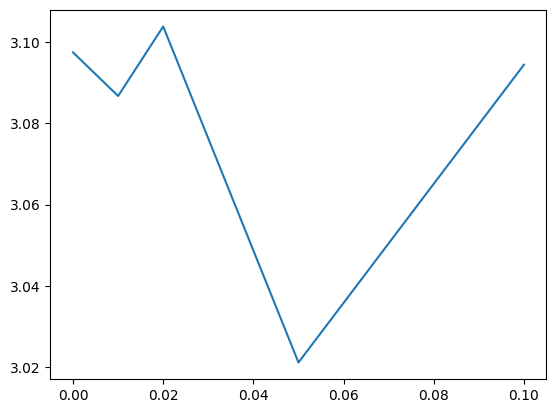

In [113]:
plt.plot(alphas, opt_const)

In [103]:
out = scipy.optimize.minimize(fun, 2, args = (test_stat,) )
out.x

array([2.76140223])

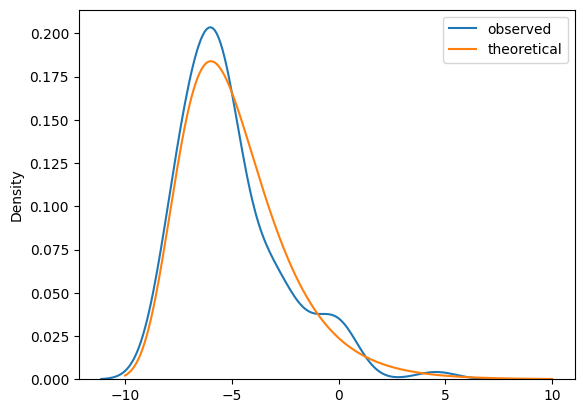

In [104]:
def dens_f(t):
    const = 1/(np.sqrt(8*np.pi))

    return np.exp(-const*np.exp(-t/2))* np.exp(-t/2)*const*0.5

dens_f = np.vectorize(dens_f)

sns.kdeplot(test_stat, label ='observed')
plt.plot(np.linspace(-10,10,1000),dens_f(np.linspace(-10,10,1000)+out.x), label = 'theoretical')
plt.legend()

# Simulate Gaussian graphs

In [416]:
d = 20
s = 0.3
As = gen_all_all_zero(d,s)

X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(As[0]), size = 100)
X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[1]), size = 100)
X3 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[2]), size = 100)

X = np.vstack([X1,X2,X3])
X.shape

(300, 20)

Fit dygl

In [179]:
obs_per_graph = 30
dg_opt1 = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.01, kappa = obs_per_graph*1, tol = 1e-6)
dg_opt1.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

In [168]:
scipy.linalg.norm(dg_opt1.theta[0]-dg_opt1.theta[1])

0.0007533248860005277

In [242]:
theta_i_x = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(dg_opt1.theta[0]), size = 100)
theta_i1_x = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(dg_opt1.theta[0+5]), size = 100)

out = HDtest.testCov(theta_i_x,theta_i1_x, J = 10000, method = 'CLX')
out = dict(zip(out.names, list(out)))
out

ValueError: mean and cov must have same length

In [464]:

nr_sims = 1

kappas = np.exp(-np.linspace(5, 0,10))
alphas = np.exp(-np.linspace(5, 1,10))
# obs_per_graph = 100
pbar = tqdm.tqdm(total = len(kappas)*len(alphas)*nr_sims, position=0)

p_vals_roc = np.ones((nr_sims, int(len(X)/obs_per_graph)-1,len(kappas), len(alphas)))
p_vals_b_roc = np.ones((nr_sims, int(len(X)/obs_per_graph)-1,len(kappas), len(alphas)))
F_norms = np.ones((nr_sims, int(len(X)/obs_per_graph),len(kappas), len(alphas)))
for sim_cnt in range(nr_sims):
    
    d = 20
    s = 0.3
    As = gen_all_all_zero(d,s, v1 = 1.1, v2 = 1.2)

    X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(As[0]), size = 100)
    X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[1]), size = 100)
    X3 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[2]), size = 100)

    X = np.vstack([X1,X2,X3])
    X.shape
    obs_per_graph = 100

    for cnt_k, kappa in enumerate(kappas):
        for cnt_a, alpha in enumerate(alphas):
            dg_opt1 = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = 1e-6)
            dg_opt1.fit(X, nr_workers=1, temporal_penalty="ridge", lik_type="gaussian",verbose=False)
            for i in range(len(dg_opt1.theta)-1):
                cov_1 = np.linalg.inv(dg_opt1.theta[i])
                cov_2 = np.linalg.inv(dg_opt1.theta[i+1])
                p_vals_roc[sim_cnt, i, cnt_k, cnt_a],_ =  my_hdtest(X[i*obs_per_graph:(i+1)*obs_per_graph],cov_1, X[(i+1)*obs_per_graph:(i+2)*obs_per_graph], cov_2)
                #p_vals_b_roc[sim_cnt, i, cnt_k, cnt_a],_,_ =  hdtest_boot(X[i*obs_per_graph:(i+1)*obs_per_graph],cov_1, X[(i+1)*obs_per_graph:(i+2)*obs_per_graph], cov_2, 1000)
                F_norms[sim_cnt, i, cnt_k, cnt_a] = scipy.linalg.norm(dg_opt1.theta[i]-dg_opt1.theta[i+1])/scipy.linalg.norm(dg_opt1.theta[i])
            pbar.update()
    pbar.close()



100%|██████████| 100/100 [00:05<00:00, 19.67it/s]


Text(0.5, 1.0, '100:200 vs 200:300 H0 False')

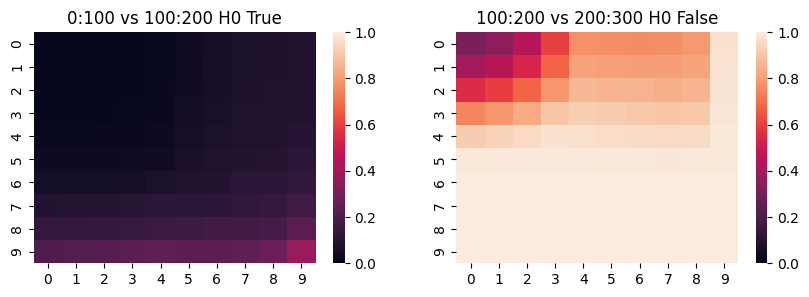

In [465]:
fig, ax = plt.subplots(1,2, figsize = (10,3))

sns.heatmap(np.median(p_vals_roc, axis = 0)[0], ax = ax[0],vmin = 0, vmax = 1)
ax[0].set_title("0:100 vs 100:200 H0 True")
sns.heatmap(np.median(p_vals_roc, axis = 0)[1], ax = ax[1],vmin = 0, vmax = 1)
ax[1].set_title("100:200 vs 200:300 H0 False")
# sns.heatmap(p_vals[2], ax = ax[1,0],vmin = 0, vmax = 1)
# ax[1,0].set_title("100:150 vs 150:200 H0 True")
# sns.heatmap(p_vals[3], ax = ax[1,1],vmin = 0, vmax = 1)
# ax[1,1].set_title("150:200 vs 200:250 H0 False")
# sns.heatmap(p_vals[4], ax = ax[2,0],vmin = 0, vmax = 1)
# ax[2,0].set_title("200:250 vs 250:300 H0 True")




Text(0.5, 1.0, '100:200 vs 200:300 H0 False')

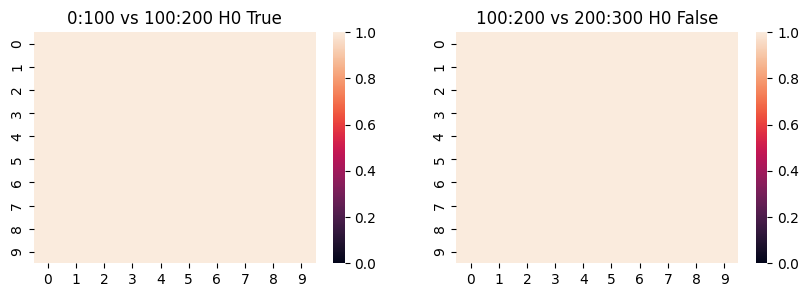

In [378]:
fig, ax = plt.subplots(1,2, figsize = (10,3))

sns.heatmap(np.median(p_vals_b_roc, axis = 0)[0], ax = ax[0],vmin = 0, vmax = 1)
ax[0].set_title("0:100 vs 100:200 H0 True")
sns.heatmap(np.median(p_vals_b_roc, axis = 0)[1], ax = ax[1],vmin = 0, vmax = 1)
ax[1].set_title("100:200 vs 200:300 H0 False")
# sns.heatmap(p_vals[2], ax = ax[1,0],vmin = 0, vmax = 1)
# ax[1,0].set_title("100:150 vs 150:200 H0 True")
# sns.heatmap(p_vals[3], ax = ax[1,1],vmin = 0, vmax = 1)
# ax[1,1].set_title("150:200 vs 200:250 H0 False")
# sns.heatmap(p_vals[4], ax = ax[2,0],vmin = 0, vmax = 1)
# ax[2,0].set_title("200:250 vs 250:300 H0 True")


In [245]:
type_1_error = np.linspace(0,1, 100)
roc_curves = np.ones((len(type_1_error), int(len(X)/obs_per_graph),len(kappas), len(alphas)))

for j in range(len(type_1_error)):
    for i in range(roc_curves.shape[1]):

        roc_curves[j,i] = np.sum(p_vals[:,i] < type_1_error[j], axis = 0)/p_vals.shape[0]





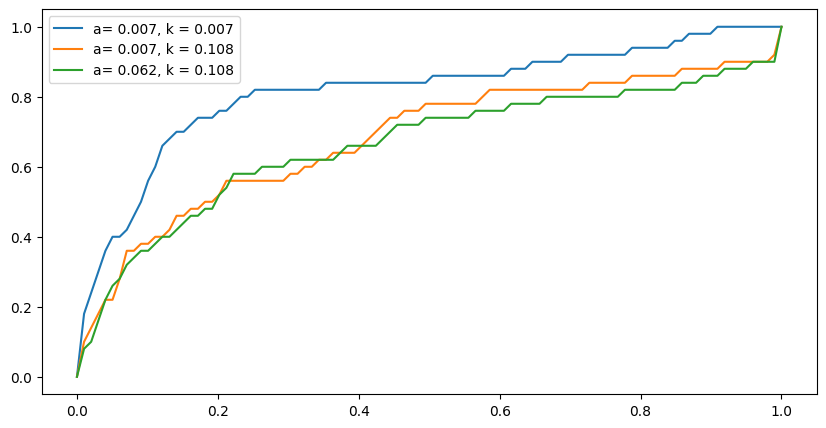

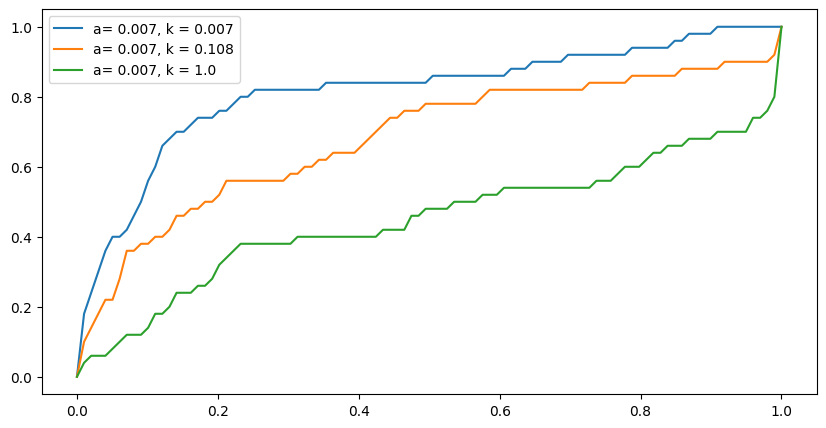

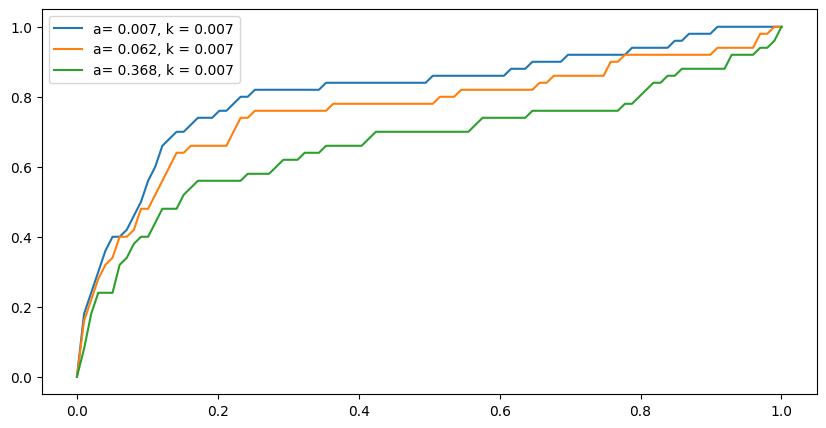

In [247]:


fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(type_1_error, roc_curves[:,0,0,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,0,5,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[5],3)}')
ax.plot(type_1_error, roc_curves[:,0,5,5], label = f'a= {np.round(alphas[5], 3)}, k = {np.round(kappas[5],3)}')

ax.legend()


fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(type_1_error, roc_curves[:,0,0,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,0,5,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[5],3)}')
ax.plot(type_1_error, roc_curves[:,0,9,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[9],3)}')

ax.legend()


fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(type_1_error, roc_curves[:,0,0,0], label = f'a= {np.round(alphas[0], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,0,0,5], label = f'a= {np.round(alphas[5], 3)}, k = {np.round(kappas[0],3)}')
ax.plot(type_1_error, roc_curves[:,0,0,9], label = f'a= {np.round(alphas[9], 3)}, k = {np.round(kappas[0],3)}')

ax.legend()

Text(0.5, 1.0, '50:100 vs 100:150 H0 False')

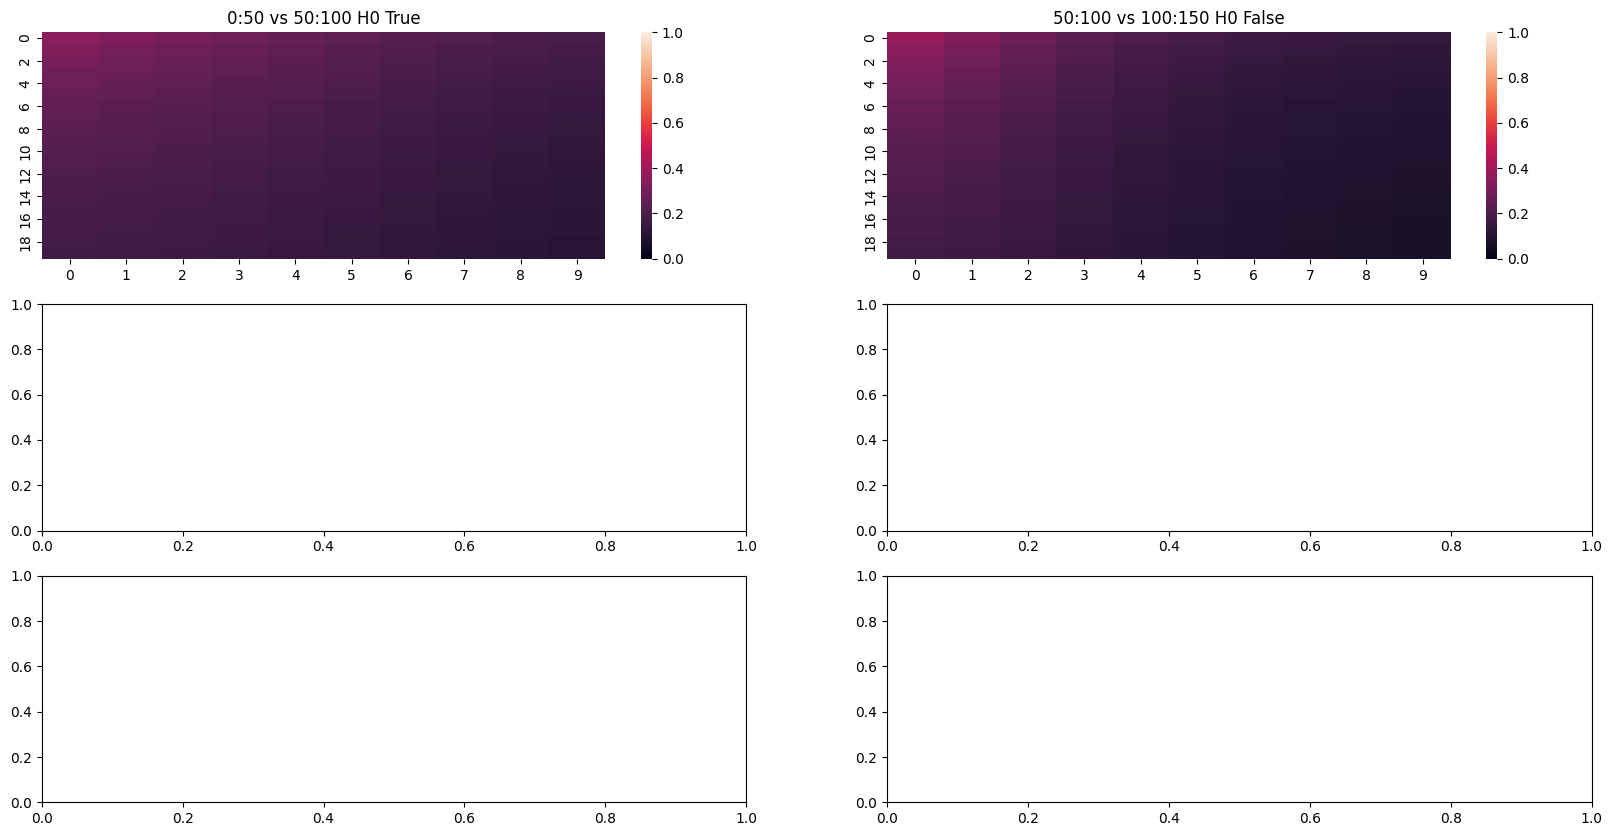

In [24]:
fig, ax = plt.subplots(3,2, figsize = (20,10))

sns.heatmap(F_norms[0], ax = ax[0,0],vmin = 0, vmax = 1)
ax[0,0].set_title("0:50 vs 50:100 H0 True")
sns.heatmap(F_norms[1], ax = ax[0,1],vmin = 0, vmax = 1)
ax[0,1].set_title("50:100 vs 100:150 H0 False")
# sns.heatmap(F_norms[2], ax = ax[1,0],vmin = 0, vmax = 1)
# ax[1,0].set_title("100:150 vs 150:200 H0 True")
# sns.heatmap(F_norms[3], ax = ax[1,1],vmin = 0, vmax = 1)
# ax[1,1].set_title("150:200 vs 200:250 H0 False")
# sns.heatmap(F_norms[4], ax = ax[2,0],vmin = 0, vmax = 1)
# ax[2,0].set_title("200:250 vs 250:300 H0 True")

# CE method

Refit use likelihood

In [11]:

def CE_glasso(N, tail_prob, X, nr_its = 20):

    d = X.shape[1]

    nr_params = int(d*(d-1)/2)

    p = np.array([0.5]*nr_params)

    for _ in range(nr_its):

        liks = np.zeros(N)  # store log-likelihoods
        B = scipy.stats.bernoulli.rvs(p = p, size = (N,nr_params))  

        # find optimal theta where B_i dictates which elements get regularized to infinity
        for i in range(N):
            reg_matrix = np.zeros((d,d))
            reg_matrix[np.triu_indices(d,1)] = B[i]*999999
            reg_matrix = reg_matrix + reg_matrix.T

            gls = dg.sgl(max_iter = 100, lamda = reg_matrix, tol = 1e-3)
            gls.fit(X, nr_workers=1, lik_type="gaussian",verbose=False)

            liks[i] = np.sum(scipy.stats.multivariate_normal.logpdf(X, mean =np.zeros(d), cov = np.linalg.inv(gls.theta[-1])))

        # Get quantile (best value)
        val_func = np.quantile(liks, tail_prob)
        

        # update p
        for i in range(nr_params):
            p[i] = np.sum((liks >= val_func)*B[:,i])/np.sum((liks >= val_func))


            

    # Finally use best estimate of I to get theta
    I = 1 * (p >0.5)
    reg_matrix = np.zeros((d,d))
    reg_matrix[np.triu_indices(d,1)] = I*999999
    reg_matrix = reg_matrix + reg_matrix.T

    gls = dg.sgl(max_iter = 100, lamda = reg_matrix, tol = 1e-3)
    gls.fit(X, nr_workers=1, lik_type="gaussian",verbose=False)

    return gls.theta[-1],I






In [12]:
d = 5
s = 0.7
As = gen_all_all_zero(d,s)
A = As[0]
I_true = (1*(A==0))[np.triu_indices(d,1)]
X = np.random.multivariate_normal(mean = np.zeros(d), cov = np.linalg.inv(A), size = 100000)

C:\Users\User\AppData\Local\Temp\ipykernel_17980\2245189461.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense())


In [13]:
nr_its = 50
tail_prob = 0.9
N = 100

val_funcs = np.zeros(N)


d = X.shape[1]

nr_params = int(d*(d-1)/2)

u = np.array([0.5]*nr_params)
p = np.random.uniform(size = nr_params)

for itr in range(nr_its):

    p_pre = p.copy()

    liks = np.zeros(N)  # store log-likelihoods
    B = scipy.stats.bernoulli.rvs(p = p, size = (N,nr_params))  

    # find optimal theta where B_i dictates which elements get regularized to infinity
    for i in range(N):
        reg_matrix = np.zeros((d,d))
        reg_matrix[np.triu_indices(d,1)] = B[i]*999999
        reg_matrix = reg_matrix + reg_matrix.T

        gls = dg.sgl(max_iter = 100, lamda = reg_matrix, tol = 1e-3)
        gls.fit(X, nr_workers=1, lik_type="gaussian",verbose=False)

        liks[i] = np.sum(scipy.stats.multivariate_normal.logpdf(X, mean =np.zeros(d), cov = np.linalg.inv(gls.theta[-1]))) #- np.sum(A != 0)*np.log(X.shape[0])

    # Get quantile (best value)
    val_func = np.sort(liks)[int(np.floor(N*tail_prob))]
    val_funcs[itr] = val_func

    if np.all(val_funcs[(itr-5+1):(itr+1)] == val_funcs[itr]) and itr >=5:
        break

    # smoothing parameter
    w = np.zeros(len(p))
    weight_vec = np.zeros(N)
    for i in range(N):
        tmp_i = np.sum(scipy.stats.bernoulli.logpmf(p=u,k = B[i])) - np.sum(scipy.stats.bernoulli.logpmf(p=p,k = B[i]))
        weight_vec[i] = np.exp(tmp_i)
    weight_vec = weight_vec*(liks >= val_func)
    for i in range(nr_params):
        p[i] =  np.sum(weight_vec*B[:,i])/np.sum(weight_vec)
    

    # update p
    # for i in range(nr_params):
    #     p[i] = np.sum((liks >= val_func)*B[:,i])/np.sum((liks >= val_func))

    p = 0.8*p_pre + 0.2*p


        

# Finally use best estimate of I to get theta
I = 1 * (p >0.5)
reg_matrix = np.zeros((d,d))
reg_matrix[np.triu_indices(d,1)] = I*999999
reg_matrix = reg_matrix + reg_matrix.T

gls = dg.sgl(max_iter = 100, lamda = reg_matrix, tol = 1e-3)
gls.fit(X, nr_workers=1, lik_type="gaussian",verbose=False)

In [14]:
print(np.round(A,2))
print(np.round(gls.theta[-1],2))

[[ 1.51 -0.59 -0.4   0.22 -0.3 ]
 [-0.59  1.17  0.   -0.58 -0.  ]
 [-0.4   0.    1.36  0.51 -0.45]
 [ 0.22 -0.58  0.51  1.87 -0.55]
 [-0.3  -0.   -0.45 -0.55  1.3 ]]
[[ 1.49 -0.58 -0.4   0.21 -0.29]
 [-0.58  1.16 -0.   -0.57 -0.01]
 [-0.4  -0.    1.36  0.51 -0.44]
 [ 0.21 -0.57  0.51  1.85 -0.54]
 [-0.29 -0.01 -0.44 -0.54  1.29]]


In [ ]:
reg_matrix = np.zeros((d,d))
reg_matrix[np.triu_indices(d,1)] = I_true*999999
reg_matrix = reg_matrix + reg_matrix.T
gls_true = dg.sgl(max_iter = 100, lamda = reg_matrix, tol = 1e-3)
gls_true.fit(X, nr_workers=1, lik_type="gaussian",verbose=False)

In [ ]:
theta_ce_method, I = CE_glasso(100, 0.95, X)

In [ ]:
np.round(theta_ce_method,2)

Use p-value

In [16]:

def CE_pval(N, tail_prob, X,theta_1, nr_its = 20):

    s_1 = theta_1.copy()

    d = X.shape[1]

    nr_params = int(d*(d-1)/2)

    p = np.array([0.5]*nr_params)

    for _ in range(nr_its):

        p_vals = np.zeros(N)  # store log-likelihoods
        B = scipy.stats.bernoulli.rvs(p = p, size = (N,nr_params))  

        # find optimal theta where B_i dictates which elements get regularized to infinity
        for i in range(N):
            theta_2 = np.zeros((d,d))
            theta_2[np.triu_indices(d,1)] = (1-B[i])*theta_1[np.triu_indices(d,1)]
            theta_2 = theta_2 + theta_2.T
            np.fill_diagonal(theta_2, np.diag(theta_1))

            p_vals[i] = my_hdtest(X, s_1, X, theta_2)

        # Get quantile (best value)
        val_func = np.quantile(liks, tail_prob)
        

        # update p
        for i in range(nr_params):
            p[i] = np.sum((p_vals >= val_func)*B[:,i])/np.sum((p_vals >= val_func))


            

    # Finally use best estimate of I to get theta
    I = 1 * (p >0.5)
    theta_2 = np.zeros((d,d))
    theta_2[np.triu_indices(d,1)] = (1-I)*theta_1[np.triu_indices(d,1)]
    theta_2 = theta_2 + theta_2.T


    return theta_2,I






In [4]:
d = 5
s = 0.7
As = gen_all_all_zero(d,s)
A = As[0]
I_true = (1*(A==0))[np.triu_indices(d,1)]
X = np.random.multivariate_normal(mean = np.zeros(d), cov = np.linalg.inv(A), size = 10)

C:\Users\User\AppData\Local\Temp\ipykernel_10828\2245189461.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense())


In [17]:
theta_p_val, I = CE_pval(100, 0.95, X, A)

In [5]:
N = 1000
tail_prob = 0.95
theta_1 = A.copy()
nr_its = 100
s_1 = np.linalg.inv(theta_1.copy())

d = X.shape[1]

nr_params = int(d*(d-1)/2)

p = np.array([0.5]*nr_params)

for _ in range(nr_its):

    p_vals = np.zeros(N)  # store log-likelihoods
    B = scipy.stats.bernoulli.rvs(p = p, size = (N,nr_params))  

    # find optimal theta where B_i dictates which elements get regularized to infinity
    for i in range(N):
        theta_2 = np.zeros((d,d))
        theta_2[np.triu_indices(d,1)] = (1-B[i])*theta_1[np.triu_indices(d,1)]
        theta_2 = theta_2 + theta_2.T
        np.fill_diagonal(theta_2, np.diag(theta_1))

        p_vals[i] = -my_hdtest(X, s_1, X, np.linalg.inv(theta_2))

    # Get quantile (best value)
    val_func = np.quantile(p_vals, tail_prob)
    

    # update p
    for i in range(nr_params):
        p[i] = np.sum((p_vals >= val_func)*B[:,i])/np.sum((p_vals >= val_func))


        

# Finally use best estimate of I to get theta
I = 1 * (p >0.5)
theta_2 = np.zeros((d,d))
theta_2[np.triu_indices(d,1)] = (1-I)*theta_1[np.triu_indices(d,1)]
theta_2 = theta_2 + theta_2.T
np.fill_diagonal(theta_2, np.diag(theta_1))


In [6]:
print(np.round(theta_1,2))
print(np.round(theta_2,2))

[[ 1.79 -0.57 -0.55  0.25 -0.41]
 [-0.57  1.15  0.   -0.58  0.  ]
 [-0.55  0.    1.57 -0.58 -0.43]
 [ 0.25 -0.58 -0.58  2.    0.58]
 [-0.41  0.   -0.43  0.58  1.42]]
[[ 1.79  0.   -0.55  0.25 -0.41]
 [ 0.    1.15  0.   -0.58  0.  ]
 [-0.55  0.    1.57  0.   -0.43]
 [ 0.25 -0.58  0.    2.    0.58]
 [-0.41  0.   -0.43  0.58  1.42]]


ok will just give some random precision matrix

In [118]:
d = 20
s = 0.7
As = gen_all_all_zero(d,s)
A = As[0]
I_true = (1*(A==0))[np.triu_indices(d,1)]
X = np.random.multivariate_normal(mean = np.zeros(d), cov = np.linalg.inv(A), size = 100)

C:\Users\User\AppData\Local\Temp\ipykernel_36684\1879561373.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense())


Is there any matrix with fewer parameters that will minimize the likelihood further

In [277]:
d = 20
s = 0.3
As = gen_all_all_zero(d,s)

A = As[0]
X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(A), size = 100)
#X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[1]), size = 100)
#X3 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[2]), size = 100)

gls = dg.sgl(max_iter = 500, lamda = X1.shape[0]*0.5, tol = 1e-5)
gls.fit(X1, nr_workers=1, lik_type="gaussian",verbose=False)



In [278]:





N = 10000
tail_prob = 0.95
theta_1 = gls.theta[-1].copy()
theta_1[np.abs(theta_1)<1e-3] = 0.0
nr_its = 10
s_1 = theta_1.copy()

d = X.shape[1]

nr_params = int(d*(d-1)/2)

p = np.array([0.5]*nr_params)

pbar = tqdm.tqdm(total  = nr_its*N)

for _ in range(nr_its):

    liks = np.zeros(N)  # store log-likelihoods
    B = scipy.stats.bernoulli.rvs(p = p, size = (N,nr_params))  

    # find optimal theta where B_i dictates which elements get regularized to infinity
    for i in range(N):
        theta_2 = np.zeros((d,d))
        theta_2[np.triu_indices(d,1)] = (1-B[i])*theta_1[np.triu_indices(d,1)]
        theta_2 = theta_2 + theta_2.T
        np.fill_diagonal(theta_2, np.diag(theta_1))

        try:
        
            liks[i] = np.sum(scipy.stats.multivariate_normal.logpdf(X1, mean =np.zeros(d), cov = np.linalg.inv(theta_2))) - np.log(X.shape[0])*np.sum(theta_2[np.triu_indices(d,1)] != 0)/2 +d/2
        except:
            liks[i] = -np.inf

        pbar.update()


    # Get quantile (best value)
    val_func = np.quantile(liks, tail_prob)
    

    # update p
    for i in range(nr_params):
        p[i] = np.sum((liks >= val_func)*B[:,i])/np.sum((liks >= val_func))


pbar.close()
        

# Finally use best estimate of I to get theta
I = 1 * (p >0.5)
theta_2 = np.zeros((d,d))
theta_2[np.triu_indices(d,1)] = (1-I)*theta_1[np.triu_indices(d,1)]
theta_2 = theta_2 + theta_2.T
np.fill_diagonal(theta_2, np.diag(theta_1))


100%|██████████| 100000/100000 [00:51<00:00, 1960.46it/s]


In [279]:
my_hdtest(X1, np.linalg.inv(theta_1), X1, np.linalg.inv(theta_2))

1.0

<AxesSubplot: >

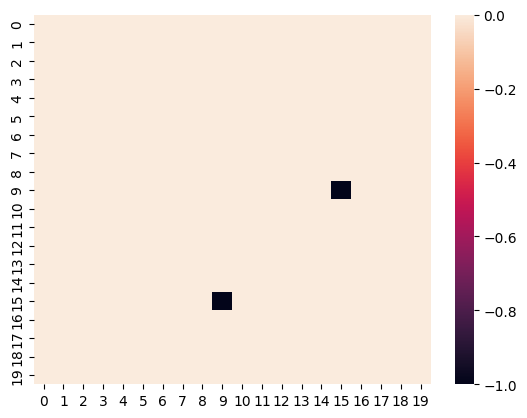

In [280]:
sns.heatmap(1*(theta_1 == 0)-1*(theta_2 == 0))

In [4]:
def CE_remove_lik(X,N, tail_prob, theta_1, nr_its = 2):

    theta_1[np.abs(theta_1)<1e-3] = 0.0


    d = X.shape[1]

    nr_params = int(d*(d-1)/2)

    p = np.array([0.5]*nr_params)

    for _ in range(nr_its):

        liks = np.zeros(N)  # store log-likelihoods
        B = scipy.stats.bernoulli.rvs(p = p, size = (N,nr_params))  

        # find optimal theta where B_i dictates which elements get regularized to infinity
        for i in range(N):
            theta_2 = np.zeros((d,d))
            theta_2[np.triu_indices(d,1)] = (1-B[i])*theta_1[np.triu_indices(d,1)]
            theta_2 = theta_2 + theta_2.T
            np.fill_diagonal(theta_2, np.diag(theta_1))

            try:
            
                liks[i] = np.sum(scipy.stats.multivariate_normal.logpdf(X1, mean =np.zeros(d), cov = np.linalg.inv(theta_2))) - np.log(X.shape[0])*(np.sum(theta_2[np.triu_indices(d,1)] != 0))
            except:
                liks[i] = -np.inf


        # Get quantile (best value)
        val_func = np.quantile(liks, tail_prob)
        

        # update p
        for i in range(nr_params):
            p[i] = np.sum((liks >= val_func)*B[:,i])/np.sum((liks >= val_func))

            #p = 0.5*p + 0.5*p_t_1


            

    # Finally use best estimate of I to get theta
    I = 1 * (p >0.5)
    theta_2 = np.zeros((d,d))
    theta_2[np.triu_indices(d,1)] = (1-I)*theta_1[np.triu_indices(d,1)]
    theta_2 = theta_2 + theta_2.T
    np.fill_diagonal(theta_2, np.diag(theta_1))

    return(theta_2)

Perform same study as before, now include the non-temporal test to see if there are possible edges that might have been removed.

In [5]:

d = 20
s = 0.3
As = gen_all_all_zero(d,s,  v1 = 1.1, v2 = 1.2)

X1 = np.random.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(As[0]), size = 100)
X2 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[1]), size = 100)
X3 = np.random.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[2]), size = 100)

X = np.vstack([X1,X2,X3])
X.shape

# Fit dygl
kappas = np.exp(-np.linspace(3.5, 0,6))
alphas = np.exp(-np.linspace(5, 0,10))
obs_per_graph = 100

nr_possible_removals = np.ones((int(len(X)/obs_per_graph),len(kappas), len(alphas)))
p_val_s_cross = np.ones((int(len(X)/obs_per_graph),len(kappas), len(alphas)))
p_vals = np.ones((int(len(X)/obs_per_graph)-1,len(kappas), len(alphas)))
F_norms = np.ones((int(len(X)/obs_per_graph)-1,len(kappas), len(alphas)))

pbar = tqdm.tqdm(total = len(kappas)*len(alphas), position=0)

for cnt_k, kappa in enumerate(kappas):
    for cnt_a, alpha in enumerate(alphas):
        dg_opt1 = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 100, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = 1e-6)
        dg_opt1.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)
        # Nr possible removals
        covs = []
        for i in range(len(dg_opt1.theta)):
            covs.append(np.linalg.inv(dg_opt1.theta[i]))
        for i in range(len(dg_opt1.theta)):
            theta_current = dg_opt1.theta[i].copy()  
            theta_current[np.abs(theta_current)<1e-3] = 0     
            theta_alternative = CE_remove_lik(X[i*obs_per_graph:(i+1)*obs_per_graph], 1000, 0.95, theta_current, nr_its = 4)
            nr_possible_removals[i, cnt_k, cnt_a] = np.sum(theta_alternative[np.triu_indices(d,1)] == 0)-np.sum(theta_current[np.triu_indices(d,1)] == 0)
            p_val_s_cross[i, cnt_k, cnt_a],_ =  my_hdtest(X[i*obs_per_graph:(i+1)*obs_per_graph],covs[i], X[i*obs_per_graph:(i+1)*obs_per_graph],np.linalg.inv(theta_alternative))


        # temporal test
        for i in range(len(dg_opt1.theta)-1):
            p_vals[i, cnt_k, cnt_a],_ =  my_hdtest(X[i*obs_per_graph:(i+1)*obs_per_graph],covs[i], X[(i+1)*obs_per_graph:(i+2)*obs_per_graph], covs[i+1])
            F_norms[i, cnt_k, cnt_a] = scipy.linalg.norm(dg_opt1.theta[i]-dg_opt1.theta[i+1])
        pbar.update()
pbar.close()

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:286: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
100%|██████████| 25/25 [02:46<00:00,  6.67s/it]


In [22]:
np.exp(-np.linspace(3.5, 0,6))

array([0.03019738, 0.06081006, 0.12245643, 0.24659696, 0.4965853 ,
       1.        ])

Text(0.5, 1.0, '100:200 vs 200:300 H0 False')

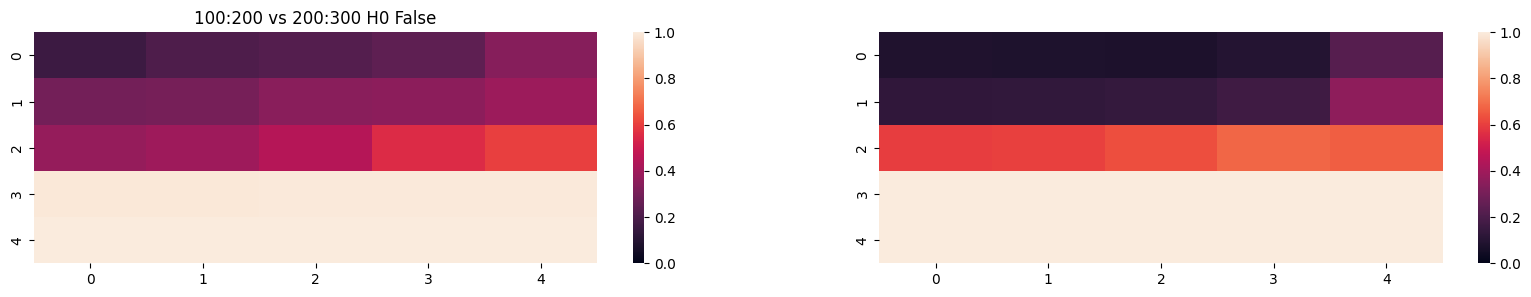

In [6]:
fig, ax = plt.subplots(1,2, figsize = (20,3))

sns.heatmap(p_vals[0], ax = ax[0],vmin = 0, vmax = 1)
ax[0].set_title("0:100 vs 100:200 H0 True")
sns.heatmap(p_vals[1], ax = ax[1],vmin = 0, vmax = 1)
ax[0].set_title("100:200 vs 200:300 H0 False")



Text(0.5, 1.0, '200:300 ')

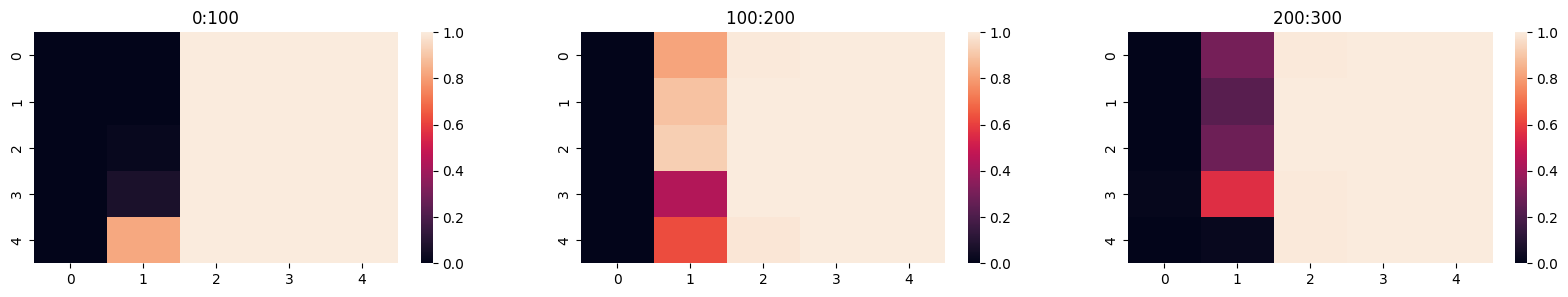

In [7]:
fig, ax = plt.subplots(1,3, figsize = (20,3))

sns.heatmap(p_val_s_cross[0], ax = ax[0])
ax[0].set_title("0:100")
sns.heatmap(p_val_s_cross[1], ax = ax[1])
ax[1].set_title("100:200 ")
sns.heatmap(p_val_s_cross[2], ax = ax[2])
ax[2].set_title("200:300 ")

Text(0.5, 1.0, '200:300 ')

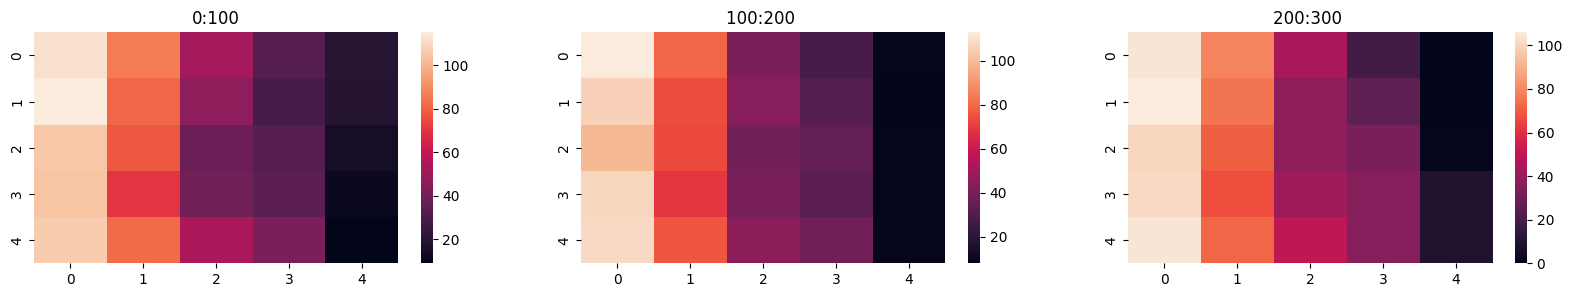

In [8]:
fig, ax = plt.subplots(1,3, figsize = (20,3))

sns.heatmap(nr_possible_removals[0], ax = ax[0])
ax[0].set_title("0:100")
sns.heatmap(nr_possible_removals[1], ax = ax[1])
ax[1].set_title("100:200 ")
sns.heatmap(nr_possible_removals[2], ax = ax[2])
ax[2].set_title("200:300 ")

# Simulation

In [20]:
        with open(f'../data/case_study_etf/raw_etf.pkl', 'rb') as handle:
            data = pickle.load(handle)

In [30]:
data['log_returns_scaled'].iloc[:500].mean()

IYR    0.032081
XLB    0.076723
XLE    0.047972
XLF    0.084762
XLI    0.082133
XLK    0.090239
XLP    0.037035
XLU    0.051765
XLV    0.038380
XLY    0.056795
XTL    0.051820
dtype: float64

In [31]:
data['log_returns_scaled'].iloc[:500].median()

IYR    0.087883
XLB    0.082892
XLE   -0.000245
XLF    0.043009
XLI    0.092713
XLK    0.115423
XLP    0.037034
XLU    0.113627
XLV    0.041638
XLY    0.076979
XTL    0.077393
dtype: float64

In [10]:
with open(f'../data/GraphHypTest/g_hyp_test_roc_test.pkl', 'rb') as handle:
    g_hyp_test  = pickle.load(handle)

In [17]:
g_hyp_test['p_vals'][0].shape

(2, 6, 10)

In [18]:
np.stack(g_hyp_test['p_vals']).shape

(6, 2, 6, 10)

In [8]:
g_hyp_test.keys()

dict_keys(['alphas', 'kappas'])